# Libraries

In [1]:
import numpy as np
import random
import pickle
import os
# Change directory to the root of the folder (this script was launched from the subfolder python_scripts)
# All utils presuppose that we are working from the root directory of the github folder
os.chdir("../")
import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime
import joblib
import gzip
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import cm
import matplotlib.ticker
import pingouin as pg
from cycler import cycler
from scipy.stats import gaussian_kde
import copy
from scipy.integrate import odeint
import glob
from sklearn.linear_model import LinearRegression
import csv
from collections import Counter
from statsmodels.formula.api import ols

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# local utils
from powerlaw_regr import *
from find_files_with_pattern import *

In [3]:
figures_folder = "./figures/"
os.makedirs(figures_folder, exist_ok = True)

In [4]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

multiplicator = 4
width_fig = 5.70978 * multiplicator # default text width in Comnet is 5.70978
height_fig = width_fig * 2 / 3

# this comes from "tableau-colorblind10",
CB_color_cycle = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
# Another good color blind one could be CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
#                   '#f781bf', '#a65628', '#984ea3',
#                   '#999999', '#e41a1c', '#dede00']
cmap_label = 'cividis'
params_default = {
    # change matplotlib cycle colors
    'axes.prop_cycle' : cycler('color', CB_color_cycle), 
    # change colormap
    'image.cmap' : 'cividis',
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 6 * multiplicator, #22,
    'axes.titlesize' : 6 * multiplicator, #25,
    'xtick.labelsize' : 5 * multiplicator, #18,
    'ytick.labelsize' : 5 * multiplicator, #18,
    'legend.fontsize' : 6 * multiplicator, #16,
    'font.size' : 6 * multiplicator,

    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 300,
    "savefig.bbox" : 'tight', 
    
#     'mathtext.fontset': 'stix',
#     'font.family': 'STIXGeneral',
    'font.family' : 'sans-serif', 
    'font.sans-serif' : ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana'], 
#     'text.usetex' : True,
#     'text.latex.preamble': r"\usepackage{amsmath}",
}

plt.rcParams.update(params_default)
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'.lower()

In [5]:
class continuous_and_dashed_line_handle(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        if orig_handle[2]:
            l1 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height],
                               linestyle=orig_handle[1], color=orig_handle[0])
            l2 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], 
                               color=orig_handle[0])
            return [l1, l2]
        else:
            l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height],
                               linestyle=orig_handle[1], color=orig_handle[0])
            return [l1]

class line_and_filled_handle(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height],
                               color=orig_handle[0])
            l2 = plt.Line2D([x0+width*0.1,y0+width*0.9], [0.5*height,0.5*height], 
                               color=orig_handle[1], lw=10)
            return [l1, l2]

Text(0, 0.5, 'Last.fm')

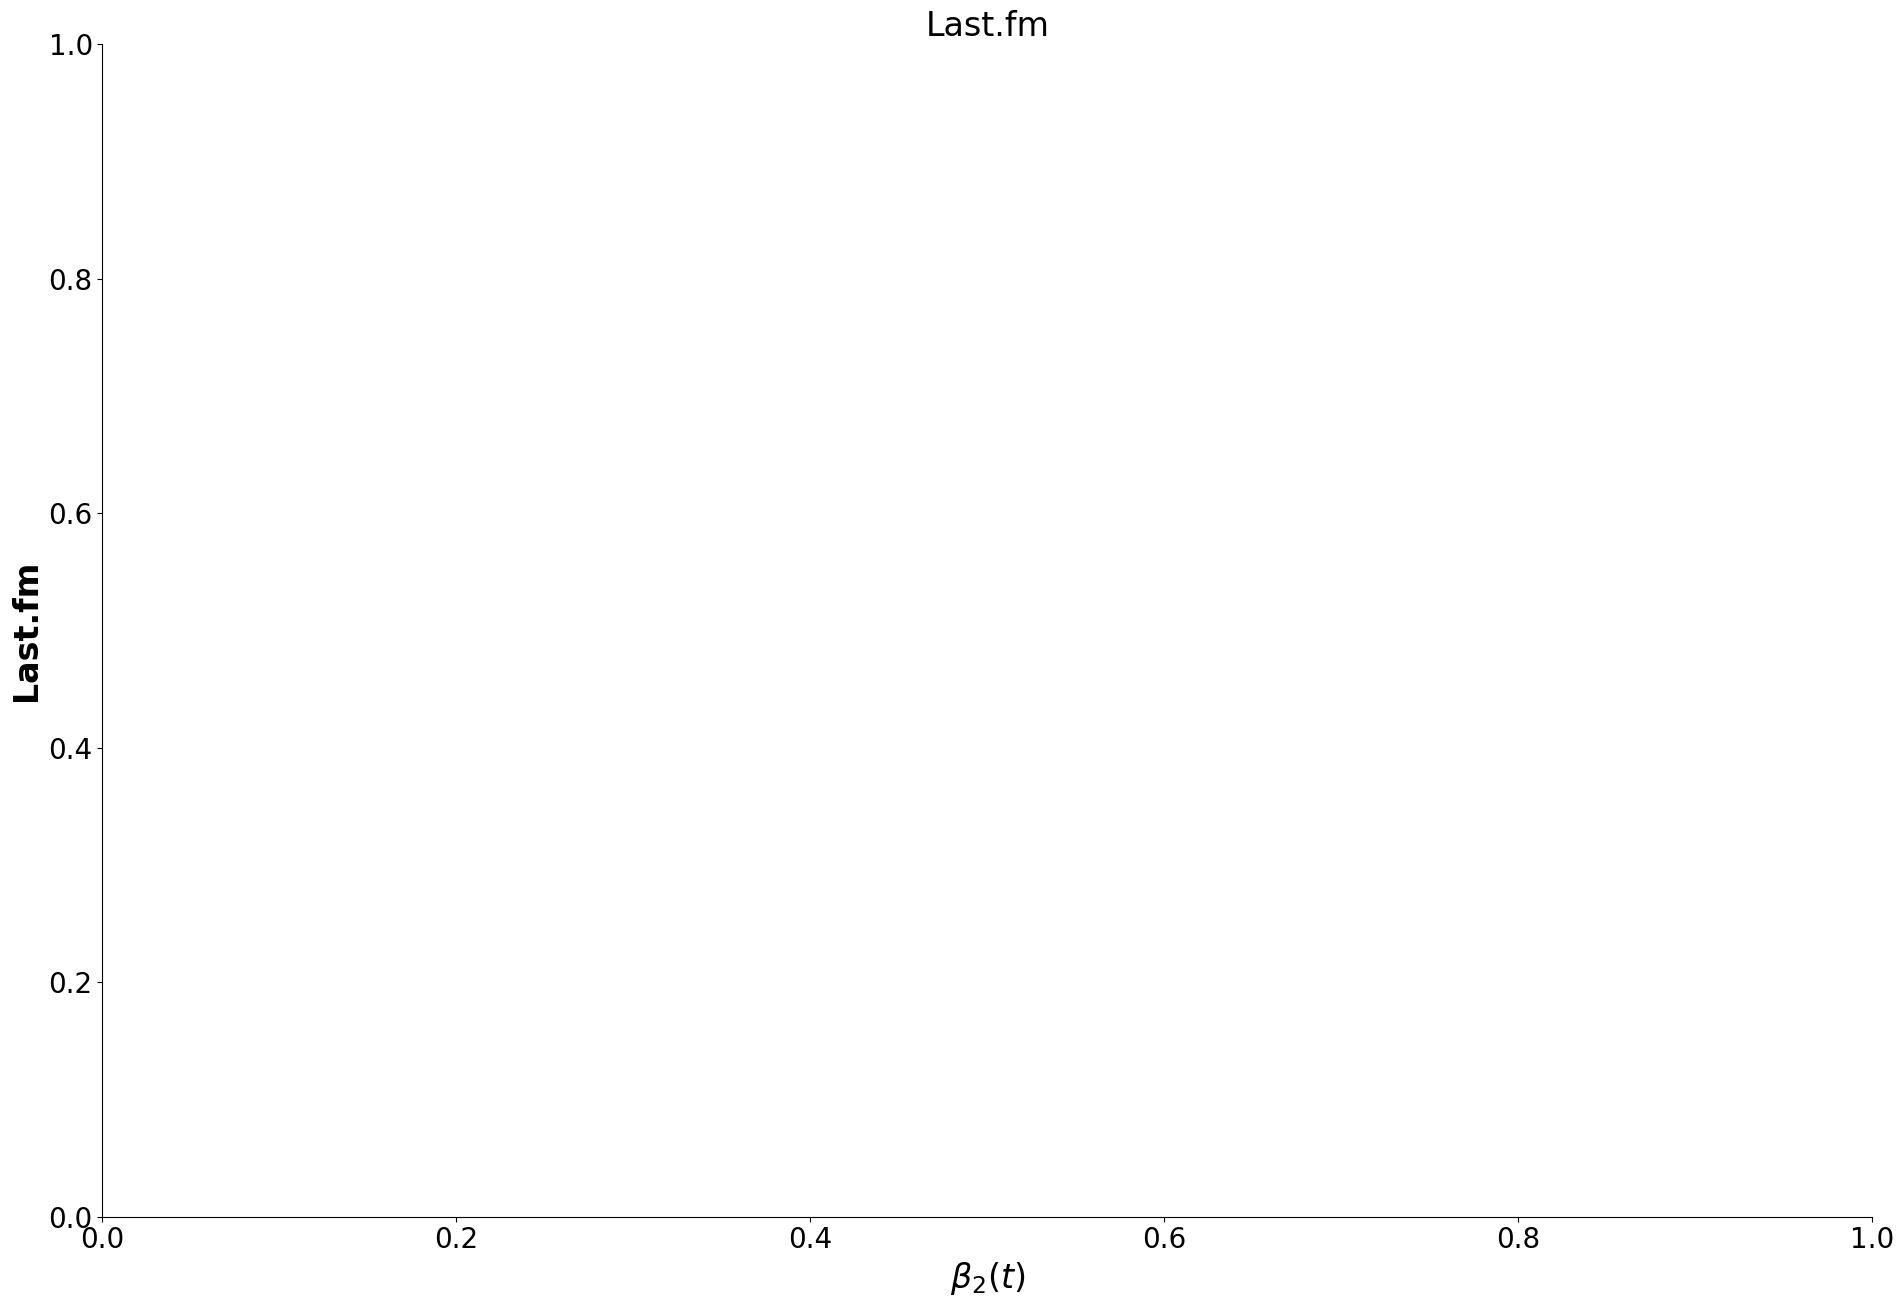

In [6]:
plt.title('Last.fm')
plt.xlabel(r"$\beta_2(t)$")
plt.ylabel('Last.fm', fontweight='bold')

# Load data

## Load essential data

In [7]:
with gzip.open('./data/essential_data_for_figures.pkl.gz', "rb") as fp:
    data = joblib.load(fp)

In [8]:
with gzip.open('./data/essential_data_labels_for_figures.pkl.gz', "rb") as fp:
    data_labels = joblib.load(fp)

## Dump essential data

Use this section only on the first run. Otherwise, just load the prepared data on the previous section

### Functions

In [32]:
def get_light_results(
    paths = []
):
    results = {}
    count = 0
    for path in tqdm(paths):
        with open(path, 'rb') as fp:
            result = joblib.load(fp)
        results[path] = result
        count += 1
    print(count, flush = True)
    return results

In [21]:
def get_fit_result_sequence(result):
    indices_geom = result['indices_geom']
    ts_geom = result['ts_geom']
    D_indices_geom = result['D_indices'][indices_geom]
    D2_indices_geom = result['D2_indices'][indices_geom]
    D3_indices_geom = result['D3_indices'][indices_geom]
    D4_indices_geom = result['D4_indices'][indices_geom]

    beta_list = []
    beta2_list = []
    beta3_list = []
    beta4_list = []
    intercept_list = []
    intercept2_list = []
    intercept3_list = []
    intercept4_list = []
    std_err_beta_list = []
    std_err_beta2_list = []
    std_err_beta3_list = []
    std_err_beta4_list = []
    std_err_intercept_list = []
    std_err_intercept2_list = []
    std_err_intercept3_list = []
    std_err_intercept4_list = []
    for i in range(len(ts_geom)):
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(0,i-100)+1:i+1], D_indices_geom[max(0,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta_list.append(slope)
        intercept_list.append(intercept)
        std_err_beta_list.append(std_err[0])
        std_err_intercept_list.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(1,i-100)+1:i+1]-1, D2_indices_geom[max(1,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta2_list.append(slope)
        intercept2_list.append(intercept)
        std_err_beta2_list.append(std_err[0])
        std_err_intercept2_list.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(2,i-100)+1:i+1]-2, D3_indices_geom[max(2,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta3_list.append(slope)
        intercept3_list.append(intercept)
        std_err_beta3_list.append(std_err[0])
        std_err_intercept3_list.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(3,i-100)+1:i+1]-3, D4_indices_geom[max(3,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta4_list.append(slope)
        intercept4_list.append(intercept)
        std_err_beta4_list.append(std_err[0])
        std_err_intercept4_list.append(std_err[1])
    result["beta"] = np.array(beta_list)
    result["beta2"] = np.array(beta2_list)
    result["beta3"] = np.array(beta3_list)
    result["beta4"] = np.array(beta4_list)
    result["intercept"] = np.array(intercept_list)
    result["intercept2"] = np.array(intercept2_list)
    result["intercept3"] = np.array(intercept3_list)
    result["intercept4"] = np.array(intercept4_list)
    result["std_err_beta"] = np.array(std_err_beta_list)
    result["std_err_beta2"] = np.array(std_err_beta2_list)
    result["std_err_beta3"] = np.array(std_err_beta3_list)
    result["std_err_beta4"] = np.array(std_err_beta4_list)
    result["std_err_intercept"] = np.array(std_err_intercept_list)
    result["std_err_intercept2"] = np.array(std_err_intercept2_list)
    result["std_err_intercept3"] = np.array(std_err_intercept3_list)
    result["std_err_intercept4"] = np.array(std_err_intercept4_list)
    return result

In [22]:
def get_info_stats_last_results(results):
    new_results = {}
    for order_index,order in enumerate(['', '2', '3', '4']):
        print(f"Order {order_index}")
        betas = []
        loglog_intercepts = []
        intercepts = []
        std_err_betas = []
        std_err_intercepts = []
        confidence_intervals_betas = []
        t_values_betas = []
        p_values_betas = []
        confidence_intervals_loglog_intercepts = []
        t_values_loglog_intercepts = []
        p_values_loglog_intercepts = []
        for result in results.values():
            indices_geom = result['indices_geom']
            ts_geom = result['ts_geom']
            D_indices_geom = result[f'D{order}_indices'][indices_geom]
            i = list(range(len(ts_geom)))[-1]
            xs = ts_geom[max(order_index,i-100)+1:i+1]-order_index
            ys = D_indices_geom[max(order_index,i-100)+1:i+1]
            xs = np.log10(xs)
            ys = np.log10(ys)
            beta, loglog_intercept, std_err, confidence_intervals, t_values, p_values = lin_regr_with_stats(
                xs, ys, 
                intercept_left_lim = 0, intercept_right_lim = np.inf, 
                get_more_statistcs = True, 
                alpha_for_conf_interv = 0.99
            )
            betas.append(beta)
            loglog_intercepts.append(loglog_intercept)
            intercepts.append(10**loglog_intercept)
            std_err_betas.append(std_err[0])
            std_err_intercepts.append(std_err[1])
            confidence_intervals_betas.append(confidence_intervals[0])
            t_values_betas.append(t_values[0])
            p_values_betas.append(p_values[0])
            confidence_intervals_loglog_intercepts.append(confidence_intervals[1])
            t_values_loglog_intercepts.append(t_values[1])
            p_values_loglog_intercepts.append(p_values[1])
        new_results[f'betas{order}'] = np.array(betas)
        new_results[f'loglog_intercepts{order}'] = np.array(loglog_intercepts)
        new_results[f'intercepts{order}'] = np.array(intercepts)
        new_results[f'std_err_betas{order}'] = np.array(std_err_betas)
        new_results[f'std_err_intercepts{order}'] = np.array(std_err_intercepts)
        new_results[f'confidence_intervals_betas{order}'] = np.array(confidence_intervals_betas)
        new_results[f't_values_betas{order}'] = np.array(t_values_betas)
        new_results[f'p_values_betas{order}'] = np.array(p_values_betas)
        new_results[f'confidence_intervals_loglog_intercepts{order}'] = np.array(confidence_intervals_loglog_intercepts)
        new_results[f't_values_loglog_intercepts{order}'] = np.array(t_values_loglog_intercepts)
        new_results[f'p_values_loglog_intercepts{order}'] = np.array(p_values_loglog_intercepts)
    new_results['len'] = np.array([result["ts"][-1] for result in results.values()])
    return new_results

In [560]:
np.array(dataset['average_results']['indices_geom'])[[100, 200, -1]]

array([ 100,  253, 9113])

In [565]:
# xs = dataset['average_results']['ts'][np.array(dataset['average_results']['indices_geom'])[[100, 200, -1]]]
# ys = dataset['average_results']['D_indices'][np.array(dataset['average_results']['indices_geom'])[[100, 200, -1]]]
xs = dataset['average_results']['ts'][np.array(dataset['average_results']['indices_geom'])[-100:]]
ys = dataset['average_results']['D_indices'][np.array(dataset['average_results']['indices_geom'])[-100:]]
beta, loglog_intercept, std_err, confidence_intervals, t_values, p_values = lin_regr_with_stats(
    xs, ys, 
    intercept_left_lim = 0, intercept_right_lim = np.inf, 
    get_more_statistcs = True, 
    alpha_for_conf_interv = 0.99
)

In [566]:
confidence_intervals[0]

array([0.15103212, 0.15450362])

In [567]:
beta, loglog_intercept, std_err, confidence_intervals, t_values, p_values

(0.15276787061454672,
 503.04182917027543,
 array([0.00073393, 0.        ]),
 array([[1.51032122e-01, 1.54503619e-01],
        [4.92269444e+02, 5.13814214e+02]]),
 array([208.15016886, 110.43934189]),
 array([0., 0.]))

In [564]:
confidence_intervals[0]

array([0.05078805, 0.34361961])

In [562]:
beta, loglog_intercept, std_err, confidence_intervals, t_values, p_values

(0.19720383256773966,
 72.69146104764783,
 array([0.0046013, 0.       ]),
 array([[ 5.07880532e-02,  3.43619612e-01],
        [-6.98090824e+02,  8.43473746e+02]]),
 array([42.85827476,  3.00095091]),
 array([0.01485137, 0.20477225]))

### Data

In [34]:
results_light = {}
for dataset_label, tmp_folder in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light",
    'Project Gutenberg' : './data/gutenberg/analysis/individual_results_light', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/journals_fieldsOfStudy_light', 
}.items():
    print(dataset_label)
    paths = sorted(find_pattern('*_light.pkl', tmp_folder, check_only_in_file_name = False))
    results_light[dataset_label] = get_light_results(
        paths = paths
    )

Last.fm


  0%|          | 0/890 [00:00<?, ?it/s]

890
Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

19637
Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

19000


In [35]:
average_results = {}
for dataset_label, path in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/average_individual_results.pkl",
    'Project Gutenberg' : './data/gutenberg/analysis/average_individual_results.pkl', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/average_individual_results_journals_fieldsOfStudy.pkl', 
}.items():
    print(dataset_label)
    with open(path, 'rb') as fp:
        average_results[dataset_label] = joblib.load(fp)

Last.fm
Project Gutenberg
Semantic Scholar


In [36]:
data = {}
for dataset_label, results in results_light.items():
    print(f"Starting {dataset_label}")
    data[dataset_label] = get_info_stats_last_results(results)
    data[dataset_label]['average_results'] = get_fit_result_sequence(average_results[dataset_label])
with gzip.open('./data/essential_data_for_figures.pkl.gz', "wb") as fp:
    joblib.dump(data, fp)
print('Dumped')

Starting Last.fm
Order 0


/data/Maths-LatoraLab/GDB/pairs_petralia/github/utils/powerlaw_regr.py:182: RuntimeWarning: divide by zero encountered in true_divide
  tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics


Order 1
Order 2
Order 3


/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Starting Project Gutenberg
Order 0
Order 1
Order 2
Order 3
Starting Semantic Scholar
Order 0
Order 1
Order 2
Order 3
Dumped


### Data labels

In [37]:
results_light_labels = {}
for dataset_label, tmp_folder in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists_light",
    'Project Gutenberg' : './data/gutenberg/analysis/individual_results_stems_light', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/journals_fieldsOfStudy_stems_light', 
}.items():
    print(dataset_label)
    paths = sorted(find_pattern('*_light.pkl', tmp_folder, check_only_in_file_name = False))
    results_light_labels[dataset_label] = get_light_results(
        paths = paths
    )

Last.fm


  0%|          | 0/890 [00:00<?, ?it/s]

890
Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

19637
Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

19000


In [40]:
average_results_labels = {}
for dataset_label, path in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/average_individual_results_artists.pkl",
    'Project Gutenberg' : './data/gutenberg/analysis/average_individual_results_stems.pkl', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/average_individual_results_journals_fieldsOfStudy_stems.pkl', 
}.items():
    print(dataset_label)
    with open(path, 'rb') as fp:
        average_results_labels[dataset_label] = joblib.load(fp)

Last.fm
Project Gutenberg
Semantic Scholar


In [41]:
data_labels = {}
for dataset_label, results in results_light_labels.items():
    print(f"Starting {dataset_label}")
    data_labels[dataset_label] = get_info_stats_last_results(results)
    data_labels[dataset_label]['average_results'] = get_fit_result_sequence(average_results[dataset_label])
with gzip.open('./data/essential_data_for_figures.pkl.gz', "wb") as fp:
    joblib.dump(data_labels, fp)
print('Dumped')

Starting Last.fm
Order 0
Order 1
Order 2
Order 3
Starting Project Gutenberg
Order 0
Order 1
Order 2
Order 3
Starting Semantic Scholar
Order 0
Order 1
Order 2
Order 3
Dumped


## Get data with valid Heaps law

In [53]:
def subplot_distr(data, 
                  key,
                    ax = None, alpha = 0.5, 
                    number_to_write = 0, 
                    num_bins = 35,
                    xlim_left = -0.1, xlim_right = 0.6, 
                    xlabel = r"$\langle \Delta S_n \rangle$", 
                    ylabel = r"pdf", 
                    do_legend = True,
                    write_number = False,
):
    if ax == None:
        fig, ax = plt.subplots()
    
    if xlim_left == None:
        xlim_left = 1000000
        for dataset_label, dataset_dict in data.items():        
            xlim_left = min(xlim_left, min(dataset_dict[key]))
    if xlim_right == None:
        xlim_right = -10000
        for dataset_label, dataset_dict in data.items():        
            xlim_right = max(xlim_right, max(dataset_dict[key]))

    for i, (dataset_label, dataset_dict) in enumerate(data.items()):
        data_to_hist = dataset_dict[key]
        hist,bin_edges = np.histogram(data_to_hist, 
                np.linspace(xlim_left, xlim_right, num_bins), 
                density=True)
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
        p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = dataset_label if do_legend else None, color = CB_color_cycle[i])#r"$\langle \Delta S_{%d} \rangle$"%(n_order))
        ax.axvline(np.mean(data_to_hist), ls = '--', alpha=0.5,lw=3, label = f'avg: {np.mean(data_to_hist):.3f}', color = CB_color_cycle[i])
    
#     # Impose xticks
#     ax.set_xticks(np.arange(-10,10.0000001,0.1), minor=True)
#     ax.set_xticks(np.arange(-10,10.0000001,0.2), minor=False)
    
    ax.set_xlim(left = xlim_left, right = xlim_right)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#     if do_legend == True:
    leg = ax.legend(handletextpad=0.2, loc="best", labelspacing = 0.1, fontsize = 16) # , bbox_to_anchor=(0.0,1.06), loc="upper left") # labelspacing = 0, 
#         for lh in leg.legendHandles: 
#             lh.set_alpha(1)

    if write_number == True:
        ax.text(0.05, 1.0, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    return ax

In [346]:
dataset.keys()

dict_keys(['betas', 'loglog_intercepts', 'intercepts', 'std_err_betas', 'std_err_intercepts', 'confidence_intervals_betas', 't_values_betas', 'p_values_betas', 'confidence_intervals_loglog_intercepts', 't_values_loglog_intercepts', 'p_values_loglog_intercepts', 'betas2', 'loglog_intercepts2', 'intercepts2', 'std_err_betas2', 'std_err_intercepts2', 'confidence_intervals_betas2', 't_values_betas2', 'p_values_betas2', 'confidence_intervals_loglog_intercepts2', 't_values_loglog_intercepts2', 'p_values_loglog_intercepts2', 'betas3', 'loglog_intercepts3', 'intercepts3', 'std_err_betas3', 'std_err_intercepts3', 'confidence_intervals_betas3', 't_values_betas3', 'p_values_betas3', 'confidence_intervals_loglog_intercepts3', 't_values_loglog_intercepts3', 'p_values_loglog_intercepts3', 'betas4', 'loglog_intercepts4', 'intercepts4', 'std_err_betas4', 'std_err_intercepts4', 'confidence_intervals_betas4', 't_values_betas4', 'p_values_betas4', 'confidence_intervals_loglog_intercepts4', 't_values_logl

<AxesSubplot:xlabel='std err2', ylabel='pdf'>

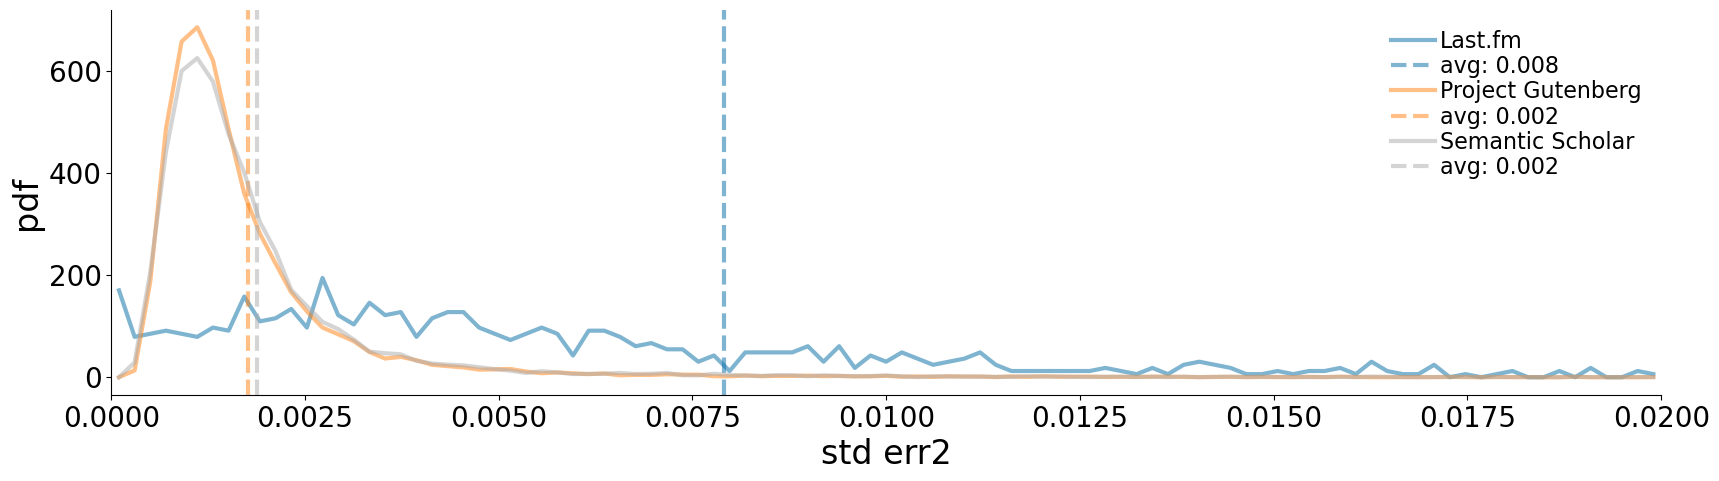

In [356]:
fig, ax = plt.subplots(figsize = (20,5))
# dataset['std_err_betas'] = np.array(dataset['std_err_betas'])
subplot_distr(
    data, 
    key = 'std_err_betas2',
    ax = ax, alpha = 0.5, 
    number_to_write = 0, 
    num_bins = 100,
    xlim_left = 0, xlim_right = 0.02, 
    xlabel = r"std err2", 
    ylabel = r"pdf", 
    do_legend = True,
    write_number = False,
)

### Data

In [868]:
data_small_error = {}
for dataset_label, dataset in tqdm(data.items()):
    print(dataset_label, flush=True)
    data_small_error[dataset_label] = {}
    for key in dataset.keys():
        if key != 'average_results':
            data_small_error[dataset_label][key] = []
    count = 0
    for i,std_err in enumerate(dataset['std_err_betas']):
        if std_err < 0.05 and dataset['std_err_betas2'][i] < 0.05:
            count += 1
            for key in dataset.keys():
                if key != 'average_results':
                    data_small_error[dataset_label][key].append(dataset[key][i])
    print(f"Retained {count} / {len(dataset['std_err_betas'])}, removed {(len(dataset['std_err_betas']) - count)} = {(len(dataset['std_err_betas']) - count) / len(dataset['std_err_betas']) * 100 : .2f} %")
    data_small_error[dataset_label]['average_results'] = dataset['average_results']

  0%|          | 0/3 [00:00<?, ?it/s]

Last.fm
Retained 860 / 890, removed 30 =  3.37 %
Project Gutenberg
Retained 19629 / 19637, removed 8 =  0.04 %
Semantic Scholar
Retained 18995 / 19000, removed 5 =  0.03 %


In [520]:
(1.0 - scipy.stats.t.cdf(np.abs(3), 4)) * 2.0

0.03994196807171879

In [510]:
data_small_error = {}
for dataset_label, dataset in tqdm(data.items()):
    print(dataset_label, flush=True)
    data_small_error[dataset_label] = {}
    for key in dataset.keys():
        if key != 'average_results':
            data_small_error[dataset_label][key] = []
    count = 0
    for i,std_err in enumerate(dataset['p_values_betas']):
        if std_err < 0.01 and dataset['p_values_betas2'][i] < 0.01:
            count += 1
            for key in dataset.keys():
                if key != 'average_results':
                    data_small_error[dataset_label][key].append(dataset[key][i])
    print(f"Retained {count} / {len(dataset['std_err_betas'])}, removed {(len(dataset['std_err_betas']) - count) / len(dataset['std_err_betas']) * 100 : .2f} %")
    data_small_error[dataset_label]['average_results'] = dataset['average_results']

  0%|          | 0/3 [00:00<?, ?it/s]

Last.fm
Retained 890 / 890, removed  0.00 %
Project Gutenberg
Retained 19637 / 19637, removed  0.00 %
Semantic Scholar
Retained 19000 / 19000, removed  0.00 %


In [201]:
    print(f"Starting {dataset_label}")
    data[dataset_label] = get_info_stats_last_results(results)
    data[dataset_label]['average_results'] = get_fit_result_sequence(average_results[dataset_label])
with gzip.open('./data/essential_data_for_figures.pkl.gz', "wb") as fp:
    joblib.dump(data, fp)
print('Dumped')

In [202]:
dataset.keys()

dict_keys(['betas', 'loglog_intercepts', 'intercepts', 'std_err_betas', 'std_err_intercepts', 'confidence_intervals_betas', 't_values_betas', 'p_values_betas', 'confidence_intervals_loglog_intercepts', 't_values_loglog_intercepts', 'p_values_loglog_intercepts', 'betas2', 'loglog_intercepts2', 'intercepts2', 'std_err_betas2', 'std_err_intercepts2', 'confidence_intervals_betas2', 't_values_betas2', 'p_values_betas2', 'confidence_intervals_loglog_intercepts2', 't_values_loglog_intercepts2', 'p_values_loglog_intercepts2', 'betas3', 'loglog_intercepts3', 'intercepts3', 'std_err_betas3', 'std_err_intercepts3', 'confidence_intervals_betas3', 't_values_betas3', 'p_values_betas3', 'confidence_intervals_loglog_intercepts3', 't_values_loglog_intercepts3', 'p_values_loglog_intercepts3', 'betas4', 'loglog_intercepts4', 'intercepts4', 'std_err_betas4', 'std_err_intercepts4', 'confidence_intervals_betas4', 't_values_betas4', 'p_values_betas4', 'confidence_intervals_loglog_intercepts4', 't_values_logl

In [34]:
results_light = {}
for dataset_label, tmp_folder in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light",
    'Project Gutenberg' : './data/gutenberg/analysis/individual_results_light', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/journals_fieldsOfStudy_light', 
}.items():
    print(dataset_label)
    paths = sorted(find_pattern('*_light.pkl', tmp_folder, check_only_in_file_name = False))
    results_light[dataset_label] = get_light_results(
        paths = paths
    )

Last.fm


  0%|          | 0/890 [00:00<?, ?it/s]

890
Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

19637
Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

19000


In [35]:
average_results = {}
for dataset_label, path in {
    'Last.fm' : "./data/ocelma-dataset/lastfm-dataset-1K/average_individual_results.pkl",
    'Project Gutenberg' : './data/gutenberg/analysis/average_individual_results.pkl', 
    'Semantic Scholar' : './data/semanticscholar/2022-01-01/analysis/average_individual_results_journals_fieldsOfStudy.pkl', 
}.items():
    print(dataset_label)
    with open(path, 'rb') as fp:
        average_results[dataset_label] = joblib.load(fp)

Last.fm
Project Gutenberg
Semantic Scholar


In [36]:
data = {}
for dataset_label, results in results_light.items():
    print(f"Starting {dataset_label}")
    data[dataset_label] = get_info_stats_last_results(results)
    data[dataset_label]['average_results'] = get_fit_result_sequence(average_results[dataset_label])
with gzip.open('./data/essential_data_for_figures.pkl.gz', "wb") as fp:
    joblib.dump(data, fp)
print('Dumped')

Starting Last.fm
Order 0


/data/Maths-LatoraLab/GDB/pairs_petralia/github/utils/powerlaw_regr.py:182: RuntimeWarning: divide by zero encountered in true_divide
  tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics


Order 1
Order 2
Order 3


/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Starting Project Gutenberg
Order 0
Order 1
Order 2
Order 3
Starting Semantic Scholar
Order 0
Order 1
Order 2
Order 3
Dumped


# Figure: Higher order Heaps' exponents DATA

## Functions

In [590]:
def subplot_heaps_law(
    average_result, 
    ax = None, marker_size = 20, alpha = 1, 
    number_to_write = 0, 
    xlim_left = 1, xlim_right = None, 
    ylim_bottom = 1, ylim_top = None, 
    xlabel = None, 
    ylabel = None, 
    title = None,
    write_number = False,
    shaded_above_heaps_keyword = '_plus_std',
    shaded_below_heaps_keyword = '_minus_std',
):
    if ax == None:
        fig, ax = plt.subplots()
    labels = []
    for i,order in enumerate(['', '2', '3']): # , '4'
        if shaded_above_heaps_keyword is not None and shaded_below_heaps_keyword is not None:
            if 'indices' in shaded_above_heaps_keyword and 'indices' in shaded_below_heaps_keyword:
                ax.fill_between(average_result["ts"]-i, 
                                average_result[f"D{order}{shaded_below_heaps_keyword}"], 
                                average_result[f"D{order}{shaded_above_heaps_keyword}"],
                                alpha = 0.25, facecolor = CB_color_cycle[i], 
                                zorder = i, edgecolor=None,
                               )
            else:
                ax.fill_between(average_result["ts"]-i, 
                                average_result[f"D{order}{shaded_below_heaps_keyword}"][average_result['indices']], 
                                average_result[f"D{order}{shaded_above_heaps_keyword}"][average_result['indices']],
                                alpha = 0.25, facecolor = CB_color_cycle[i], 
                                zorder = i, edgecolor=None,
                               )
        ax.plot(average_result["ts"]-i, average_result[f"D{order}_indices"], color = CB_color_cycle[i], zorder = 200+i,)
#         ax.plot([1]+list(average_result["ts"]-i+1), [1]+list(average_result[f"D{order}_indices"]), color = CB_color_cycle[i])
#         ax.plot(average_result["ts"],average_result["ts"]**average_result[f"beta{order}"][-1] * (average_result[f"D{order}_indices"][-1]/average_result["ts"][-1]**average_result[f"beta{order}"][-1]), 
        if f"intercept{order}" in average_result:
            intercept = average_result[f"intercept{order}"][-1]
        else:
            intercept = 1
        ax.plot(average_result["ts"], intercept * average_result["ts"]**average_result[f"beta{order}"][-1], # * (average_result[f"D{order}_indices"][-1]/average_result["ts"][-1]**average_result[f"beta{order}"][-1]), 
                color = CB_color_cycle[i], ls = "--", alpha=alpha, zorder = 100+i,)
        if order == '':
            labels.append(r"$D_1(t)\sim t^{%.2f}$"%(average_result["beta"][-1]))
        else:
            labels.append(r"$D_{%s}(t)\sim t^{%.2f}$"%(order, average_result[f"beta{order}"][-1]))
        
    ax.set_xlim(left = xlim_left, right = xlim_right)
    ax.set_ylim(bottom = ylim_bottom, top = ylim_top)
    ax.set_xlabel(xlabel)#, fontweight='bold')
    ax.set_ylabel(ylabel)#, fontweight='bold')
    ax.set_title(title)#, fontweight='bold')
    ax.loglog()
    # Impose xticks
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=20) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # Impose yticks
    ax.yaxis.set_major_locator(locmaj)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # Legend
#     leg1 = ax.legend([(color,"--",True) for color in CB_color_cycle[:2]], labels[:2] , 
#                      handler_map={tuple: continuous_and_dashed_line_handle()},
#                      handletextpad=0.1, bbox_to_anchor=(-0.06,1.1), loc="upper left", labelspacing = 0, handlelength = 1.5
#     ) 

#     leg2 = ax.legend([(color,"--",True) for color in CB_color_cycle[2:4]], labels[2:] , 
    leg = ax.legend([(color,"--",True) for color in CB_color_cycle], labels, 
                     handler_map={tuple: continuous_and_dashed_line_handle()},
                     handletextpad=0.1, bbox_to_anchor=(1.06,-0.06), loc="lower right", labelspacing = 0, handlelength = 1.5
    )
    leg.set_zorder(99999)
#     ax.add_artist(leg1)
    if write_number == True:
#         ax.text(0.5, 1.08, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='center')
        ax.text(0.05, 1, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    return ax

In [184]:
def scatter_with_density(x, y, z=None, ax = None, alpha = 1, marker_size = 20, label_scatter = None):
    if ax == None:
        fig, ax = plt.subplots()
    x = np.array(x)
    y = np.array(y)

    if z is None:
        # Calculate the point density
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
    else:
        z = np.array(z)
        
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
        
    ax.scatter(x, y, c=z, s=marker_size, alpha = alpha, label = label_scatter, rasterized=True, zorder = 100)

In [831]:
# def plot_distribution_histograms_on_axes(x, y, ax = None, color_x = None, color_y = None, alpha = 0.3, max_hist = 0.25, min_x = None, max_x = None, min_y = None, max_y = None):
#     if min_x == None:
#         min_x = min(x)
#     if max_x == None:
#         max_x = max(x)
#     if min_y == None:
#         min_y = min(y)
#     if max_y == None:
#         max_y = max(y)
#     n, bins, rects = ax.hist(x,density=True, bins = np.linspace(min_x,max_x, 30),alpha=alpha, bottom=min_y-0.02, color=color_x, rasterized=True)
#     max_hist_proportioned = max_hist * (max_y-0.02 - min_y+0.02)
#     max_height = max(1,max([r.get_height() for r in rects]))
#     for r in rects:
#         r.set_height(r.get_height()*max_hist_proportioned/max_height)
#     n, bins, rects = ax.hist(y,density=True, bins = np.linspace(min_y,max_y, 30),alpha=alpha, bottom=min_x-0.02, orientation='horizontal',color=color_y, rasterized=True)
#     max_hist_proportioned = max_hist * (max_x-0.02 - min_x+0.02)
#     max_width = max(1,max([r.get_width() for r in rects]))
#     for r in rects:
#         r.set_width(r.get_width()*max_hist_proportioned/max_width)
        

In [832]:
def plot_distribution_histograms_on_axes(
    x, y, z = None, ax = None, color_x = None, color_y = None, alpha = 0.3, max_hist = 0.25, 
    num_bins_x = 30, num_bins_y = 30,
    min_x = None, max_x = None, min_y = None, max_y = None):
    if min_x == None:
        min_x = min(x)
    if max_x == None:
        max_x = max(x)
    if min_y == None:
        min_y = min(y)
    if max_y == None:
        max_y = max(y)
    if z is not None:
        # ACHTUNG THIS PRESUPPOSES THAT THERE ARE THE SAME NUMBER OF DATA FOR EACH DIFFERENT Z
        set_z = set(z)
        z_to_x = {}
        z_to_y = {}
        for i,x_ in enumerate(x):
            z_ = z[i]
            if z_ not in z_to_x:
                z_to_x[z_] = []
                z_to_y[z_] = []
            z_to_x[z_].append(x_)
            z_to_y[z_].append(y[i])
        new_x = []
        new_y = []
        cmap = cm.get_cmap(cmap_label)
        norm = Normalize(vmin=min(set_z), vmax=max(set_z))
        color_x = []
        color_y = []
        for z_ in sorted(set_z):
            new_x.append(np.array(z_to_x[z_]))
            new_y.append(np.array(z_to_y[z_]))
            rgba_color = cmap(norm(z_)) 
            color_x.append(rgba_color) 
            color_y.append(rgba_color) 
    else:
        new_x = x
        new_y = y

    max_hist_proportioned = max_hist * (max_y-0.02 - min_y+0.02)
    if z is None:
        n, bins, rects = ax.hist(new_x,density=True, bins = np.linspace(min_x,max_x, num_bins_x),alpha=alpha, bottom=min_y-0.02, color=color_x, rasterized=True, zorder = -100)
#         max_height = max(1,max([r.get_height() for r in rects]))
        max_height = max([r.get_height() for r in rects])
        for r in rects:
            new_height = r.get_height()*max_hist_proportioned/max_height
            r.set_height(new_height)
    else:
        n, bins, rects = ax.hist(new_x,density=True, bins = np.linspace(min_x,max_x, num_bins_x),alpha=alpha, bottom=min_y-0.02, color=color_x, stacked=True, rasterized=True, zorder = -100)
        max_height_dict = {i:0 for i in range(len(bins))}
        for rects_ in rects:
            for i,r in enumerate(rects_):
                max_height_dict[i] += r.get_height()
        max_height = max(1,max([_ for _ in max_height_dict.values()]))
        bottom = min_y-0.02
        current_height = {i:bottom for i in range(len(bins))}
        for rects_ in rects:
            for i,r in enumerate(rects_):
                r.set_y(current_height[i])
                new_height = r.get_height()*max_hist_proportioned/max_height
                r.set_height(new_height)
                current_height[i] += new_height
    max_hist_proportioned = max_hist * (max_x-0.02 - min_x+0.02)
    if z is None:
        n, bins, rects = ax.hist(new_y,density=True, bins = np.linspace(min_y,max_y, num_bins_y),alpha=alpha, bottom=min_x-0.02, orientation='horizontal',color=color_y, rasterized=True, zorder = -100)
        max_hist_proportioned = max_hist * (max_x-0.02 - min_x+0.02)
        max_width = max([r.get_width() for r in rects])
        for r in rects:
            r.set_width(r.get_width()*max_hist_proportioned/max_width)
    else:
        n, bins, rects = ax.hist(new_y,density=True, bins = np.linspace(min_y,max_y, num_bins_y),alpha=alpha, bottom=min_x-0.02, orientation='horizontal', stacked=True,color=color_y, rasterized=True, zorder = -100)
        max_width_dict = {i:0 for i in range(len(bins))}
        for rects_ in rects:
            for i,r in enumerate(rects_):
                max_width_dict[i] += r.get_width()
        max_width = max(1,max([_ for _ in max_width_dict.values()]))
        bottom = min_y-0.02
        current_width = {i:bottom for i in range(len(bins))}
        for rects_ in rects:
            for i,r in enumerate(rects_):
                r.set_x(current_width[i])
                new_width = r.get_width()*max_hist_proportioned/max_width
                r.set_width(new_width)
                current_width[i] += new_width

In [186]:
def last_modifications_subplot_scatter_beta(
    x, y, number_to_write = 0, write_number = False, 
    do_dashed_line = True, do_dashed_line_label = False,plot_pearson = True,
    x_correlation_text = 0.63, y_correlation_text = .32, ax = None, ylabel = None, xlabel = None, min_x = None, max_x = None, min_y = None, max_y = None,
):
    if min_x == None:
        min_x = min(x)
    if max_x == None:
        max_x = max(x)
    if min_y == None:
        min_y = min(y)
    if max_y == None:
        max_y = max(y)
    xlim = [min_x-0.02, max_x + 0.02]
    ylim = [min_y-0.02, max_y + 0.02]
    if do_dashed_line == True:
#         ax.plot([min_x-0.02, max_x + 0.02], [min_x-0.02,max_x + 0.02], '--', color="gray") 
        ax.plot([-100000, 100000], [-100000, 100000], '--', color="gray", label = r"y=x" if do_dashed_line_label else None) 
    
#     leg = ax.legend(handletextpad=0.1,bbox_to_anchor=(1.06,0.5), loc="center right", labelspacing = 0, handlelength = 1.5)
    if plot_pearson:
        model = ols("y ~ x", data={"x":x, "y":y}).fit()
        intercept, slope = model.params
        print('intercept',intercept, 'slope', slope, flush=True)
        pearsonr_test = pearsonr(x,y)
    #     text_to_write = r'$R^2=%.2f$'%(pearsonr_test[0]**2)
        if intercept >= 0:
            text_to_write = r'$y=%.2fx+%.2f$'%(slope,intercept) + '\n' + r'($R^2=%.2f$)'%(pearsonr_test[0]**2)
        else:
            text_to_write = r'$y=%.2fx-%.2f$'%(slope,-intercept) + '\n' + r'($R^2=%.2f$)'%(pearsonr_test[0]**2)
        ax.plot([-100000, 100000], np.array([-100000, 100000])*slope + intercept, ':', c="red", label = text_to_write)
        print(f"p-value pearson between {xlabel} and {ylabel}", pearsonr_test[1], flush=True)
    #     ax.text(x_correlation_text, y_correlation_text, text_to_write, transform=ax.transAxes, fontsize=multiplicator*6) #  fontsize=32, 
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # Impose xticks
    if min_x > -0.1 and min_x <=0 and max_x >= 1 and max_x < 1.1: 
        ax.set_xticks(np.arange(0,1.0000001,0.1), minor=True)
        ax.set_yticks(np.arange(0,1.0000001,0.1), minor=True)
        ax.set_xticks(np.arange(0,1.0000001,0.2), minor=False)
        ax.set_yticks(np.arange(0,1.0000001,0.2), minor=False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.legend(handletextpad=0.1, bbox_to_anchor=(x_correlation_text, y_correlation_text), loc="lower right", labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) #  fontsize=32, 
    
    if write_number == True:
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'.lower()
#         ax.text(0.5, 1.08, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='center')
        ax.text(0.05, 1, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')

In [804]:
def subplot_scatter_beta(
    x, 
    y, 
    z = None,
    ax = None, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    plot_pearson = True,
    x_correlation_text = 0.63, 
    y_correlation_text = .32,
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.25, 
    num_bins_x = 30, 
    num_bins_y = 30,
    number_to_write = 0, 
    write_number = False, 
    ylabel = None, 
    xlabel = None, 
    min_x = None, 
    max_x = None,
    min_y = None, 
    max_y = None,
    do_dashed_line = True,
    do_dashed_line_label = True,
    do_special_hist = True,
):
    if min_x == None:
        min_x = min(x)
    if max_x == None:
        max_x = max(x)
    if min_y == None:
        min_y = min(y)
    if max_y == None:
        max_y = max(y)
    if ax == None:
        fig, ax = plt.subplots()
    scatter_with_density(x, y, z = z, ax = ax, alpha = alpha_scatter, marker_size = marker_size)
    plot_distribution_histograms_on_axes(
        x, y, z = z if do_special_hist else None, ax = ax, color_x = color_x, color_y = color_y, alpha = alpha_histogram, 
        max_hist = max_hist, num_bins_x = num_bins_x, num_bins_y = num_bins_y,
        min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y
    )
    last_modifications_subplot_scatter_beta(x, y, do_dashed_line = do_dashed_line,do_dashed_line_label = do_dashed_line_label, plot_pearson = plot_pearson,
                                         number_to_write = number_to_write, write_number = write_number, x_correlation_text = x_correlation_text, y_correlation_text = y_correlation_text, ax = ax, ylabel = ylabel, xlabel = xlabel, min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)


In [199]:
def fig_1(
    data, 
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, xlim_left_a = 1, ylim_bottom_a = 1,
    min_beta = None,
    max_beta = None,
    min_beta_higher = None,
    max_beta_higher = None,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    do_dashed_line_label = True,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    shaded_above_heaps_keyword = '_plus_std',
    shaded_below_heaps_keyword = '_minus_std',
):
    higher_orders = [2,3]
    nrows = len(higher_orders) + 1
    ncols = num_datasets = len(data)
    fig = plt.figure(figsize=(width_fig*ncols/3,width_fig*4/5*nrows/3))
#     outer = gridspec.GridSpec(nrows=num_datasets+1, ncols=1,height_ratios = [10]*num_datasets+[3],hspace=0.35) # 0.25
    outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10*nrows]+[3], hspace=0.15, wspace=0.15) # 0.25
    
    
    wspace = 0.25
    hspace = 0.35
    
    # get highest t and D to unify panel a
    if use_same_x_y_max_lim == True:
        max_t = 1
        max_D = 1
        for dataset_label, dataset_dict in data.items():
            max_t = max(max_t, dataset_dict['average_results']["ts"][-1]+1)
            for order in ['', '2', '3']: #  '4'
                max_D = max(max_D, dataset_dict['average_results'][f"D{order}_indices"][-1]+1)
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                        subplot_spec=outer[0],wspace=wspace,hspace=hspace)
                
    for column, (dataset_label, dataset_dict) in enumerate(data.items()):
        print(dataset_label)
        ax = plt.Subplot(fig, inner[column])
        if use_same_x_y_max_lim == False:
            max_t = dataset_dict['average_results']["ts"][-1]+1
            max_D = 1
            for order in ['']+[str(tmp_order) for tmp_order in higher_orders]:
                max_D = max(max_D, dataset_dict['average_results'][f"D{order}_indices"][-1]+1)
        xlabel_heaps_law = r"$t$"
        ylabel_heaps_law = r'$D_n(t)$' if column == 0 else None
#         ax.plot([1, max_t], [1, max_D], '--', color='black', alpha = 1, zorder = 9999,
#                label = r"$y=x$" if column == 0 else None)
        subplot_heaps_law(dataset_dict['average_results'], 
                        ax = ax, 
                        marker_size = marker_size, alpha = alpha_scatter, 
                        number_to_write = column, 
                        xlim_left = xlim_left_a, xlim_right = max_t, 
                        ylim_bottom = ylim_bottom_a, ylim_top = max_D, 
                        title = '\n'.join(dataset_label.split(' ')),
                        xlabel = xlabel_heaps_law, 
                        ylabel = ylabel_heaps_law, write_number = True,
                        shaded_above_heaps_keyword = shaded_above_heaps_keyword,
                        shaded_below_heaps_keyword = shaded_below_heaps_keyword,
                       )
        
        fig.add_subplot(ax)
        for i_order,n_order in enumerate(higher_orders, start=1):
            order = str(n_order)
            ax = plt.Subplot(fig, inner[(i_order)*ncols + column])
            xlabel_scatter_beta = r"$\beta_1$"
            ylabel_scatter_beta = fr"$\beta_{order}$" if column == 0 else None
            subplot_scatter_beta(dataset_dict['betas'], dataset_dict[f'betas{order}'], 
                              ax = ax, 
                              marker_size = 20, alpha_scatter = alpha_scatter,
                              alpha_histogram = alpha_histogram, 
                              color_x = color_x, color_y = color_y, 
                              max_hist = max_hist, 
                              number_to_write = (i_order)*ncols + column, 
                              write_number = True, #i==0, 
                              do_dashed_line = do_dashed_line,
                              do_dashed_line_label = do_dashed_line_label,
                              ylabel = ylabel_scatter_beta, xlabel = xlabel_scatter_beta, 
                              min_x=min_beta, max_x=max_beta, min_y=min_beta_higher, max_y=max_beta_higher,
                              x_correlation_text = x_correlation_text, 
                              y_correlation_text = y_correlation_text,
                             )
            do_dashed_line_label = False
            fig.add_subplot(ax)
    
    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

## Figure

Last.fm
intercept 0.7440039991045124 slope 0.22878413030490352
p-value pearson between $\beta_1$ and $\beta_2$ 1.428738990674999e-36
intercept 0.8140704581222868 slope 0.16290588469165912
p-value pearson between $\beta_1$ and $\beta_3$ 1.6898241661829013e-25
Project Gutenberg
intercept 0.5783093602184439 slope 0.4814251814601065
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8570638773182496 slope 0.17876032434314015
p-value pearson between $\beta_1$ and None 0.0
Semantic Scholar
intercept 0.5968480579684073 slope 0.4371587368410119
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8427770233971319 slope 0.1769053390676361
p-value pearson between $\beta_1$ and None 0.0


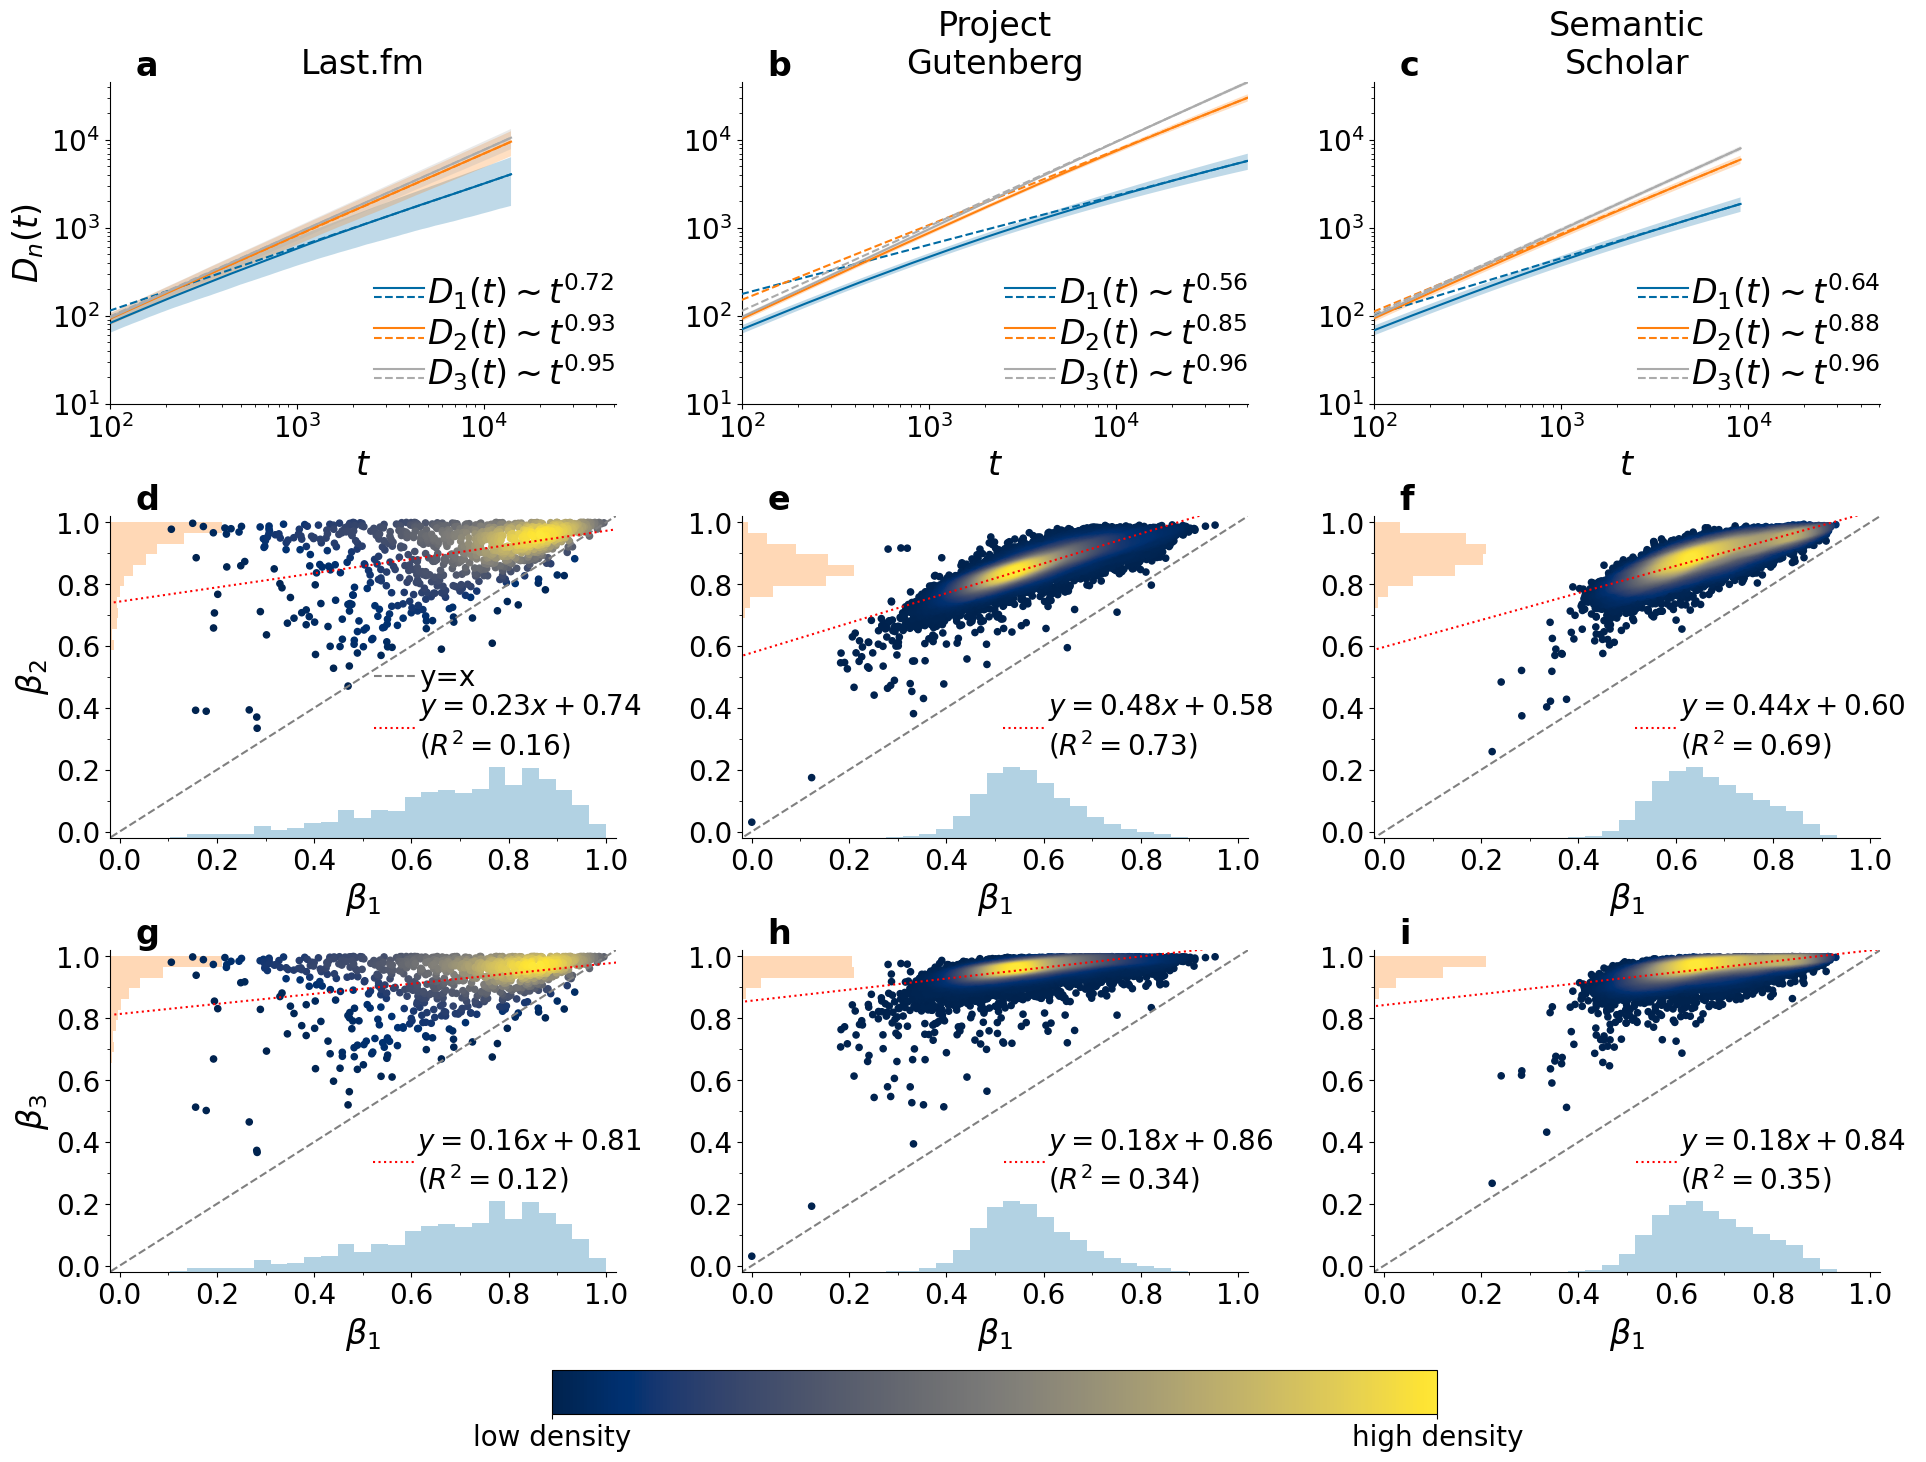

In [848]:
fig = fig_1(
    data, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.23, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e1,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    x_correlation_text = 1.1, 
    y_correlation_text = .16,
    shaded_above_heaps_keyword = '_plus_std',
    shaded_below_heaps_keyword = '_minus_std',
)

fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets.png"))
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_low_res.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets.pdf"),format='pdf')

Last.fm
intercept 0.7340019494745529 slope 0.24870629450228748
p-value pearson between $\beta_1$ and $\beta_2$ 2.010878029708839e-22
intercept 0.8049509097659677 slope 0.18178314540803026
p-value pearson between $\beta_1$ and $\beta_3$ 2.650415244479148e-17
Project Gutenberg
intercept 0.5737954136821881 slope 0.49235838531852916
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8566073031994715 slope 0.18236383149830565
p-value pearson between $\beta_1$ and None 0.0
Semantic Scholar
intercept 0.5961371753459694 slope 0.438731880282922
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8425668856577394 slope 0.17777150891704835
p-value pearson between $\beta_1$ and None 0.0


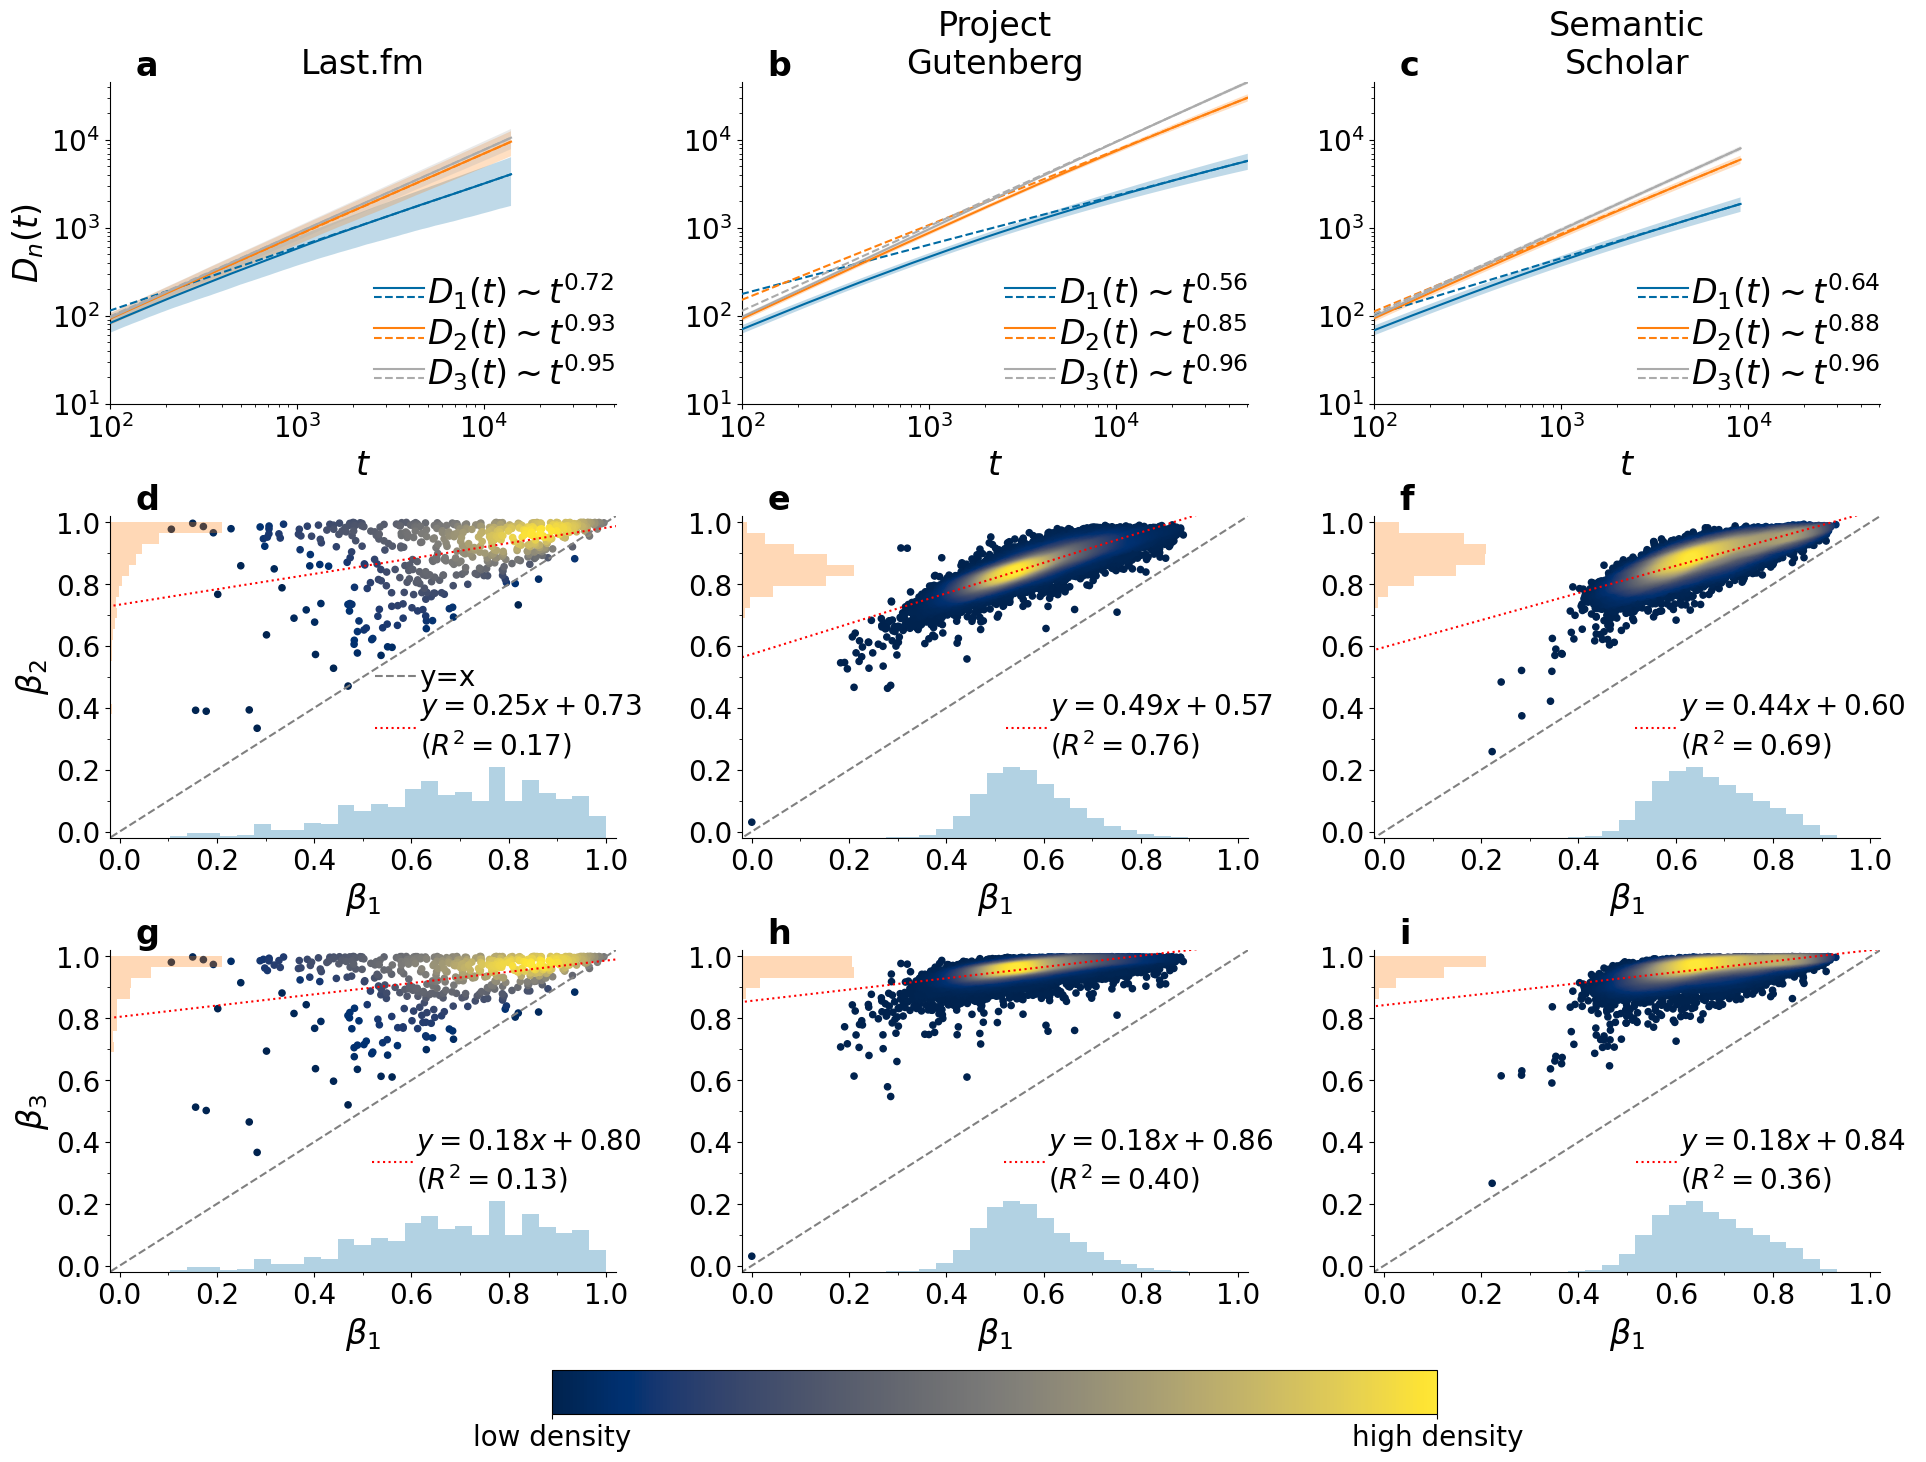

In [215]:
fig = fig_1(
    data_small_error, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.23, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e1,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    x_correlation_text = 1.1, 
    y_correlation_text = .16,
    shaded_above_heaps_keyword = '_plus_std',
    shaded_below_heaps_keyword = '_minus_std',
)

fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_small_error.png"))
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_low_res_small_error.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_small_error.pdf"),format='pdf')

Last.fm
intercept 0.7513211936718324 slope 0.2203918479731461
p-value pearson between $\beta_1$ and $\beta_2$ 7.512233153130907e-34
intercept 0.8226384888987556 slope 0.15278066320678765
p-value pearson between $\beta_1$ and $\beta_3$ 5.2436717444834376e-23
Project Gutenberg
intercept 0.5781727155168925 slope 0.48168919542992306
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8569250194544151 slope 0.17902985424763862
p-value pearson between $\beta_1$ and None 0.0
Semantic Scholar
intercept 0.5967562686934872 slope 0.43732164050187083
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8426691688157989 slope 0.1770974697934034
p-value pearson between $\beta_1$ and None 0.0


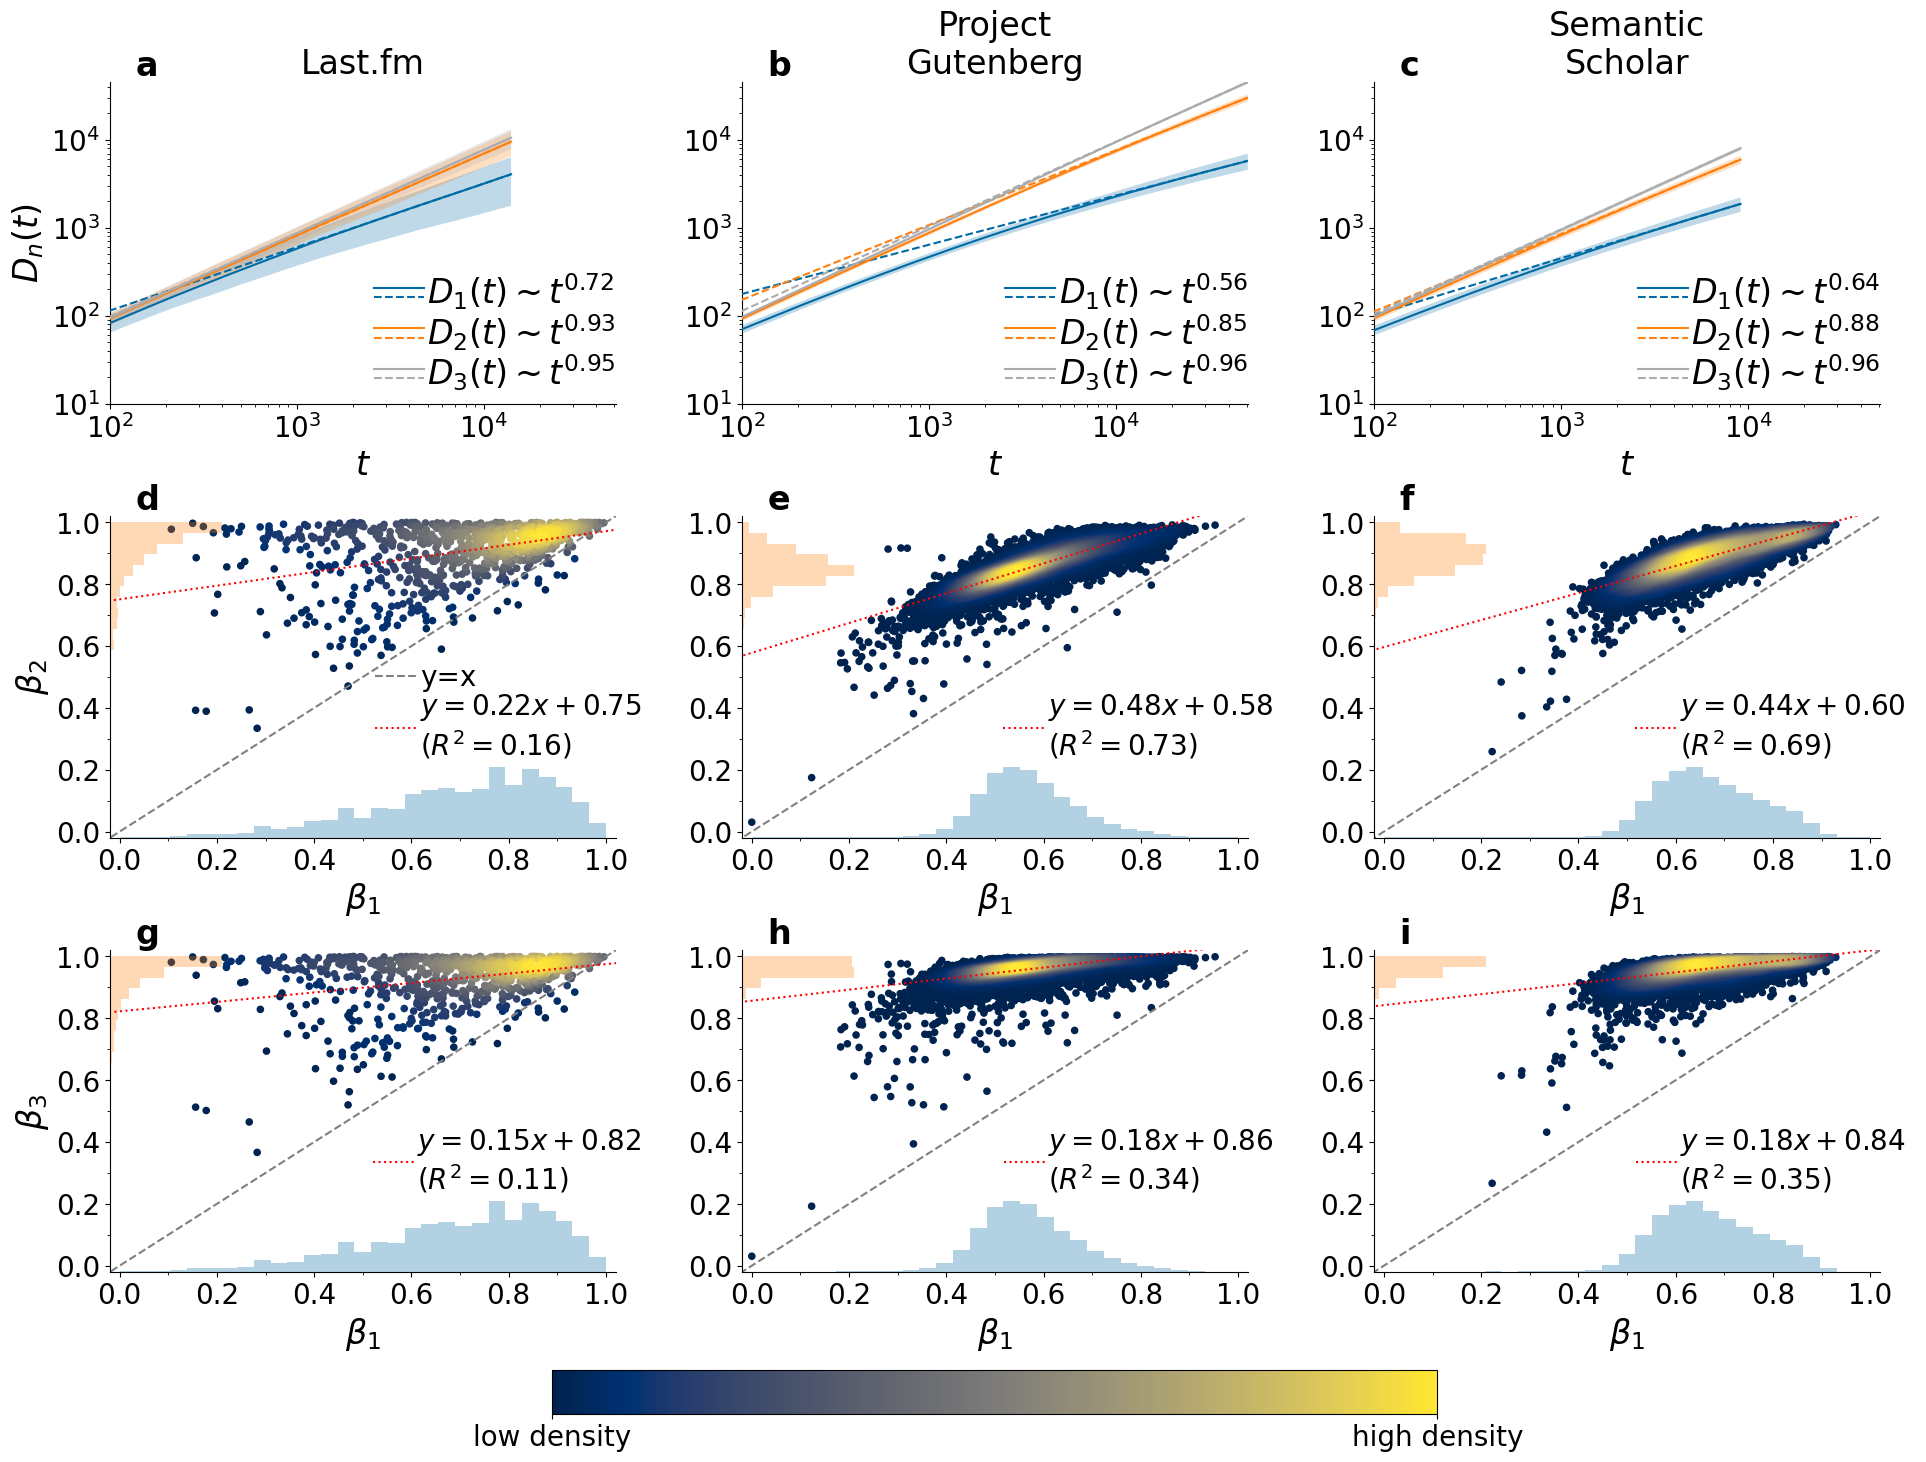

In [569]:
fig = fig_1(
    data_small_error, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.23, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e1,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    x_correlation_text = 1.1, 
    y_correlation_text = .16,
    shaded_above_heaps_keyword = '_plus_std',
    shaded_below_heaps_keyword = '_minus_std',
)

fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_small_error_05.png"))
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_low_res_small_error_05.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig1_Heaps_datasets_small_error_05.pdf"),format='pdf')

### Understand points below diagonal

In [289]:
dataset_label = 'Last.fm'
results_dataset = results_light[dataset_label] # data_small_error[dataset_label]
problematic_IDs = []
for ID, result in results_dataset.items():
    if result['std_err_beta_loglogregr_indices_geom'][-1] < 0.01 and result['beta_loglogregr_indices_geom'][-1] > result['beta3_loglogregr_indices_geom'][-1] + 0.01:
#     if result['std_err_beta_loglogregr_indices_geom'][-1] > 0.15:
        problematic_IDs.append(ID)
problematic_IDs

['./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/user_000079_light.pkl',
 './data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/user_000735_light.pkl']

In [294]:
dataset_label = 'Last.fm'
results_dataset = results_light[dataset_label] # data_small_error[dataset_label]
problematic_IDs = []
for ID, result in results_dataset.items():
    if result['std_err_beta_loglogregr_indices_geom'][-1] < 0.01 and result['beta_loglogregr_indices_geom'][-1] > result['beta2_loglogregr_indices_geom'][-1] + 0.05:
#     if result['std_err_beta_loglogregr_indices_geom'][-1] > 0.15:
        problematic_IDs.append(ID)
problematic_IDs

['./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/user_000735_light.pkl',
 './data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/user_000893_light.pkl']

In [300]:
with open('./data/ocelma-dataset/lastfm-dataset-1K/user_000893.pkl', "rb") as fp:
    result = pickle.load(fp)
result.keys()

dict_keys(['D', 'D2', 'D3', 'D4', 'ts', 'indices', 'ts_geom', 'indices_geom', 'D_indices', 'D2_indices', 'D3_indices', 'D4_indices', 'sequence', 'sequence_labels', 'dict_freq_list_entropies', 'dict_freq_list_entropies_glob', 'dict_freq_list_entropies_pairs', 'dict_freq_list_entropies_glob_pairs', 'weighted_diff_entropies', 'entropies_sorted_keys', 'entropies_sorted_weights', 'mean_entropies', 'mean_entropies_glob', 'weighted_diff_entropies_pairs', 'entropies_sorted_keys_pairs', 'entropies_sorted_weights_pairs', 'mean_entropies_pairs', 'mean_entropies_glob_pairs', 'beta_mean_indices', 'beta2_mean_indices', 'beta3_mean_indices', 'beta4_mean_indices', 'beta_loglogregr_indices_geom', 'beta2_loglogregr_indices_geom', 'beta3_loglogregr_indices_geom', 'beta4_loglogregr_indices_geom', 'intercept_loglogregr_indices_geom', 'intercept2_loglogregr_indices_geom', 'intercept3_loglogregr_indices_geom', 'intercept4_loglogregr_indices_geom', 'std_err_beta_loglogregr_indices_geom', 'std_err_beta2_loglog

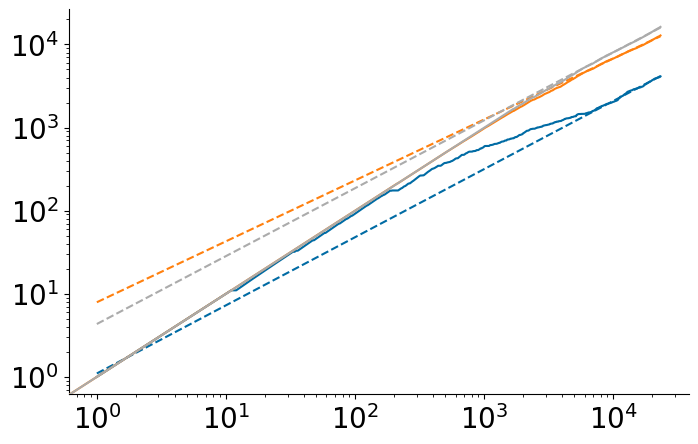

In [303]:
fig,ax = plt.subplots(figsize=(8,5))
for i,order in enumerate(['', '2', '3']): # , '4'
    ax.plot(result["ts"]-i, result[f"D{order}_indices"], color = CB_color_cycle[i], zorder = 200+i,)
    intercept = result[f"intercept{order}_loglogregr_indices_geom"][-1]
    ax.plot(result["ts"], intercept * result["ts"]**result[f"beta{order}_loglogregr_indices_geom"][-1], 
            color = CB_color_cycle[i], ls = "--")
ax.set_xscale('log')
ax.set_yscale('log')

<AxesSubplot:>

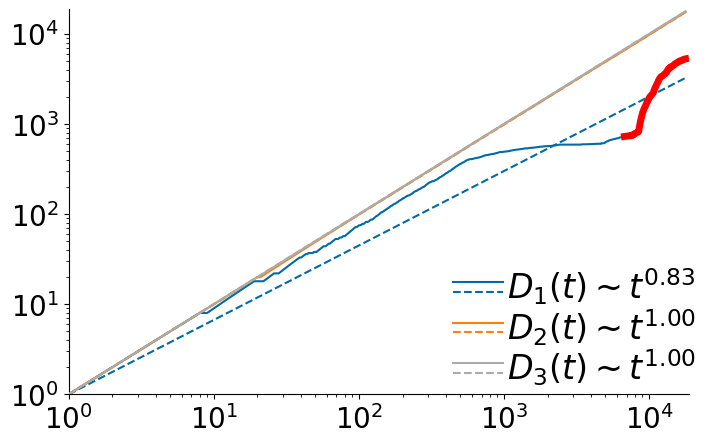

In [260]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[1]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
ax.plot(result["ts"][result['indices_geom'][-100:]], result[f"D_indices"][result['indices_geom'][-100:]], color = 'red', lw=5, zorder = 2900+i,)
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)


0.19876819523314604


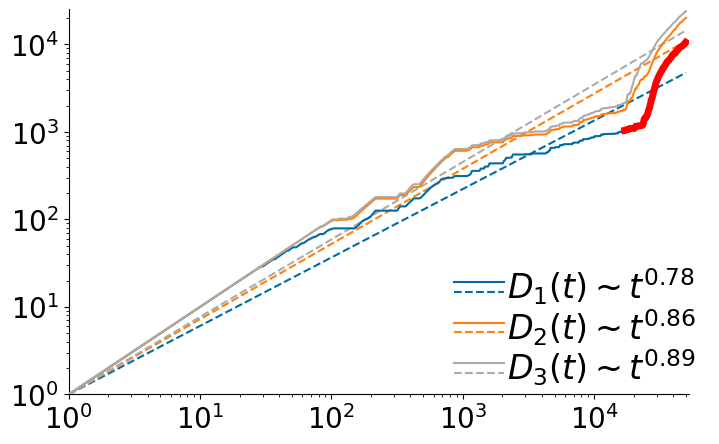

In [263]:
fig, ax  = plt.subplots(figsize=(8,5))
print(problematic_IDs[0])
result = results_dataset[problematic_IDs[0]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
ax.plot(result["ts"][result['indices_geom'][-100:]], result[f"D_indices"][result['indices_geom'][-100:]], color = 'red', lw=5, zorder = 2900+i,)
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)
print(result['std_err_beta_loglogregr_indices_geom'][-1])

0.009568954080357732 0.006939950577356568


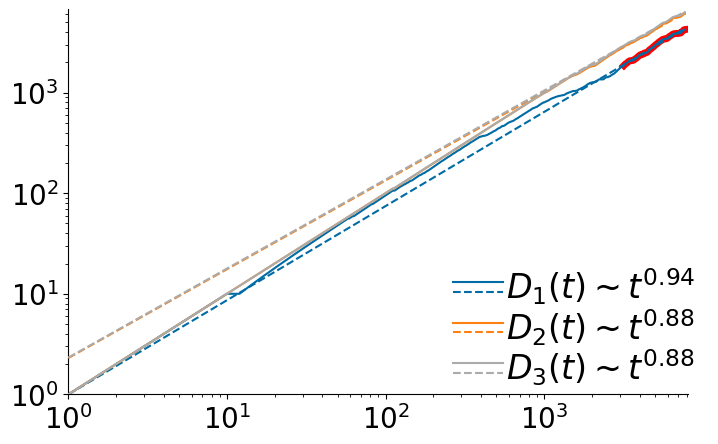

In [277]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[0]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
ax.plot(result["ts"][result['indices_geom'][-100:]], result[f"D_indices"][result['indices_geom'][-100:]], color = 'red', lw=5, zorder = 0,)
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)
print(result['std_err_beta_loglogregr_indices_geom'][-1], result['std_err_beta2_loglogregr_indices_geom'][-1])

0.006895099618172243 0.003153893869926945


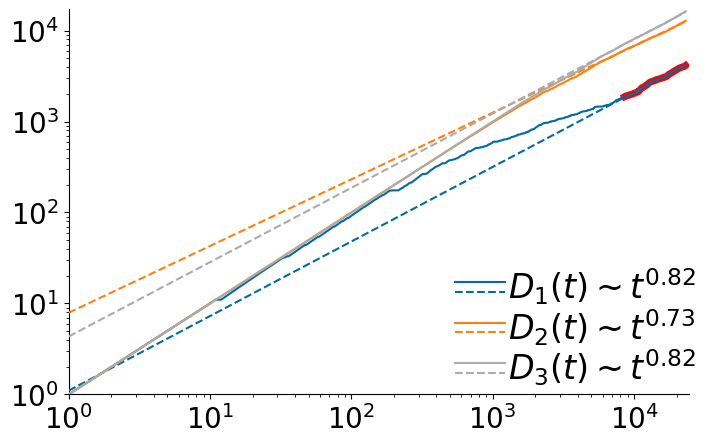

In [276]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[1]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
ax.plot(result["ts"][result['indices_geom'][-100:]], result[f"D_indices"][result['indices_geom'][-100:]], color = 'red', lw=5, zorder = 0,)
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)
print(result['std_err_beta_loglogregr_indices_geom'][-1], result['std_err_beta2_loglogregr_indices_geom'][-1])

0.004710512249571267 0.0031918907417902613


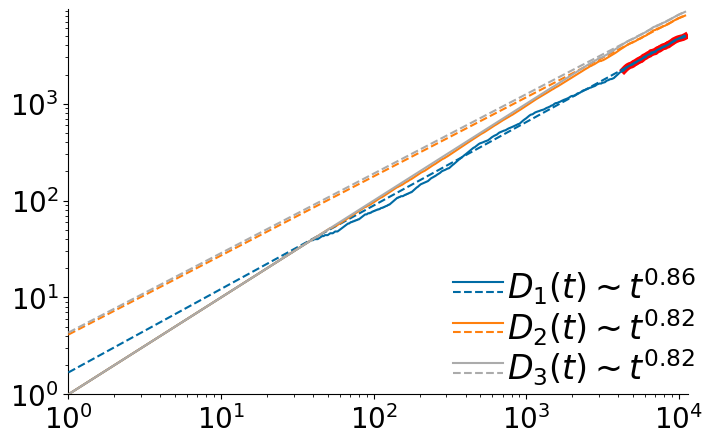

In [293]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[0]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
ax.plot(result["ts"][result['indices_geom'][-100:]], result[f"D_indices"][result['indices_geom'][-100:]], color = 'red', lw=5, zorder = 0,)
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)
print(result['std_err_beta_loglogregr_indices_geom'][-1], result['std_err_beta2_loglogregr_indices_geom'][-1])

<AxesSubplot:>

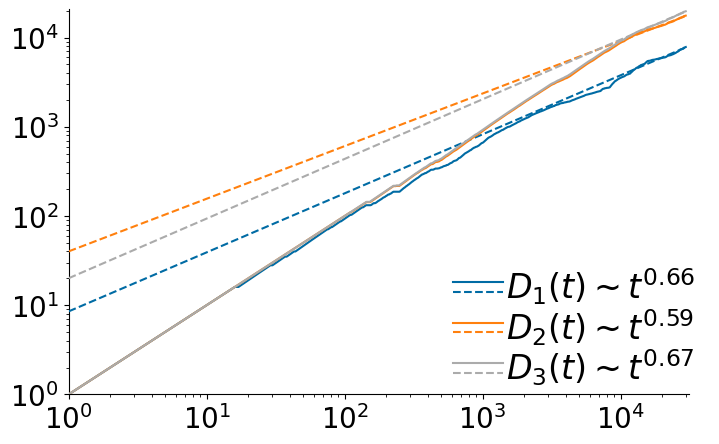

In [232]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[1]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)

<AxesSubplot:>

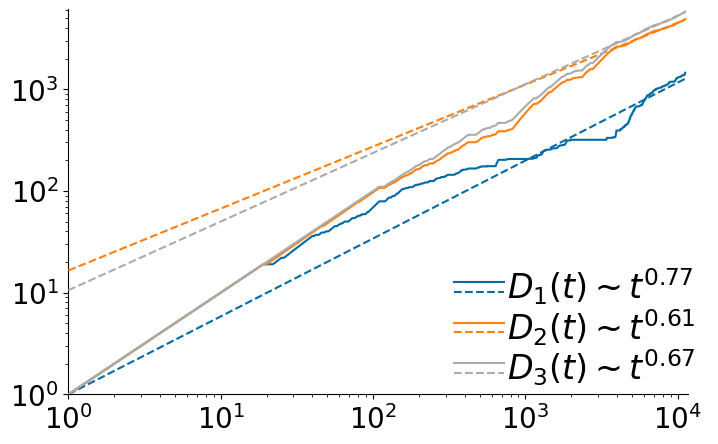

In [236]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[4]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)

<AxesSubplot:>

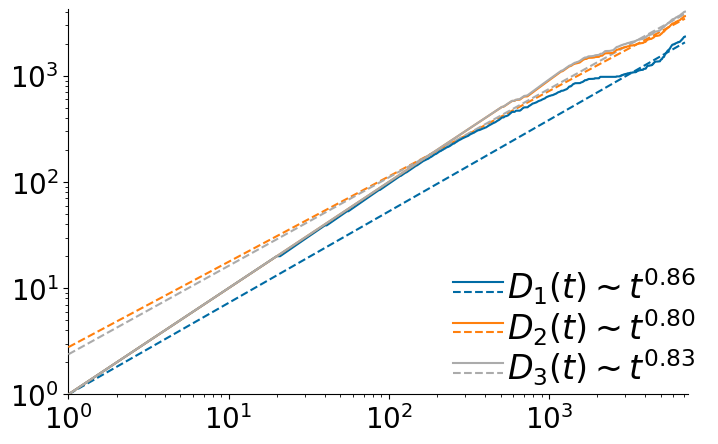

In [246]:
fig, ax  = plt.subplots(figsize=(8,5))
result = results_dataset[problematic_IDs[14]].copy()
result['beta'] = result['beta_loglogregr_indices_geom'].copy()
result['beta2'] = result['beta2_loglogregr_indices_geom'].copy()
result['beta3'] = result['beta3_loglogregr_indices_geom'].copy()
result['intercept'] = result['intercept_loglogregr_indices_geom'].copy()
result['intercept2'] = result['intercept2_loglogregr_indices_geom'].copy()
result['intercept3'] = result['intercept3_loglogregr_indices_geom'].copy()
subplot_heaps_law(result, shaded_above_heaps_keyword = None, ax = ax)

## Figure for abstract

In [356]:
def fig_1_for_abstract(data, marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, xlim_left_a = 1, ylim_bottom_a = 1,
          min_beta = None,
          max_beta = None,
          min_beta_higher = None,
          max_beta_higher = None,
          use_same_x_y_max_lim = True,
          do_dashed_line = True,
        x_correlation_text = 0.63, 
        y_correlation_text = .32,
         ):
    higher_orders = [2,3]
    nrows = 1
    ncols = num_datasets = len(data)
    fig = plt.figure(figsize=(width_fig*ncols/3,width_fig*9/10*nrows/3))
#     outer = gridspec.GridSpec(nrows=num_datasets+1, ncols=1,height_ratios = [10]*num_datasets+[3],hspace=0.35) # 0.25
    outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10*nrows]+[3], hspace=0.45, wspace=0.15) # 0.25
    
    
    wspace = 0.25
    hspace = 0.35
    
    # get highest t and D to unify panel a
    if use_same_x_y_max_lim == True:
        max_t = 1
        max_D = 1
        for dataset_label, dataset_dict in data.items():
            max_t = max(max_t, dataset_dict['average_results']["ts"][-1]+1)
            for order in ['', '2', '3']: #  '4'
                max_D = max(max_D, dataset_dict['average_results'][f"D{order}_indices"][-1]+1)
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                        subplot_spec=outer[0],wspace=wspace,hspace=hspace)
                
    for column, (dataset_label, dataset_dict) in enumerate(data.items()):
        print(dataset_label)
        ax = plt.Subplot(fig, inner[column])
        xlabel_scatter_beta = r"$\beta_1$"
        order = 2
        ylabel_scatter_beta = fr"$\beta_{order}$" if column == 0 else None
        subplot_scatter_beta(dataset_dict['betas'], dataset_dict[f'betas{order}'], 
                          ax = ax, 
                          marker_size = 20, alpha_scatter = alpha_scatter,
                          alpha_histogram = alpha_histogram, 
                          color_x = color_x, color_y = color_y, 
                          max_hist = max_hist, 
                          number_to_write = column, 
                          write_number = True, #i==0, 
                          do_dashed_line = do_dashed_line,
                          ylabel = ylabel_scatter_beta, xlabel = xlabel_scatter_beta, 
                          min_x=min_beta, max_x=max_beta, min_y=min_beta_higher, max_y=max_beta_higher,
                          x_correlation_text = x_correlation_text, 
                          y_correlation_text = y_correlation_text,
                         )
        ax.set_title('\n'.join(dataset_label.split(' ')))
        fig.add_subplot(ax)
    
    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

Last.fm
p-value pearson between $\beta_1$ and $\beta_2$ 1.428738990674999e-36
Project Gutenberg
p-value pearson between $\beta_1$ and None 0.0
Semantic Scholar
p-value pearson between $\beta_1$ and None 0.0


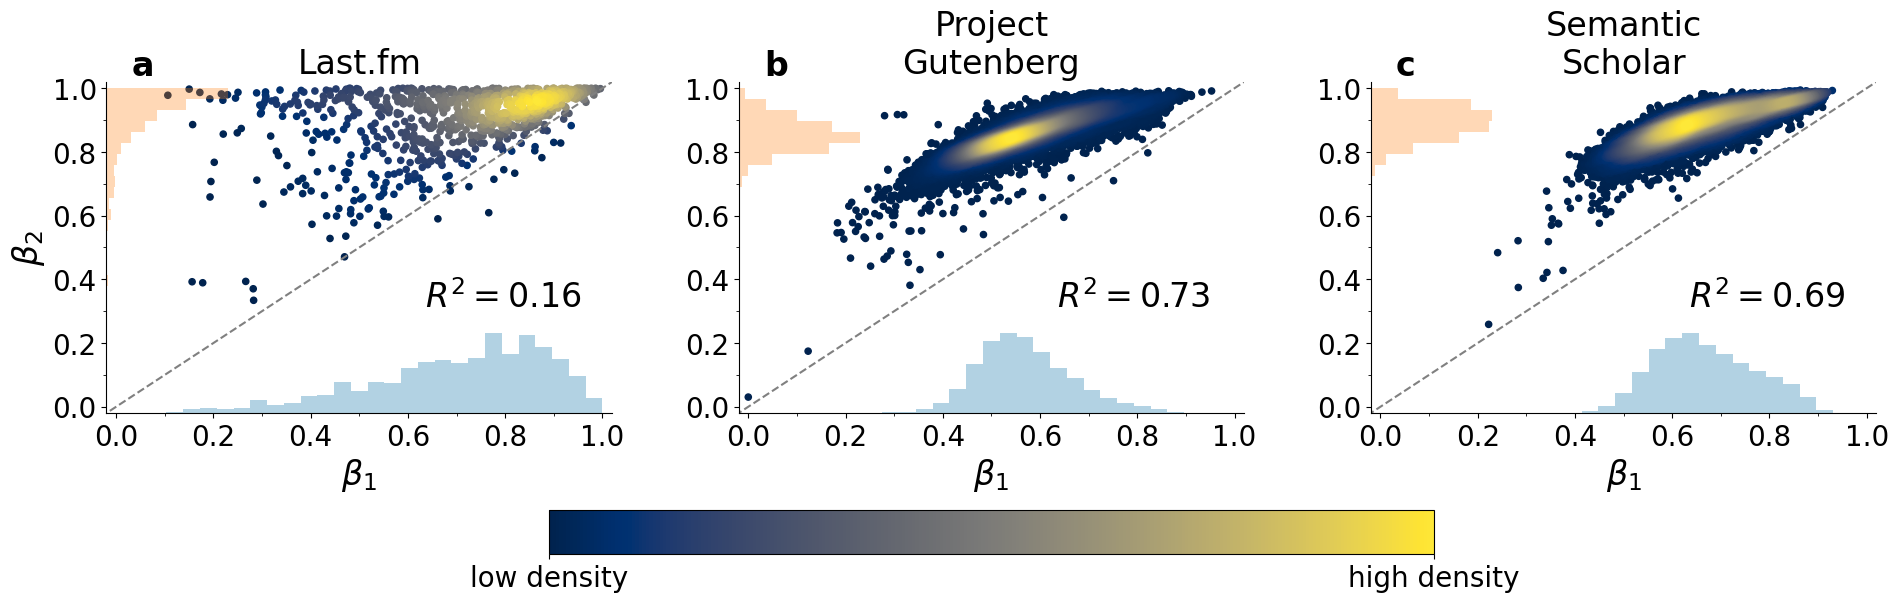

In [358]:
fig = fig_1_for_abstract(
    data, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.25, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e1,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
)

fig.savefig(os.path.join(figures_folder, f"Fig_abstract_Heaps_datasets.png"))
fig.savefig(os.path.join(figures_folder, f"Fig_abstract_Heaps_datasets_low_res.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig_abstract_Heaps_datasets.pdf"),format='pdf')

## Table SI: info heaps exponents

In [63]:
data_to_table = {
    'datasets' : [],
    'mean_beta' : [], 
    'std_beta' : [], 
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['mean_beta'].append(np.mean(dataset_dict[f'betas{order}']))
        data_to_table['std_beta'].append(np.std(dataset_dict[f'betas{order}']))
        data_to_table['min_betas'].append(np.min(dataset_dict[f'betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f'betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f'betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f'betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f'betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f'betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f'betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"mean" : data_to_table['mean_beta'],
    r"std" : data_to_table['std_beta'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} perc." : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} perc." : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} perc." : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} perc." : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas'],
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.4f", escape=False))

\begin{tabular}{cccccccccc}
\toprule
          Dataset ($\beta_n$) &   mean &    std &     min &  $1$\textsuperscript{st} perc. &  $25$\textsuperscript{th} perc. &  median &  $75$\textsuperscript{th} perc. &  $99$\textsuperscript{th} perc. &    max \\
\midrule
          Last.fm ($\beta_1$) & 0.7029 & 0.1797 &  0.1063 &                         0.2010 &                          0.5965 &  0.7395 &                          0.8436 &                          0.9761 & 0.9959 \\
          Last.fm ($\beta_2$) & 0.9048 & 0.1014 &  0.3342 &                         0.5725 &                          0.8699 &  0.9388 &                          0.9754 &                          0.9999 & 0.9999 \\
          Last.fm ($\beta_3$) & 0.9286 & 0.0862 &  0.3664 &                         0.6123 &                          0.9041 &  0.9583 &                          0.9861 &                          0.9999 & 1.0000 \\
          Last.fm ($\beta_4$) & 0.9411 & 0.0759 &  0.3837 &                         0.6643 &  

In [64]:
data_to_table = {
    'datasets' : [],
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['min_betas'].append(np.min(dataset_dict[f'std_err_betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f'std_err_betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f'std_err_betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} perc." : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} perc." : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} perc." : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} perc." : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas']
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.4f", escape=False))

\begin{tabular}{cccccccc}
\toprule
          Dataset ($\beta_n$) &    min &  $1$\textsuperscript{st} perc. &  $25$\textsuperscript{th} perc. &  median &  $75$\textsuperscript{th} perc. &  $99$\textsuperscript{th} perc. &    max \\
\midrule
          Last.fm ($\beta_1$) & 0.0007 &                         0.0016 &                          0.0052 &  0.0079 &                          0.0129 &                          0.0693 & 0.1988 \\
          Last.fm ($\beta_2$) & 0.0000 &                         0.0001 &                          0.0026 &  0.0047 &                          0.0091 &                          0.0510 & 0.1497 \\
          Last.fm ($\beta_3$) & 0.0000 &                         0.0000 &                          0.0019 &  0.0038 &                          0.0073 &                          0.0388 & 0.1366 \\
          Last.fm ($\beta_4$) & 0.0000 &                         0.0000 &                          0.0015 &  0.0031 &                          0.0064 &                     

### Average Heaps' exponent fits and standard error

(or standard deviation of its estimator)

For each, do min, 1st quartile, mean, 3rd quartile and max, for the last regression.

Compare with std of previous table

In [213]:
data_to_table = {
    'datasets' : [],
    'mean_value_beta' : [], 
    'std_value_beta' : [], 
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['mean_value_beta'].append(np.mean(dataset_dict[f'betas{order}']))
        data_to_table['std_value_beta'].append(np.std(dataset_dict[f'betas{order}']))
        data_to_table['min_betas'].append(np.min(dataset_dict[f'std_err_betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f'std_err_betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f'std_err_betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"mean value" : data_to_table['mean_value_beta'],
    r"std value" : data_to_table['std_value_beta'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} perc." : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} perc." : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} perc." : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} perc." : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas'],
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.4f", escape=False))

\begin{tabular}{cccccccccc}
\toprule
          Dataset ($\beta_n$) &  mean value &  std value &    min &  $1$\textsuperscript{st} perc. &  $25$\textsuperscript{th} perc. &  median &  $75$\textsuperscript{th} perc. &  $99$\textsuperscript{th} perc. &    max \\
\midrule
          Last.fm ($\beta_1$) &      0.7029 &     0.1797 & 0.0007 &                         0.0016 &                          0.0052 &  0.0079 &                          0.0129 &                          0.0693 & 0.1988 \\
          Last.fm ($\beta_2$) &      0.9048 &     0.1014 & 0.0000 &                         0.0001 &                          0.0026 &  0.0047 &                          0.0091 &                          0.0510 & 0.1497 \\
          Last.fm ($\beta_3$) &      0.9286 &     0.0862 & 0.0000 &                         0.0000 &                          0.0019 &  0.0038 &                          0.0073 &                          0.0388 & 0.1366 \\
          Last.fm ($\beta_4$) &      0.9411 &     0.0759 & 0.0

In [65]:
data_to_table = {
    'datasets' : [],
    'mean_value_beta' : [], 
    'std_value_beta' : [], 
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['mean_value_beta'].append(np.mean(dataset_dict[f'betas{order}']))
        data_to_table['std_value_beta'].append(np.std(dataset_dict[f'betas{order}']))
        data_to_table['min_betas'].append(np.min(dataset_dict[f'std_err_betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f'std_err_betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f'std_err_betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f'std_err_betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"mean value" : data_to_table['mean_value_beta'],
    r"std value" : data_to_table['std_value_beta'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} perc." : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} perc." : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} perc." : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} perc." : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas'],
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.4f", escape=False))

\begin{tabular}{cccccccccc}
\toprule
          Dataset ($\beta_n$) &  mean value &  std value &    min &  $1$\textsuperscript{st} perc. &  $25$\textsuperscript{th} perc. &  median &  $75$\textsuperscript{th} perc. &  $99$\textsuperscript{th} perc. &    max \\
\midrule
          Last.fm ($\beta_1$) &      0.7029 &     0.1797 & 0.0007 &                         0.0016 &                          0.0052 &  0.0079 &                          0.0129 &                          0.0693 & 0.1988 \\
          Last.fm ($\beta_2$) &      0.9048 &     0.1014 & 0.0000 &                         0.0001 &                          0.0026 &  0.0047 &                          0.0091 &                          0.0510 & 0.1497 \\
          Last.fm ($\beta_3$) &      0.9286 &     0.0862 & 0.0000 &                         0.0000 &                          0.0019 &  0.0038 &                          0.0073 &                          0.0388 & 0.1366 \\
          Last.fm ($\beta_4$) &      0.9411 &     0.0759 & 0.0

### Repeat for t-values and p-values (safety check)

In [66]:
data_to_table = {
    'datasets' : [],
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['min_betas'].append(np.min(dataset_dict[f't_values_betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f't_values_betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f't_values_betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f't_values_betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f't_values_betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f't_values_betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f't_values_betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} percentile" : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} percentile" : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} percentile" : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} percentile" : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas']
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.12f", escape=False))

\begin{tabular}{cccccccc}
\toprule
          Dataset ($\beta_n$) &             min &  $1$\textsuperscript{st} percentile &  $25$\textsuperscript{th} percentile &            median &  $75$\textsuperscript{th} percentile &  $99$\textsuperscript{th} percentile &                             max \\
\midrule
          Last.fm ($\beta_1$) &  5.326220648471 &                     19.313237622896 &                      69.078834646016 &  116.179885496063 &                     278.816724995955 &                    6446.215071571602 &              25460.161078702229 \\
          Last.fm ($\beta_2$) &  6.524946234118 &                     44.867339773862 &                     176.688264084273 &  478.168878113243 &                    2601.230651784433 &                   74428.846836042198 &             312359.616596910288 \\
          Last.fm ($\beta_3$) &  7.519964675021 &                     40.161934913262 &                     220.861246125754 &  604.919937700397 &                    3415.49879

In [67]:
data_to_table = {
    'datasets' : [],
    'min_betas' : [],
    'first_percentile_betas' : [],
    'first_quartile_betas' : [],
    'median_betas' : [],
    'third_quartile_betas' : [],
    'last_percentile_betas' : [],
    'max_betas' : [],
}

for dataset_label, dataset_dict in data.items():
    for i,order in enumerate(['', '2', '3', '4']):
        i += 1
        data_to_table['datasets'].append(fr"{dataset_label} ($\beta_{i}$)")
        data_to_table['min_betas'].append(np.min(dataset_dict[f'p_values_betas{order}']))
        data_to_table['first_percentile_betas'].append(np.percentile(dataset_dict[f'p_values_betas{order}'], 1))
        data_to_table['first_quartile_betas'].append(np.percentile(dataset_dict[f'p_values_betas{order}'], 25))
        data_to_table['median_betas'].append(np.median(dataset_dict[f'p_values_betas{order}']))
        data_to_table['third_quartile_betas'].append(np.percentile(dataset_dict[f'p_values_betas{order}'], 75))
        data_to_table['last_percentile_betas'].append(np.percentile(dataset_dict[f'p_values_betas{order}'], 99))
        data_to_table['max_betas'].append(np.max(dataset_dict[f'p_values_betas{order}']))

df = pd.DataFrame(data = {
    r'Dataset ($\beta_n$)' : data_to_table['datasets'],
    r"min" : data_to_table['min_betas'],
    r"$1$\textsuperscript{st} percentile" : data_to_table['first_percentile_betas'],
    r"$25$\textsuperscript{th} percentile" : data_to_table['first_quartile_betas'],
    r"median" : data_to_table['median_betas'],
    r"$75$\textsuperscript{th} percentile" : data_to_table['third_quartile_betas'],
    r"$99$\textsuperscript{th} percentile" : data_to_table['last_percentile_betas'],
    r"max" : data_to_table['max_betas']
})
print(df.to_latex(index=False, column_format='c'*len(df.columns), float_format="%.12f", escape=False))

\begin{tabular}{cccccccc}
\toprule
          Dataset ($\beta_n$) &            min &  $1$\textsuperscript{st} percentile &  $25$\textsuperscript{th} percentile &         median &  $75$\textsuperscript{th} percentile &  $99$\textsuperscript{th} percentile &            max \\
\midrule
          Last.fm ($\beta_1$) & 0.000000000000 &                      0.000000000000 &                       0.000000000000 & 0.000000000000 &                       0.000000000000 &                       0.000000000000 & 0.000000638950 \\
          Last.fm ($\beta_2$) & 0.000000000000 &                      0.000000000000 &                       0.000000000000 & 0.000000000000 &                       0.000000000000 &                       0.000000000000 & 0.000000003004 \\
          Last.fm ($\beta_3$) & 0.000000000000 &                      0.000000000000 &                       0.000000000000 & 0.000000000000 &                       0.000000000000 &                       0.000000000000 & 0.000000000026 \\


## Figure SI: Distribution lengths

Last.fm	median:	13985.0
Project Gutenberg	median:	50726.0
Semantic Scholar	median:	9114.5


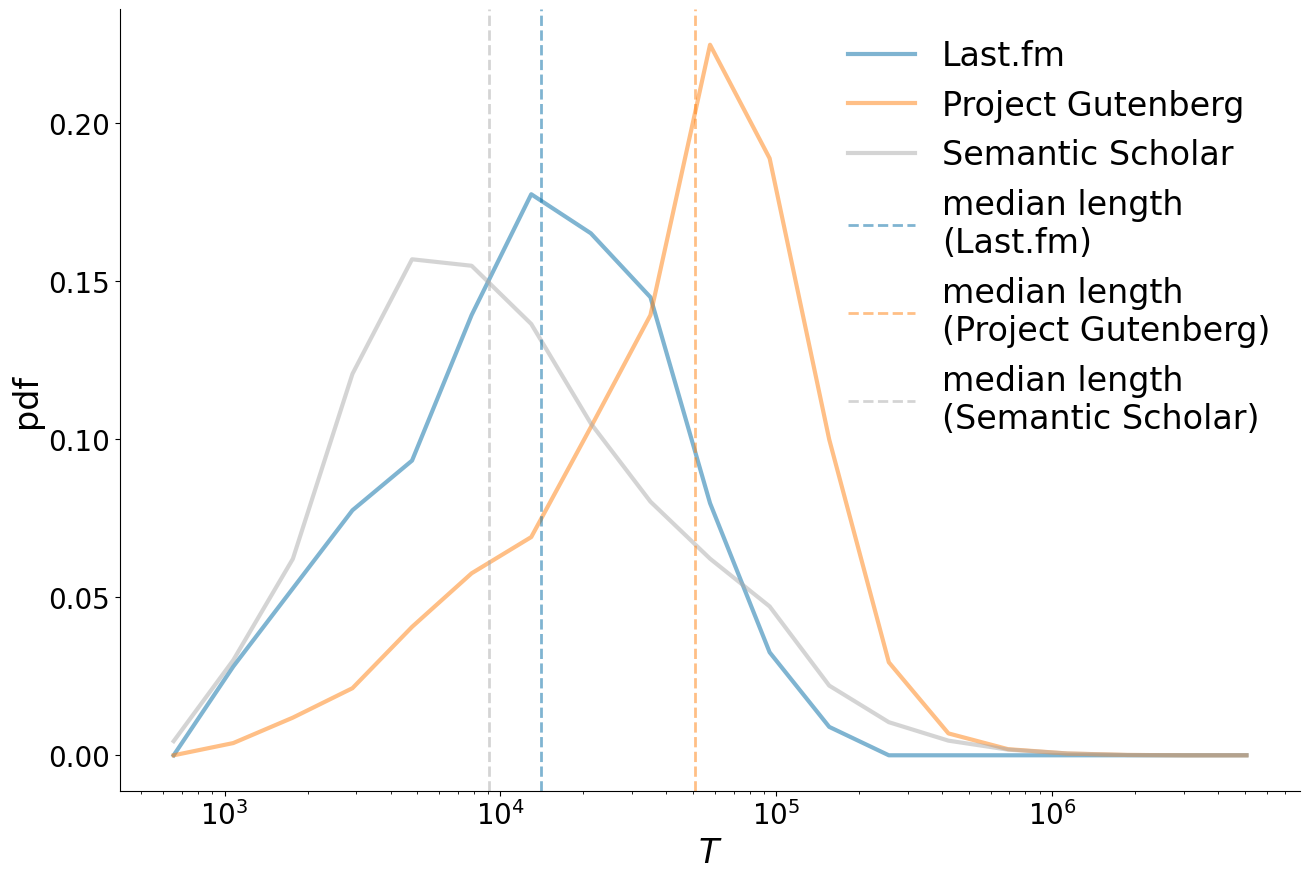

In [14]:
fig = plt.figure(figsize=(width_fig*2/3,width_fig*2/3*2/3))
ax = plt.gca()
minimum = min([min(dataset_dict['len']) for dataset_dict in data.values()])
maximum = max([max(dataset_dict['len']) for dataset_dict in data.values()])
num_bins = 20
colors = []
for dataset_label, dataset_dict in data.items():
    len_data = dataset_dict['len']
    hist,bin_edges = np.histogram(len_data, 
            np.geomspace(minimum, maximum+1, num_bins), 
            density=False)
    bin_centers = 10**((np.log10(bin_edges[1:])+np.log10(bin_edges[:-1]))/2)
    total = len(len_data)
    p = ax.plot(bin_centers, hist/total, label=dataset_label,alpha=0.5,lw=3)
    colors.append(p[0].get_color())

# ax.set_prop_cycle(None)
for i, (dataset_label, dataset_dict) in enumerate(data.items()):
    len_data = dataset_dict['len']
    ax.axvline(np.median(len_data), color=colors[i], ls= '--', lw=2, alpha=0.5, label='median length\n('+ dataset_label + ')')
    print(dataset_label, "median:", np.median(len_data), sep="\t")

ax.legend()
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"pdf")
ax.set_xscale("log")

fig.savefig(os.path.join(figures_folder, f"FigSI_distribution_length_datasets.png"))
fig.savefig(os.path.join(figures_folder, f"FigSI_distribution_length_datasets.pdf"),format='pdf')

## Figure SI: Heaps on seq. of labels

In [16]:
min_beta_labels = min([min(_['betas']) for _ in data_labels.values()])
max_beta_labels = max([max(_['betas']) for _ in data_labels.values()])

min_beta_higher_labels = min([min(list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])
max_beta_higher_labels = max([max(list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])

min_beta_labels, max_beta_labels, min_beta_higher_labels, max_beta_higher_labels

(-1.3748081562070524e-09,
 0.9503719989766061,
 0.03043417692512353,
 0.9999537137863118)

In [17]:
min_beta_labels = min_beta_higher_labels = min(min_beta_labels, min_beta_higher_labels)
max_beta_labels = max_beta_higher_labels = max(max_beta_labels, max_beta_higher_labels)

Last.fm
intercept 0.58853743263606 slope 0.4062661105722397
p-value pearson between $\beta_1$ and $\beta_2$ 2.9805432465304643e-62
intercept 0.7360318251630289 slope 0.23871644147567686
p-value pearson between $\beta_1$ and $\beta_3$ 9.896115505091258e-26
Project Gutenberg
intercept 0.6144372992260767 slope 0.4458778293726334
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8821936864199273 slope 0.14688876979961135
p-value pearson between $\beta_1$ and None 0.0
Semantic Scholar
intercept 0.617626215672674 slope 0.41503803957251006
p-value pearson between $\beta_1$ and None 0.0
intercept 0.8581711825611271 slope 0.15885804939574077
p-value pearson between $\beta_1$ and None 0.0


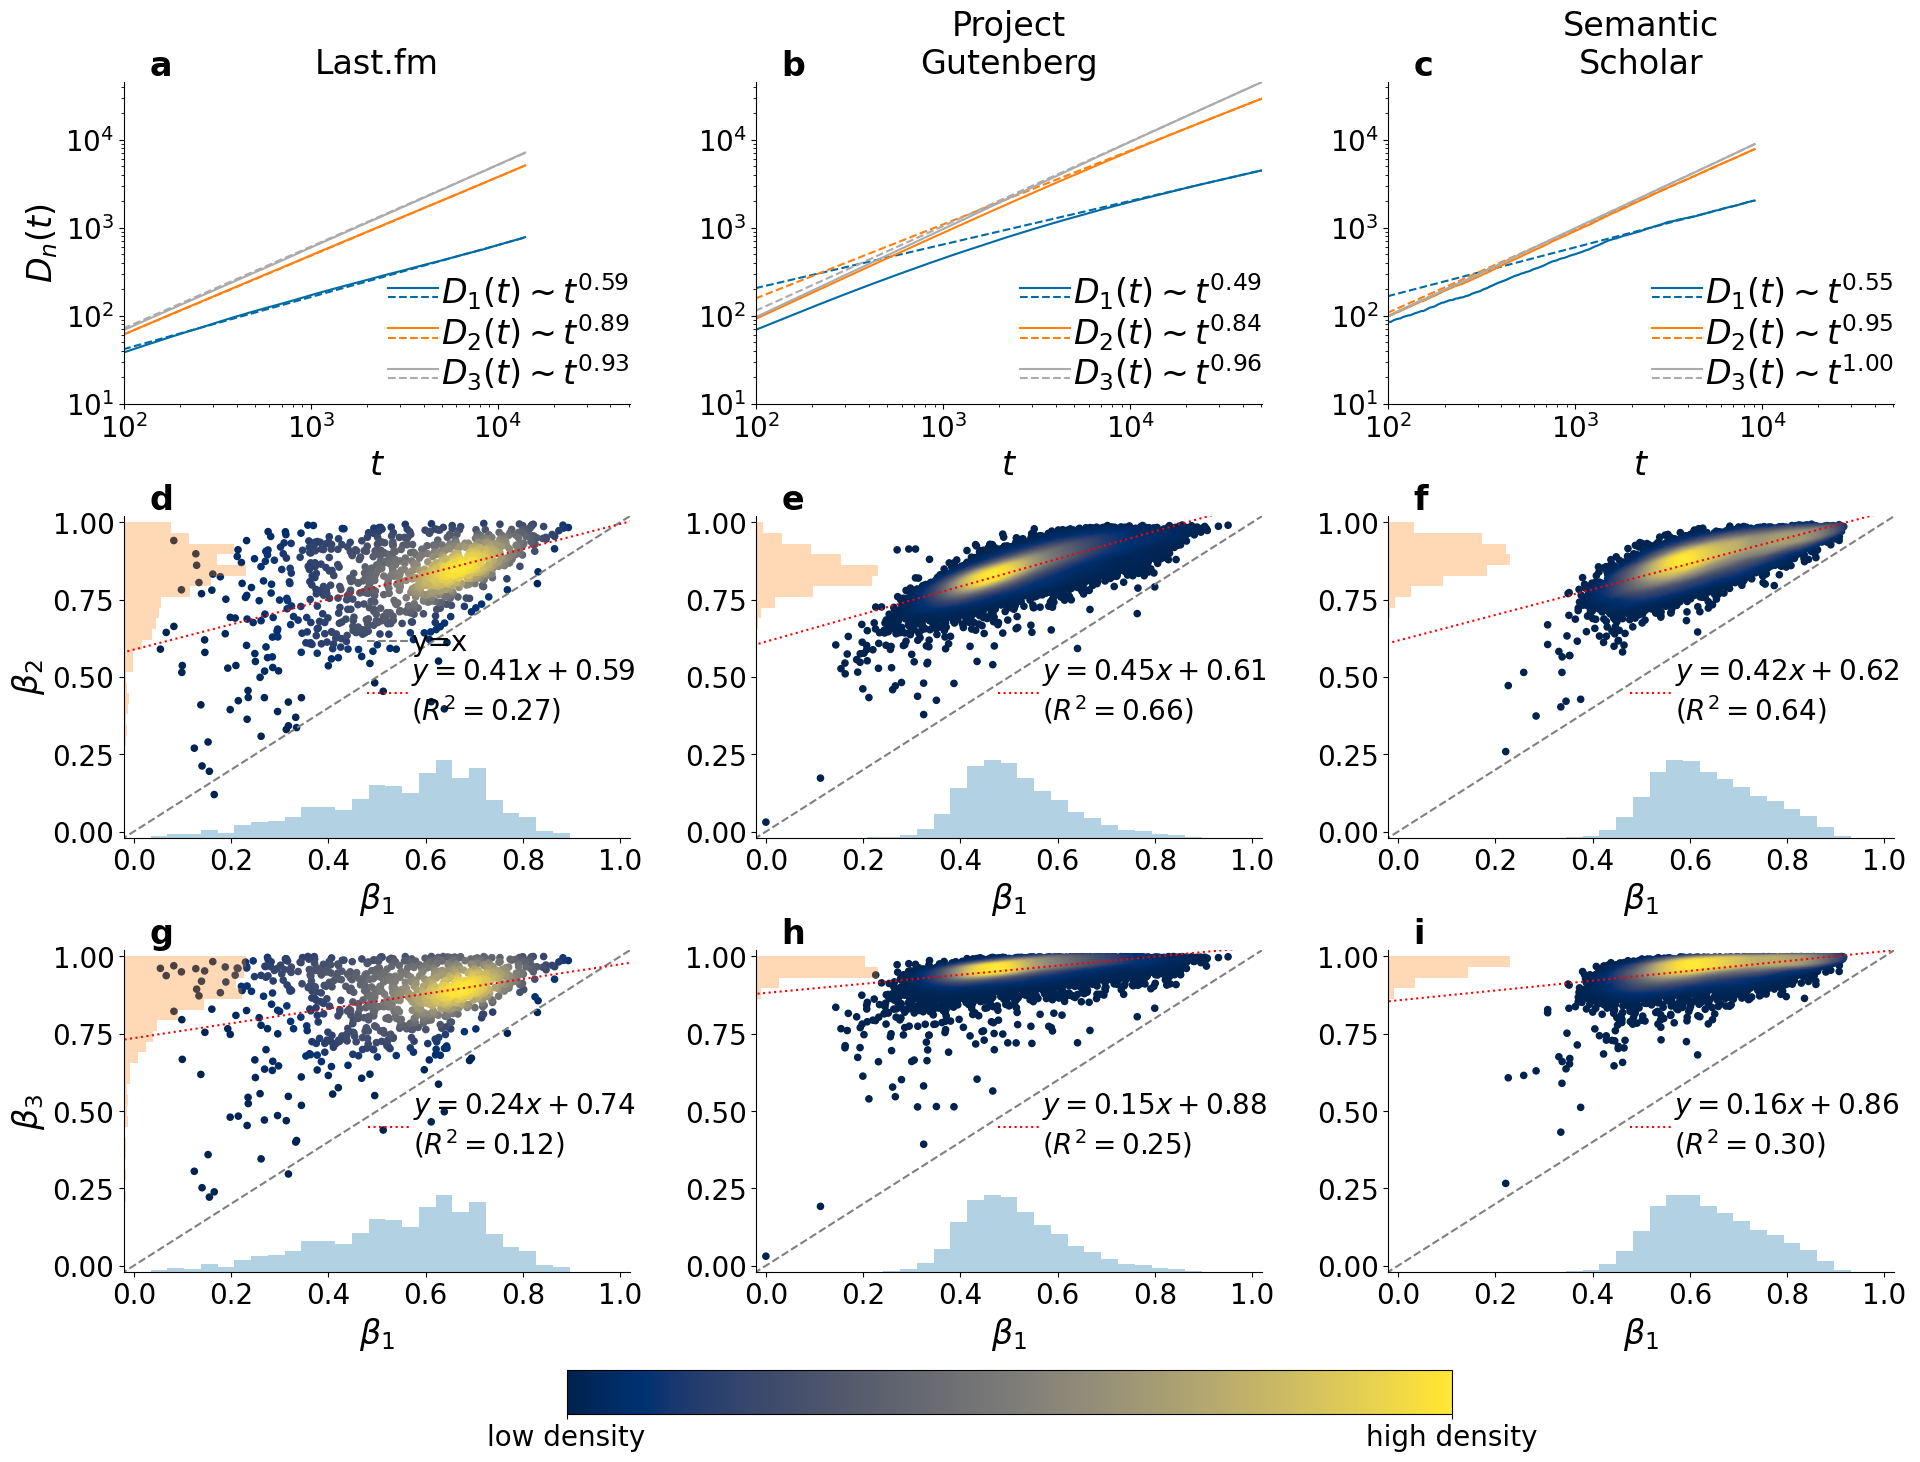

In [18]:
fig = fig_1(
    data_labels, 
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.25, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e1,
    min_beta = min_beta_labels,
    max_beta = max_beta_labels,
    min_beta_higher = min_beta_higher_labels,
    max_beta_higher = max_beta_higher_labels,
)

fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_datasets_labels.png"))
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_datasets_labels_low_res.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_datasets_labels.pdf"),format='pdf')

## Figure SI: Distribution of exponents compared

In [19]:
data.keys()

dict_keys(['Last.fm', 'Project Gutenberg', 'Semantic Scholar'])

In [20]:
minimum_1 = min([min(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])
maximum_1 = max([max(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])
minimum_1, maximum_1

(-1.3748081562070524e-09, 0.9999537137863118)

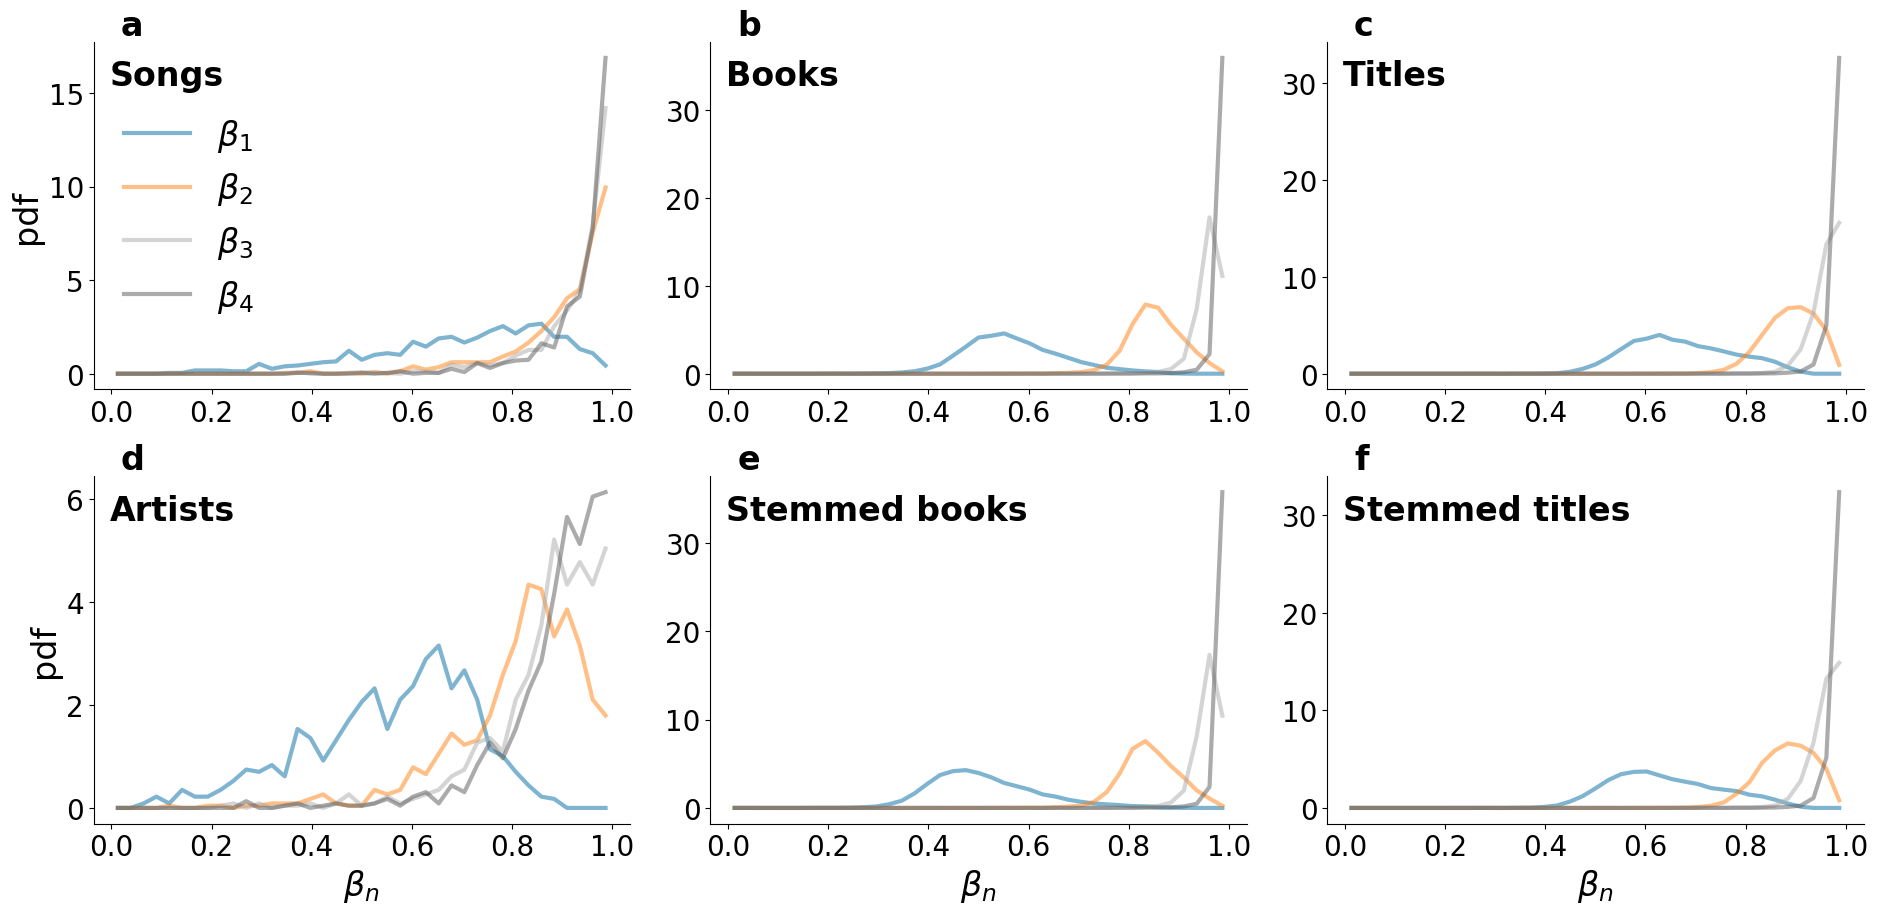

In [26]:
num_datasets = len(data)
write_number = True
fig = plt.figure(figsize=(width_fig*num_datasets/3,width_fig*2/3*2/3))
outer = gridspec.GridSpec(nrows=2, ncols=num_datasets,width_ratios = [10]*num_datasets, hspace=0.25, wspace=0.15)

minimum_0 = min([min(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data.values()])
maximum_0 = max([max(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data.values()])
minimum_1 = min([min(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])
maximum_1 = max([max(list(_['betas']) + list(_['betas2']) + list(_['betas3']) + list(_['betas4'])) for _ in data_labels.values()])
minimum = min([minimum_0,minimum_1])
maximum = max([maximum_0,maximum_1])
num_bins = 40
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'.lower()
number_to_write = -1

first_row_labels = {'Last.fm': 'Songs', 'Project Gutenberg': 'Books', 'Semantic Scholar': 'Titles'}
second_row_labels = {'Last.fm': 'Artists', 'Project Gutenberg': 'Stemmed books', 'Semantic Scholar': 'Stemmed titles'}
for i, (dataset_label, dataset_dict) in enumerate(data.items()):
    colors = []
    legend_labels = []
    ax = plt.Subplot(fig, outer[0,i])
    for order,key in enumerate(['betas', 'betas2', 'betas3', 'betas4']):
        data_to_hist = dataset_dict[key]
        hist,bin_edges = np.histogram(data_to_hist, 
                np.linspace(minimum, maximum, num_bins), 
                density=True)
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
        p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = r"$\beta_%d$"%(order+1))
    ax.text(0.03, 0.95, first_row_labels[dataset_label], transform=ax.transAxes, fontweight='bold', horizontalalignment='left', verticalalignment='top')
    if i == 0:
        ax.legend(loc='center left')
        ax.set_ylabel('pdf')
    
    if write_number == True:
        number_to_write += 1
#         ax.text(0.5, 1.08, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='center')
        ax.text(0.05, 1, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    fig.add_subplot(ax)

    
for i, (dataset_label, dataset_dict) in enumerate(data_labels.items()):
    colors = []
    legend_labels = []
    ax = plt.Subplot(fig, outer[1,i])
    for order,key in enumerate(['betas', 'betas2', 'betas3', 'betas4']):
        data_to_hist = dataset_dict[key]
        hist,bin_edges = np.histogram(data_to_hist, 
                np.linspace(minimum, maximum, num_bins), 
                density=True)
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
        p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = r"$\beta_%d$"%(order+1))
    ax.text(0.03, 0.95, second_row_labels[dataset_label], transform=ax.transAxes, fontweight='bold', horizontalalignment='left', verticalalignment='top')
    ax.set_xlabel(r"$\beta_n$")
    if i == 0:
#         ax.legend(labelspacing=0.1)
        ax.set_ylabel('pdf')
    
    if write_number == True:
        number_to_write += 1
#         ax.text(0.5, 1.08, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='center')
        ax.text(0.05, 1, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    fig.add_subplot(ax)

fig.savefig(os.path.join(figures_folder, f"FigSI_distribution_beta_datasets.png"))
fig.savefig(os.path.join(figures_folder, f"FigSI_distribution_beta_datasets.pdf"),format='pdf')

# Figure: Higher-order Heaps' exponents in model simulations

## Get data functions

In [62]:
def get_index_in_indices_geom_closest_t(
    t_to_use = 1e5,
    Tmax = int(1e5),
    num_to_save = 1000,
):
    if Tmax > num_to_save*2:
        indices = set(np.geomspace(1,Tmax,num_to_save,dtype=int)-1).union(set(np.linspace(1,Tmax,num_to_save,dtype=int)-1))
    else:
        indices = set(np.arange(Tmax))
    indices = list(indices)
    indices.sort()
    ts = np.array(indices)+1
    indices_geom = []
    set_geom = set(np.geomspace(1,indices[-1]+1,num_to_save,dtype=int)-1)
    ts_geom = list(np.array(list(set_geom))+1)
    ts_geom.sort()

    index_to_use = np.argmin(np.abs(np.array(ts_geom)-t_to_use))
    return index_to_use

### UMST

In [330]:
def get_data_UMST(
    eta, rho, starting_nu, ending_nu,do_fig = True,
    t_to_use = 1e5,
    Tmax = int(1e5),
    num_to_save = 1000,
):
    dataset = {}
    dataset['len'] = []
    dataset['parameter'] = []
    for n_order, order in enumerate(['','2','3','4'], start=1):
        dataset[f'betas{order}'] = []
        dataset[f'intercepts{order}'] = []
    count = 0
    
    index_to_use = get_index_in_indices_geom_closest_t(
        t_to_use = t_to_use,
        Tmax = Tmax,
        num_to_save = num_to_save,
    )

    
    num_runs = 100
    for nu in tqdm(range(starting_nu, ending_nu+1)):
        data_folder = f"./data/UMST/simulations/analysis/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
        analysis_folder = data_folder
        for run in range(num_runs):
            try:
                with open(os.path.join(analysis_folder,f'UMT_light_run_{run}.pkl'), 'rb') as fp:
                    result = joblib.load(fp)
                for i_order,order in enumerate(['', '_pairs']):
                    n_order = i_order + 1
                dataset['len'].append(result["ts"][-1])
                dataset['parameter'].append(nu)
                # Add also information on beta
                for n_order, order in enumerate(['','2','3','4'], start=1):
                    dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use])
                    dataset[f'intercepts{order}'].append(result[f'intercept{order}_loglogregr_indices_geom'][index_to_use])
                count += 1
            except:
                pass
    print('FOUND ',count, sep = "\t")
    if count > 0 and do_fig == True:
        fig,ax = plt.subplots(figsize=(6,4))
        num_bins = 20
        for order,key in enumerate(['betas', 'betas2']):
            data_to_hist = dataset[key]
            hist,bin_edges = np.histogram(data_to_hist, 
                    np.linspace(np.min(data_to_hist), np.max(data_to_hist), num_bins), 
                    density=True)
            bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
            p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = r"$\beta_%d$"%(order+1) if order<2 else r"$\langle( S_%d \rangle)$"%(order+1))
        ax.axhline(0, ls='--', color='gray')
        ax.legend(loc='best')
        ax.set_ylabel('pdf')
        ax.set_title(r'$\eta = %s$, $\rho = %s$'%(str(eta), str(rho)))
        fig.add_subplot(ax)
    
    return dataset

In [331]:
def get_data_UMST_by_parameter(
    eta, rho, starting_nu, ending_nu,
    t_to_use = 1e5,
    Tmax = int(1e5),
    num_to_save = 1000,
):
    data_by_parameter = {}
    count = 0
    
    index_to_use = get_index_in_indices_geom_closest_t(
        t_to_use = t_to_use,
        Tmax = Tmax,
        num_to_save = num_to_save,
    )

    num_runs = 100
    for nu in tqdm(range(starting_nu, ending_nu+1)):
        data_folder = f"./data/UMST/simulations/analysis/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
        analysis_folder = data_folder
        for run in range(num_runs):
            path = os.path.join(analysis_folder,f'UMT_entropy_run_{run}.pkl')
            try:
                try:
                    with open(path, 'rb') as fp:
                        entropy_result = joblib.load(fp)
                except:
                    path = os.path.join(analysis_folder,f'UMT_entropies_run_{run}.pkl')
                    with open(path, 'rb') as fp:
                        entropy_result = joblib.load(fp)
                with open(os.path.join(analysis_folder,f'UMT_light_run_{run}.pkl'), 'rb') as fp:
                    result = joblib.load(fp)
                if nu not in data_by_parameter:
                    data_by_parameter[nu] = {}
                    data_by_parameter[nu]['len'] = []
                    data_by_parameter[nu]['parameter'] = []
                    for n_order, order in enumerate(['','2','3','4'], start=1):
                        data_by_parameter[nu][f'betas{order}'] = []
                        data_by_parameter[nu][f'intercepts{order}'] = []
                dataset = data_by_parameter[nu]
                dataset['len'].append(result["ts"][-1])
                dataset['parameter'].append(nu)
                # Add also information on beta
                for n_order, order in enumerate(['','2','3','4'], start=1):
                    dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use])
                    dataset[f'intercepts{order}'].append(result[f'intercept{order}_loglogregr_indices_geom'][index_to_use])
                count += 1
            except:
                pass
    print('FOUND ',count, sep = "\t")
    return data_by_parameter

### ERRW

In [66]:
def get_data_ERRW(
    p=0.1,dw=None,min_dw = None, max_dw = None, do_fig = True, 
    use_mean_indices = False,
    consider_temporal_order_in_tuples = True,
    label_title_fig = None,
    folder = 'SW',
    t_to_use = 1e5,
    Tmax = int(1e5),
    num_to_save = 1000,
    dir_ERRW = False,
):
    dataset = {}
    dataset['len'] = []
    dataset['parameter'] = []
    for n_order, order in enumerate(['','2','3','4'], start=1):
        dataset[f'betas{order}'] = []
        dataset[f'intercepts{order}'] = []
    count = 0
    
    index_to_use = get_index_in_indices_geom_closest_t(
        t_to_use = t_to_use,
        Tmax = Tmax,
        num_to_save = num_to_save,
    )
    
    if dir_ERRW == True:
        main_folder_name = 'dir_ERRW'
    else:
        main_folder_name = 'ERRW'
    if consider_temporal_order_in_tuples:
        light_folder = f"./data/{main_folder_name}/{folder}/analysis/light_results/"
    else:
        light_folder = f"./data/{main_folder_name}/{folder}/analysis_tuples_without_order/light_results/"
    pattern = '*'
    if p is not None:
        pattern += f'p{p:.3f}*'
    if dw is not None:
        pattern += f'dw{dw:.5f}*' # f'dw{dw:.2f}*'
    filepaths = sorted(find_pattern(pattern+'.pkl', light_folder))
    for path in tqdm(filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.pkl')]
        dw = float(file_name[-file_name[::-1].index('wd_'):file_name.index('_sim')])
        if (min_dw is None or min_dw is not None and dw >= min_dw) and (max_dw is None or max_dw is not None and dw <= max_dw):
            try:
                with open(os.path.join(light_folder, f'{file_name}.pkl'), 'rb') as fp:
                    result = joblib.load(fp)
                for i_order,order in enumerate(['', '_pairs']):
                    n_order = i_order + 1
                dataset['parameter'].append(dw)
                dataset['len'].append(result["ts"][-1])
                # Add also information on beta
                for n_order, order in enumerate(['','2','3','4'], start=1):
    #                 dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use)
                    if use_mean_indices:
                        dataset[f'betas{order}'].append(result[f'beta{order}_mean_indices'][index_to_use]) # _mean_indices # _loglogregr_indices_geom
                    else:
                        dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use]) # _mean_indices # _loglogregr_indices_geom
                        dataset[f'intercepts{order}'].append(result[f'intercept{order}_loglogregr_indices_geom'][index_to_use])
                count += 1
            except:
                pass
    print('FOUND ',count, len(dataset[f'betas']),sep = "\t")
    if count > 0 and do_fig == True:
        fig,ax = plt.subplots(figsize=(6,4))
        num_bins = 20
        for order,key in enumerate(['betas', 'betas2']):
            data_to_hist = dataset[key]
            hist,bin_edges = np.histogram(data_to_hist, 
                    np.linspace(np.min(data_to_hist), np.max(data_to_hist), num_bins), 
                    density=True)
            bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
            ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = r"$\beta_%d$"%(order+1) if order<2 else r"$\langle( S_%d \rangle)$"%(order+1))
        ax.axhline(0, ls='--', color='gray')
        ax.legend(loc='best')
        ax.set_ylabel('pdf')
        ax.set_title(label_title_fig)#(fr'ERRW SW ($p={str(p)},dw={str(dw)}$)')
        fig.add_subplot(ax)
    
    return dataset

In [328]:
def get_data_ERRW_by_parameter(
    p=None,dw=None,min_dw = None, max_dw = None,
    use_mean_indices = False,
    consider_temporal_order_in_tuples = True,
    label_title_fig = None,
    folder = 'SW',
    t_to_use = 1e5,
    Tmax = int(1e5),
    num_to_save = 1000,
    dir_ERRW = False,
):
    data_by_parameter = {}
    count = 0
    
    index_to_use = get_index_in_indices_geom_closest_t(
        t_to_use = t_to_use,
        Tmax = Tmax,
        num_to_save = num_to_save,
    )
    
    if dir_ERRW == True:
        main_folder_name = 'dir_ERRW'
    else:
        main_folder_name = 'ERRW'
    if consider_temporal_order_in_tuples:
        light_folder = f"./data/{main_folder_name}/{folder}/analysis/light_results/"
    else:
        light_folder = f"./data/{main_folder_name}/{folder}/analysis_tuples_without_order/light_results/"
    pattern = '*'
    if p is not None:
        pattern += f'p{p:.3f}*'
    if dw is not None:
        pattern += f'dw{dw:.5f}*' # f'dw{dw:.2f}*'
    filepaths = sorted(find_pattern(pattern+'.pkl', light_folder))
    for path in tqdm(filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.pkl')]
        dw = float(file_name[-file_name[::-1].index('wd_'):file_name.index('_sim')])
        if (min_dw is None or min_dw is not None and dw >= min_dw) and (max_dw is None or max_dw is not None and dw <= max_dw):
#             try:
                with open(os.path.join(light_folder, f'{file_name}.pkl'), 'rb') as fp:
                    result = joblib.load(fp)
                if dw not in data_by_parameter:
                    data_by_parameter[dw] = {}
                    data_by_parameter[dw]['len'] = []
                    data_by_parameter[dw]['parameter'] = []
                    for n_order, order in enumerate(['','2','3','4'], start=1):
                        data_by_parameter[dw][f'betas{order}'] = []
                        data_by_parameter[dw][f'intercepts{order}'] = []
                dataset = data_by_parameter[dw]
                dataset['len'].append(result["ts"][-1])
                dataset['parameter'].append(dw)
                # Add also information on beta
                for n_order, order in enumerate(['','2','3','4'], start=1):
    #                 dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use)
                    if use_mean_indices:
                        dataset[f'betas{order}'].append(result[f'beta{order}_mean_indices'][index_to_use]) # _mean_indices # _loglogregr_indices_geom
                    else:
                        dataset[f'betas{order}'].append(result[f'beta{order}_loglogregr_indices_geom'][index_to_use]) # _mean_indices # _loglogregr_indices_geom
                        dataset[f'intercepts{order}'].append(result[f'intercept{order}_loglogregr_indices_geom'][index_to_use])
                count += 1
#             except:
#                 pass
    print('FOUND ',count,sep = "\t")
    return data_by_parameter

### New model

In [572]:
def get_data_new_pairs_UMT(
    rho, 
    starting_nu_1, ending_nu_1,
    starting_nu_2, ending_nu_2,
    fraction_nu_2_cut = 2,
    N_0 = 2, 
    M_0 = 2, 
    Tmax = int(1e4),
    do_fig = True,
    t_to_use = 1e5,
    num_to_save = 1000,
    do_non_overlapping_simulation = False,
    trigger_links_with_replacement = False,
    triggering_pairs_among_all_non_explored_pairs = False,
    look_among_all_non_explored_pairs_if_not_enough = False,
    trigger_links_with_new_colors_if_not_enough = False,
    trigger_links_between_new_colors_if_not_enough = False,
    color_by_key = None,
    directed = True,
):
    nu1_eq_nu2_beta_1 = []
    nu1_eq_nu2_beta_2 = []
    individual_data = {}
    all_exponents = {}
    all_exponents['nu_1'] = []
    all_exponents['nu_2'] = []
    all_exponents['nu_1+nu_2'] = []
    all_exponents['nu_1/(nu_2+rho)'] = []
    all_exponents['nu_2/(nu_1+rho)'] = []
    all_exponents['nu_1/(nu_1+nu_2+rho)'] = []
    all_exponents['nu_2/(nu_1+nu_2+rho)'] = []
    all_exponents['nu_1/(nu_1+nu_2)'] = []
    all_exponents['nu_2/(nu_1+nu_2)'] = []
    all_exponents['nu_1/(nu_1+rho)'] = []
    all_exponents['nu_2/(nu_2+rho)'] = []
    all_exponents['nu_2_not_1'] = []
    all_exponents['expected_betas'] = []
    all_exponents['expected_betas2'] = []
    all_exponents['len'] = []
    all_exponents['mean_entropies'] = {}
    all_exponents['mean_entropies_glob'] = {}
    all_exponents['mean_entropies_pairs'] = {}
    all_exponents['mean_entropies_glob_pairs'] = {}
    all_exponents['weighted_diff_entropies'] = []
    all_exponents['weighted_diff_entropies_pairs'] = []
    for n_order, order in enumerate(['','2','3','4'], start=1):
        all_exponents[f'betas{order}'] = []
        all_exponents[f'intercepts{order}'] = []
    count = 0
    
    index_to_use = get_index_in_indices_geom_closest_t(
        t_to_use = t_to_use,
        Tmax = Tmax,
        num_to_save = num_to_save,
    )
    
    average_beta = {}
    average_beta2 = {}
    average_beta_inverse = {}
    average_beta2_inverse = {}
    average_beta_dict = {}
    average_beta2_dict = {}
    
    main_dir = f"./data/"
    main_dir += 'new_model/'
    
    if directed:
        main_dir += 'directed/'
    
    if do_non_overlapping_simulation:
        main_dir += 'do_non_overlapping_simulation/'

    
    if trigger_links_with_replacement:
        main_dir += 'trigger_links_with_replacement/'

    if triggering_pairs_among_all_non_explored_pairs:
        main_dir += 'triggering_links_among_all_non_explored_links/'
    elif look_among_all_non_explored_pairs_if_not_enough:
        main_dir += 'look_among_all_non_explored_links_if_not_enough/'
    if trigger_links_with_new_colors_if_not_enough:
        main_dir += 'trigger_links_with_new_nodes_if_not_enough/'
    if trigger_links_between_new_colors_if_not_enough:
        main_dir += 'trigger_links_between_new_nodes_if_not_enough/'
        


    num_runs = 100
    for nu_1 in tqdm(range(starting_nu_1, ending_nu_1 + 1)):
        if starting_nu_2 is None:
            starting_nu_2_tmp = 0 # nu_1
        else:
            starting_nu_2_tmp = starting_nu_2
        if ending_nu_2 is None:
            ending_nu_2_tmp = fraction_nu_2_cut*nu_1
        else:
            ending_nu_2_tmp = ending_nu_2
        
        average_beta[nu_1] = []
        average_beta2[nu_1] = []
        individual_data[nu_1] = {}
        average_beta_dict[nu_1] = {}
        average_beta2_dict[nu_1] = {}
        
        for nu_2 in tqdm(range(starting_nu_2_tmp, ending_nu_2_tmp + 1)):
            analysis_folder = data_folder = work_dir = os.path.join(main_dir, f"simulations/analysis/rho_{rho:.5f}/nu_1{nu_1}/nu_2{nu_2}/Tmax_{Tmax}/N_0_{N_0}/M_0_{M_0}/")
#             try:
            if True:
                path = os.path.join(analysis_folder,f'average_light_results.pkl')
                with open(path, 'rb') as fp:
                    average_result = joblib.load(fp)
                individual_data[nu_1][nu_2] = average_result
                count += len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                # get info on beta
                for n_order, order in enumerate(['','2','3','4'], start=1):
                    all_exponents[f'betas{order}'] += average_result[f'beta{order}_loglogregr_indices_geom_list_finals']
                    all_exponents[f'intercepts{order}'] += average_result[f'intercept{order}_loglogregr_indices_geom_list_finals']
                    individual_data[nu_1][nu_2][f'betas{order}'] = average_result[f'beta{order}_loglogregr_indices_geom_list_finals']
                    individual_data[nu_1][nu_2][f'intercepts{order}'] = average_result[f'beta{order}_loglogregr_indices_geom_list_finals']
                average_beta[nu_1].append(np.mean(average_result[f'beta_loglogregr_indices_geom_list_finals']))
                average_beta2[nu_1].append(np.mean(average_result[f'beta2_loglogregr_indices_geom_list_finals']))
                try:
                    average_beta_inverse[nu_2].append(np.mean(average_result[f'beta_loglogregr_indices_geom_list_finals']))
                    average_beta2_inverse[nu_2].append(np.mean(average_result[f'beta2_loglogregr_indices_geom_list_finals']))
                except:
                    average_beta_inverse[nu_2] = [np.mean(average_result[f'beta_loglogregr_indices_geom_list_finals'])]
                    average_beta2_inverse[nu_2] = [np.mean(average_result[f'beta2_loglogregr_indices_geom_list_finals'])]
                average_beta_dict[nu_1][nu_2] = np.mean(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                average_beta2_dict[nu_1][nu_2] = np.mean(average_result[f'beta2_loglogregr_indices_geom_list_finals'])
                # get entropies
                all_exponents['weighted_diff_entropies'] += average_result[f'weighted_diff_entropies_list']
                all_exponents['weighted_diff_entropies_pairs'] += average_result[f'weighted_diff_entropies_pairs_list']
                
                individual_data[nu_1][nu_2][f'weighted_diff_entropies'] = average_result[f'weighted_diff_entropies_list']
                individual_data[nu_1][nu_2][f'weighted_diff_entropies_pairs'] = average_result[f'weighted_diff_entropies_pairs_list']
                if nu_2 == nu_1:
                    nu1_eq_nu2_beta_1.append(np.mean(average_result[f'beta_loglogregr_indices_geom_list_finals']))
                    nu1_eq_nu2_beta_2.append(np.mean(average_result[f'beta2_loglogregr_indices_geom_list_finals']))
                # get other info
                if len(average_result[f'beta_loglogregr_indices_geom_list_finals']) != 100:
                    print(len(average_result[f'beta_loglogregr_indices_geom_list_finals']), nu_1, nu_2)
                all_exponents['len'] += [average_result["ts"][-1]] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_1'] += [nu_1] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_2'] += [nu_2] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_1+nu_2'] += [nu_1+nu_2] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_1/(nu_1+rho)'] += [nu_1/(nu_1+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
#                 all_exponents['nu_1/(2*rho)'] += [nu_1/(2*rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_1/(nu_2+rho)'] += [nu_1/(nu_2+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_2/(nu_1+rho)'] += [nu_2/(nu_1+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_2/(nu_2+rho)'] += [nu_2/(nu_2+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_1/(nu_1+nu_2+rho)'] += [nu_1/(nu_1+nu_2+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['nu_2/(nu_1+nu_2+rho)'] += [nu_2/(nu_1+nu_2+rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                if nu_1 + nu_2 == 0:
                    all_exponents['nu_1/(nu_1+nu_2)'] += [0] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                    all_exponents['nu_2/(nu_1+nu_2)'] += [0] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                else:
                    all_exponents['nu_1/(nu_1+nu_2)'] += [nu_1/(nu_1+nu_2)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                    all_exponents['nu_2/(nu_1+nu_2)'] += [nu_2/(nu_1+nu_2)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
#                 all_exponents['nu_2_not_1'] += [nu_2_not_1] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['expected_betas'] += [nu_1/rho] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                all_exponents['expected_betas2'] += [min(1,(nu_2)/rho)] * len(average_result[f'beta_loglogregr_indices_geom_list_finals'])
                
                path = os.path.join(analysis_folder,f'average_entropy.pkl')
                with open(path, 'rb') as fp:
                    entropy_result = joblib.load(fp)
                for i_order,order in enumerate(['', '_pairs']):
                    n_order = i_order + 1
                    individual_data[nu_1][nu_2][f'mean_entropies{order}'] = {}
                    individual_data[nu_1][nu_2][f'mean_entropies_glob{order}'] = {}
                    for freq,value in entropy_result[f'mean_entropies{order}'].items():
                        try:
                            individual_data[nu_1][nu_2][f'mean_entropies{order}'][freq] += value
                        except KeyError:
                            individual_data[nu_1][nu_2][f'mean_entropies{order}'][freq] = value
                        try:
                            all_exponents[f'mean_entropies{order}'][freq] += value
                        except KeyError:
                            all_exponents[f'mean_entropies{order}'][freq] = value
                    for freq,value in entropy_result[f'mean_entropies_glob{order}'].items():
                        try:
                            individual_data[nu_1][nu_2][f'mean_entropies_glob{order}'][freq] += value
                        except KeyError:
                            individual_data[nu_1][nu_2][f'mean_entropies_glob{order}'][freq] = value
                        try:
                            all_exponents[f'mean_entropies_glob{order}'][freq] += value
                        except KeyError:
                            all_exponents[f'mean_entropies_glob{order}'][freq] = value
#                     for freq,value in entropy_result[f'mean_entropies{order}'].items():
#                         individual_data[nu_1][nu_2][f'mean_entropies{order}'][freq] = np.mean(value)
#                     for freq,value in entropy_result[f'mean_entropies_glob{order}'].items():
#                         individual_data[nu_1][nu_2][f'mean_entropies_glob{order}'][freq] = np.mean(value)
#             except:
#                 pass
    print('FOUND ',count, sep = "\t")
    if count > 0 and do_fig == True:
        fig,ax = plt.subplots(figsize=(6,4))
        num_bins = 20
        for order,key in enumerate(['betas', 'betas2']):#, 'weighted_diff_entropies', 'weighted_diff_entropies_pairs']):
            data_to_hist = all_exponents[key]
            hist,bin_edges = np.histogram(data_to_hist, 
                    np.linspace(np.min(data_to_hist), np.max(data_to_hist), num_bins), 
                    density=True)
            bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
            p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = r"$\beta_%d$"%(order+1) if order<2 else r"$\langle( S_%d \rangle)$"%(order+1))
        ax.axhline(0, ls='--', color='gray')
        ax.legend(loc='best')
        ax.set_ylabel('pdf')
        ax.set_title(fr'$\rho = {rho}$, Tmax = {Tmax}, look_among_all_non_explored_pairs_if_not_enough = {look_among_all_non_explored_pairs_if_not_enough}')
        fig.add_subplot(ax)
    
        fig,ax = plt.subplots(figsize=(6,4))
        x = np.array(all_exponents['betas'])
        y = np.array(all_exponents['betas2'])
#         if add_nu_2_not_1:
#             z = x / (x+y)
#         else:
#             z = x / y
        if color_by_key is not None:
            z = np.array(all_exponents[color_by_key])
        else:
            z = None
        subplot_scatter_beta(
            x = x, 
            y = y, 
#             z = None,
            z = z,
            ax = ax, 
            min_x = 0,
            max_x = 1,
            min_y = 0,
            max_y = 1,
            marker_size = 20, 
            xlabel = r"$\beta_1$", 
            ylabel = fr"$\beta_2$", 
        )
        ax.plot([0, 0.5], [0,1])
        fig.add_subplot(ax)
        
        
        fig,ax = plt.subplots(figsize=(8,8))
        plot_average_beta_1_beta2_by_two_parameters(
            average_beta,
            average_beta2,
            ax = ax,
            fig = fig,
        )
        ax.plot([0, 1], [0,1])
        ax.plot([0, 0.5], [0,1])
        ax.plot(nu1_eq_nu2_beta_1, nu1_eq_nu2_beta_2, '--b')
        ax.set_title('each line is a nu_1')
        fig.add_subplot(ax)
        
        
        fig,ax = plt.subplots(figsize=(8,8))
        plot_average_beta_1_beta2_by_two_parameters(
            average_beta_inverse,
            average_beta2_inverse,
            ax = ax,
            fig = fig,
        )
        ax.plot([0, 1], [0,1])
        ax.plot([0, 0.5], [0,1])
        ax.set_title('each line is a nu_2')
        fig.add_subplot(ax)
        
    return individual_data, all_exponents, average_beta, average_beta2, average_beta_inverse, average_beta2_inverse, average_beta_dict, average_beta2_dict

## Plotting functions

In [630]:
def fig_2(
    data, marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    min_x_scatter_heaps = None,
    max_x_scatter_heaps = None,
    min_y_scatter_heaps = None,
    max_y_scatter_heaps = None,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    do_dashed_line_label = False,
    x_correlation_text = 0.63, 
    y_correlation_text = .32,
    num_bins = 35,
    plot_pearson = False,
    use_beta2_relative = True,
    x_key = 'betas',
    y_key = 'betas2',
    x_label = r'$\beta_1$',
    y_label = r'$\beta_2$',
    color_by_parameter_key = None, # if a key "mu" is given, it colors by the array "mu" (must be same length as x and y)
    num_max_cols = 4,
):
    if len(data) <= num_max_cols:
        nrows = 1
        ncols = num_datasets = len(data)
    else:
        nrows = np.ceil(len(data)/num_max_cols)
        ncols = num_max_cols
    
    fig = plt.figure(figsize=(width_fig,width_fig/3*nrows))
    outer = gridspec.GridSpec(nrows=nrows+1, ncols=ncols,height_ratios = [10]*nrows+[4]*nrows,wspace = 0.15, hspace=0.4) # 0.25
#     outer = gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1]+[10], wspace=0.1) # 0.25
    wspace = 0.3
    hspace = 0.45
    
    # get highest f to unify first row
    if use_same_x_y_max_lim == True:
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps_tmp = 9999999999
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps_tmp = -9999999999
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps_tmp = 9999999999
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps_tmp = -9999999999
        for dataset_label, dataset_dict in data.items():
            x = dataset_dict[x_key]
            if min_x_scatter_heaps is None:
                min_x_scatter_heaps_tmp = min(min_x_scatter_heaps_tmp, min(x))
            if max_x_scatter_heaps is None:
                max_x_scatter_heaps_tmp = max(max_x_scatter_heaps_tmp, max(x))
            y = dataset_dict[y_key]
            if min_y_scatter_heaps is None:
                min_y_scatter_heaps_tmp = min(min_y_scatter_heaps_tmp, min(y))
            if max_y_scatter_heaps is None:
                max_y_scatter_heaps_tmp = max(max_y_scatter_heaps_tmp, max(y))
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps = min_x_scatter_heaps_tmp
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps = max_x_scatter_heaps_tmp
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps = min_y_scatter_heaps_tmp
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps = max_y_scatter_heaps_tmp
    
                
    for index, (dataset_label, dataset_dict) in enumerate(data.items()):
        row = 2*int(index/num_max_cols)
        column = index % num_max_cols
        print(dataset_label)
        ax = plt.Subplot(fig, outer[row*ncols + column])
        x = np.array(dataset_dict[x_key])
        n_order = 2
        order = str(n_order)
        y = np.array(dataset_dict[y_key])
        if use_beta2_relative == True:
            y = (y-x) / (1-x)
        problem = True
        if color_by_parameter_key is not None:
            try:
                z = np.array(dataset_dict[color_by_parameter_key])
                problem = False
            except KeyError:
                problem = True
        if problem == True or len(z) != len(x):
            z = None
        subplot_scatter_beta(
            x, y, 
            z = z,
            ax = ax, 
            marker_size = marker_size, alpha_scatter = alpha_scatter,
            alpha_histogram = alpha_histogram, 
            color_x = color_x, color_y = color_y, 
            max_hist = max_hist, 
            number_to_write = row*ncols + column, 
            write_number = True, #i==0, 
            plot_pearson = plot_pearson,
            do_dashed_line = do_dashed_line,
            do_dashed_line_label = do_dashed_line_label if column == 0 else None, 
            xlabel = x_label if row == nrows-1 else None, 
            ylabel = y_label if column == 0 else None, 
            min_x=min_x_scatter_heaps, max_x=max_x_scatter_heaps, 
            min_y=min_y_scatter_heaps, max_y=max_y_scatter_heaps,
            x_correlation_text = x_correlation_text, 
            y_correlation_text = y_correlation_text,
        )
#         if row == 0:
        ax.set_title('\n'.join(dataset_label.split(' ')))
        fig.add_subplot(ax)
    
        
        ####################### COLORBAR #######################
    #     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
    #                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
    #     ax_cmap = plt.Subplot(fig, inner[1])
        ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
        vmin = min(z)
        vmax = max(z)
        cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
#         cb.ax.get_xaxis().set_ticks([0,1]) 
#         cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
    #     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
    #     cb.ax.get_yaxis().set_ticks([0,1]) 
    #     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
#         lim = ax_cmap.get_xlim()
        extraticks = [vmin, vmax]
        cb.ax.get_xaxis().set_ticks(list(cb.ax.get_xticks()) + extraticks)
#         ax_cmap.set_xlim(lim)
        ax_cmap.axis('off')
        cb.ax.set_ylabel(dataset_dict['parameter_label'], rotation = 0, ha='right', va='center')
        fig.add_subplot(ax_cmap)
    
    return fig

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap(cmap_label), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0, ax = None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

#     ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plot_average_beta_1_beta2_by_two_parameters(
    average_beta,
    average_beta2,
    ax = None,
    fig = None,
):
    if ax == None:
        fig,ax = plt.subplots(figsize=(8,8))
    
    for nu_1 in average_beta.keys():
        x = np.array(average_beta[nu_1])
        y = np.array(average_beta2[nu_1])
        if len(x) > 1:
            path = mpath.Path(np.column_stack([x, y]))
            verts = path.interpolated(steps=3).vertices
            x, y = verts[:, 0], verts[:, 1]
            z = np.linspace(0, 1, len(x))

            colorline(x, y, z, cmap=plt.get_cmap(cmap_label), linewidth=2, ax = ax)


In [49]:
def fig_3(data, marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
          min_x_a = None,
          max_x_a = None,
          min_y_a = None,
          max_y_a = None,
          use_same_x_y_max_lim = True,
          do_dashed_line = True,
        x_correlation_text = 0.63, 
        y_correlation_text = .32,
          num_bins = 35,
          min_x_b = None,
          max_x_b = None,
          min_x_c = None,
          max_x_c = None,
         ):
    nrows = num_datasets = len(data)
    fig = plt.figure(figsize=(width_fig,width_fig*2/3*num_datasets/3))
#     outer = gridspec.GridSpec(nrows=num_datasets+1, ncols=1,height_ratios = [10]*num_datasets+[3],hspace=0.35) # 0.25
    outer = gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1]+[10], wspace=0.1) # 0.25
    wspace = 0.38
    hspace = 0.38
    ncols = 3
    
    # get highest f to unify first row
    if use_same_x_y_max_lim == True:
        min_x_a = 100000
        max_x_a = -100000
        min_y_a = 100000
        max_y_a = -100000
        max_x_b = 1
        min_x_c = 100000
        max_x_c = -100000
        for dataset_label, dataset_dict in data.items():
            x = dataset_dict[f"betas"]
            min_x_a = min(min_x_a, min(x))
            max_x_a = max(max_x_a, max(x))
            y = dataset_dict[f"betas2"]
            min_y_a = min(min_y_a, min(y))
            max_y_a = max(max_y_a, max(y))
            x = [freq for i_order,order in enumerate(['', '_pairs']) for freq,values in dataset_dict[f"mean_entropies"].items() for value in values]
            max_x_b = max(max_x_b, max(x))
            x = dataset_dict[f"weighted_diff_entropies"]
            min_x_c = min(min_x_c, min(x))
            max_x_c = max(max_x_c, max(x))
            x = dataset_dict[f"weighted_diff_entropies_pairs"]
            min_x_c = min(min_x_c, min(x))
            max_x_c = max(max_x_c, max(x))
    
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                        subplot_spec=outer[-1],wspace=wspace,hspace=hspace)
                
    for i, (dataset_label, dataset_dict) in enumerate(data.items()):
        row = i
        print(dataset_label)
        ax = plt.Subplot(fig, inner[i*ncols])
        i_order = 1
        n_order = 2
        order = str(n_order)
        
        subplot_scatter_beta(np.array(dataset_dict['betas']), np.array(dataset_dict[f'betas{order}']), 
                          ax = ax, 
                          marker_size = 20, alpha_scatter = alpha_scatter,
                          alpha_histogram = alpha_histogram, 
                          color_x = color_x, color_y = color_y, 
                          max_hist = max_hist, 
                          number_to_write = i*ncols, 
                          write_number = True, #i==0, 
                          do_dashed_line = do_dashed_line,
                          ylabel = fr"$\beta_{order}$", xlabel = r"$\beta_1$" if i == num_datasets - 1 else None, 
                          min_x=min_x_a, max_x=max_x_a, min_y=min_y_a, max_y=max_y_a,
                          x_correlation_text = x_correlation_text, 
                          y_correlation_text = y_correlation_text,
                         )
        fig.add_subplot(ax)
    
        # ENTROPY
    
        column = 1
        ax = plt.Subplot(fig, inner[row*ncols+column])
        subplot_entropy_by_freq(dataset_dict, 
                        ax = ax, dataset_label = '\n'.join(dataset_label.split(' ')),
                        marker_size = marker_size, alpha = alpha_scatter, 
                        number_to_write = row*ncols+column, 
                        num_bins = num_bins,
                        xlim_left = min_x_b, xlim_right = max_x_b, 
                        ylim_bottom = 0, ylim_top = 1, 
                        do_legend = row == 0,
                        xlabel = r"$f$" if row == nrows-1 else None, write_number = True,
                        ylabel = r"S(f)", 
                       )
        fig.add_subplot(ax)

        column = 2
        ax = plt.Subplot(fig, inner[row*ncols+column])
        subplot_entropy_diff_distr(dataset_dict,
                          ax = ax, 
                          num_bins = num_bins,
                          number_to_write = row*ncols+column, 
                          write_number = True, 
                          do_legend = row == 0,
                          xlabel = r"$\langle \Delta S_n \rangle$" if row == nrows-1 else None, 
                          ylabel = r"pdf", 
                          xlim_left=min_x_c, xlim_right=max_x_c, 
                         )
        fig.add_subplot(ax)
        
        
    ####################### COLORBAR #######################
    
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[0])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_xaxis().set_ticks([0,1]) 
#     cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
    cb.ax.get_yaxis().set_ticks([0,1]) 
    cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

In [50]:
def fig_3_switched_rows_columns(
    data, marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    min_x_scatter_heaps = None,
    max_x_scatter_heaps = None,
    min_y_scatter_heaps = None,
    max_y_scatter_heaps = None,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    do_dashed_line_label = False,
    x_correlation_text = 0.63, 
    y_correlation_text = .32,
    num_bins = 35,
    min_x_entropy_by_freq = None,
    max_x_entropy_by_freq = None,
    min_x_entropy_diff_distr = None,
    max_x_entropy_diff_distr = None,
    use_beta2_relative = True,
    plot_pearson = True,
    color_by_parameter_key = None, # if a key "mu" is given, it colors by the array "mu" (must be same length as x and y)
):
    nrows = 3
    ncols = num_datasets = len(data)
    
    fig = plt.figure(figsize=(width_fig,width_fig*2/3))
    outer = gridspec.GridSpec(nrows=1+1, ncols=1,height_ratios = [10*nrows]+[3],hspace=0.2) # 0.25
#     outer = gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1]+[10], wspace=0.1) # 0.25
    wspace = 0.3
    hspace = 0.45
    
    # get highest f to unify first row
    if use_same_x_y_max_lim == True:
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps_tmp = 9999999999
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps_tmp = -9999999999
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps_tmp = 9999999999
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps_tmp = -9999999999
        if max_x_entropy_by_freq is None:
            max_x_entropy_by_freq_tmp = -9999999999
        if min_x_entropy_diff_distr is None:
            min_x_entropy_diff_distr_tmp = 9999999999
        if max_x_entropy_diff_distr is None:
            max_x_entropy_diff_distr_tmp = -9999999999
        for dataset_label, dataset_dict in data.items():
            x = dataset_dict[f"betas"]
            if min_x_scatter_heaps is None:
                min_x_scatter_heaps_tmp = min(min_x_scatter_heaps_tmp, min(x))
            if max_x_scatter_heaps is None:
                max_x_scatter_heaps_tmp = max(max_x_scatter_heaps_tmp, max(x))
            y = dataset_dict[f"betas2"]
            if min_y_scatter_heaps is None:
                min_y_scatter_heaps_tmp = min(min_y_scatter_heaps_tmp, min(y))
            if max_y_scatter_heaps is None:
                max_y_scatter_heaps_tmp = max(max_y_scatter_heaps_tmp, max(y))
            x = [freq for i_order,order in enumerate(['', '_pairs']) for freq,values in dataset_dict[f"mean_entropies"].items() for value in values]
            if max_x_entropy_by_freq is None:
                max_x_entropy_by_freq_tmp = max(max_x_entropy_by_freq_tmp, max(x))
            x = dataset_dict[f"weighted_diff_entropies"]
            if min_x_entropy_diff_distr is None:
                min_x_entropy_diff_distr_tmp = min(min_x_entropy_diff_distr_tmp, min(x))
            if max_x_entropy_diff_distr is None:
                max_x_entropy_diff_distr_tmp = max(max_x_entropy_diff_distr_tmp, max(x))
            x = dataset_dict[f"weighted_diff_entropies_pairs"]
            if min_x_entropy_diff_distr is None:
                min_x_entropy_diff_distr_tmp = min(min_x_entropy_diff_distr_tmp, min(x))
            if max_x_entropy_diff_distr is None:
                max_x_entropy_diff_distr_tmp = max(max_x_entropy_diff_distr_tmp, max(x))
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps = min_x_scatter_heaps_tmp
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps = max_x_scatter_heaps_tmp
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps = min_y_scatter_heaps_tmp
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps = max_y_scatter_heaps_tmp
        if max_x_entropy_by_freq is None:
            max_x_entropy_by_freq = max_x_entropy_by_freq_tmp
        if min_x_entropy_diff_distr is None:
            min_x_entropy_diff_distr = min_x_entropy_diff_distr_tmp
        if max_x_entropy_diff_distr is None:
            max_x_entropy_diff_distr = max_x_entropy_diff_distr_tmp
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                        subplot_spec=outer[0],wspace=wspace,hspace=hspace)
                
    for column, (dataset_label, dataset_dict) in enumerate(data.items()):
        row = 0
        print(dataset_label)
        ax = plt.Subplot(fig, inner[row*ncols + column])
        x = np.array(dataset_dict['betas'])
        n_order = 2
        order = str(n_order)
        y = np.array(dataset_dict[f'betas{order}'])
        if use_beta2_relative == True:
            y = (y-x) / (1-x)
        problem = True
        if color_by_parameter_key is not None:
            try:
                z = np.array(dataset_dict[color_by_parameter_key])
                problem = False
            except KeyError:
                problem = True
        if problem == True or len(z) != len(x):
            z = None
        subplot_scatter_beta(x, y, 
                             z = z,
                          ax = ax, 
                          marker_size = 20, alpha_scatter = alpha_scatter,
                          alpha_histogram = alpha_histogram, 
                          color_x = color_x, color_y = color_y, 
                          max_hist = max_hist, 
                          number_to_write = row*ncols + column, 
                          write_number = True, #i==0, 
                             plot_pearson = plot_pearson,
                          do_dashed_line = do_dashed_line,
                          do_dashed_line_label = do_dashed_line_label if column == 0 else None, 
                          ylabel = fr"$\beta_{order}$" if column == 0 else None, xlabel = r"$\beta_1$", 
                          min_x=min_x_scatter_heaps, max_x=max_x_scatter_heaps, 
                          min_y=min_y_scatter_heaps, max_y=max_y_scatter_heaps,
                          x_correlation_text = x_correlation_text, 
                          y_correlation_text = y_correlation_text,
                         )
        
        ax.set_title('\n'.join(dataset_label.split(' ')))
        fig.add_subplot(ax)
    
        # ENTROPY
    
        row = 1
        ax = plt.Subplot(fig, inner[row*ncols + column])
        subplot_entropy_by_freq(dataset_dict, 
                        ax = ax, dataset_label = None, #'\n'.join(dataset_label.split(' ')),
                        marker_size = marker_size, alpha = alpha_scatter, 
                        number_to_write = row*ncols+column, 
                        write_number = True, 
                        num_bins = num_bins,
                        xlim_left = min_x_entropy_by_freq, xlim_right = max_x_entropy_by_freq, 
                        ylim_bottom = 0, ylim_top = 1, 
                        do_legend = column == 0,
                        xlabel = r"$f$",
                        ylabel = r"S(f)" if column == 0 else None, 
                       )
        fig.add_subplot(ax)

        row = 2
        ax = plt.Subplot(fig, inner[row*ncols + column])
        subplot_entropy_diff_distr(dataset_dict,
                          ax = ax, 
                          num_bins = num_bins,
                          number_to_write = row*ncols+column, 
                          write_number = True, 
                          do_legend = column == 0,
                          xlabel = r"$\langle \Delta S_n \rangle$",#,  if row == nrows-1 else None, 
                          ylabel = r"pdf" if column == 0 else None, 
                          xlim_left=min_x_entropy_diff_distr, xlim_right=max_x_entropy_diff_distr, 
                         )
        fig.add_subplot(ax)
        
        
    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

In [51]:
def fig_3_only_scatter(
    data, marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    min_x_scatter_heaps = None,
    max_x_scatter_heaps = None,
    min_y_scatter_heaps = None,
    max_y_scatter_heaps = None,
    use_same_x_y_max_lim = True,
    do_dashed_line = True,
    do_dashed_line_label = False,
    x_correlation_text = 0.63, 
    y_correlation_text = .32,
    num_bins = 35,
    min_x_entropy_by_freq = None,
    max_x_entropy_by_freq = None,
    min_x_entropy_diff_distr = None,
    max_x_entropy_diff_distr = None,
    use_beta2_relative = True,
    x_key = 'betas',
    y_key = 'betas2',
    color_by_parameter_key = None, # if a key "mu" is given, it colors by the array "mu" (must be same length as x and y)
    num_max_cols = 4,
):
    if len(data) <= num_max_cols:
        nrows = 1
        ncols = num_datasets = len(data)
    else:
        nrows = np.ceil(len(data)/num_max_cols)
        ncols = num_max_cols
    
    fig = plt.figure(figsize=(width_fig/num_max_cols*ncols,width_fig*2/3/3*nrows))
    outer = gridspec.GridSpec(nrows=1+1, ncols=1,height_ratios = [10*nrows]+[3],hspace=0.2) # 0.25
#     outer = gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [1]+[10], wspace=0.1) # 0.25
    wspace = 0.3
    hspace = 0.45
    
    # get highest f to unify first row
    if use_same_x_y_max_lim == True:
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps_tmp = 9999999999
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps_tmp = -9999999999
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps_tmp = 9999999999
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps_tmp = -9999999999
        for dataset_label, dataset_dict in data.items():
            x = dataset_dict[x_key]
            if min_x_scatter_heaps is None:
                min_x_scatter_heaps_tmp = min(min_x_scatter_heaps_tmp, min(x))
            if max_x_scatter_heaps is None:
                max_x_scatter_heaps_tmp = max(max_x_scatter_heaps_tmp, max(x))
            y = dataset_dict[y_key]
            if min_y_scatter_heaps is None:
                min_y_scatter_heaps_tmp = min(min_y_scatter_heaps_tmp, min(y))
            if max_y_scatter_heaps is None:
                max_y_scatter_heaps_tmp = max(max_y_scatter_heaps_tmp, max(y))
        if min_x_scatter_heaps is None:
            min_x_scatter_heaps = min_x_scatter_heaps_tmp
        if max_x_scatter_heaps is None:
            max_x_scatter_heaps = max_x_scatter_heaps_tmp
        if min_y_scatter_heaps is None:
            min_y_scatter_heaps = min_y_scatter_heaps_tmp
        if max_y_scatter_heaps is None:
            max_y_scatter_heaps = max_y_scatter_heaps_tmp
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                        subplot_spec=outer[0],wspace=wspace,hspace=hspace)
                
    for index, (dataset_label, dataset_dict) in enumerate(data.items()):
        row = int(index/num_max_cols)
        column = index % num_max_cols
        print(dataset_label)
        ax = plt.Subplot(fig, inner[row*ncols + column])
        x = np.array(dataset_dict[x_key])
        n_order = 2
        order = str(n_order)
        y = np.array(dataset_dict[y_key])
        if use_beta2_relative == True:
            y = (y-x) / (1-x)
        problem = True
        if color_by_parameter_key is not None:
            try:
                z = np.array(dataset_dict[color_by_parameter_key])
                problem = False
            except KeyError:
                problem = True
        if problem == True or len(z) != len(x):
            z = None
        subplot_scatter_beta(x, y, 
                             z = z,
                          ax = ax, 
                          marker_size = 20, alpha_scatter = alpha_scatter,
                          alpha_histogram = alpha_histogram, 
                          color_x = color_x, color_y = color_y, 
                          max_hist = max_hist, 
                          number_to_write = row*ncols + column, 
                          write_number = True, #i==0, 
                          do_dashed_line = do_dashed_line,
                          do_dashed_line_label = do_dashed_line_label if column == 0 else None, 
                          xlabel = x_key if row == nrows-1 else None, 
                          ylabel = y_key if column == 0 else None, 
                          min_x=min_x_scatter_heaps, max_x=max_x_scatter_heaps, 
                          min_y=min_y_scatter_heaps, max_y=max_y_scatter_heaps,
                          x_correlation_text = x_correlation_text, 
                          y_correlation_text = y_correlation_text,
                         )
#         if row == 0:
        ax.set_title('\n'.join(dataset_label.split(' ')))
        fig.add_subplot(ax)
    
        
    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

In [52]:
def fig_seq_data_vs_best_model(
    best_representation_new_model,
    keys_to_scatter_2_label_dict = {'betas':r'$\beta_1$', 'betas2':r'$\beta_2$', 'weighted_diff_entropies':r'$\langle \Delta S_1 \rangle$', 'weighted_diff_entropies_pairs':r'$\langle \Delta S_2 \rangle$'},
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    plot_pearson = True,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
):
    nrows = len(keys_to_scatter_2_label_dict)
    ncols = len(best_representation_new_model)
    fig = plt.figure(figsize=(width_fig*ncols/3,width_fig*nrows/4))
#     outer = gridspec.GridSpec(nrows=nrows, ncols=ncols, height_ratios=[10*nrows], hspace=0.35, wspace=0.15) # 0.25
    outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10*nrows]+[1], hspace=0.1, wspace=0.15) # 0.25
    
    
    wspace = 0.25
    hspace = 0.35
    
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                    subplot_spec=outer[0],wspace=wspace,hspace=hspace)
    
    for col, (dataset_label, best_dataset_dict) in enumerate(best_representation_new_model.items()):
        for row, (key, label) in enumerate(keys_to_scatter_2_label_dict.items()):
            x = best_dataset_dict[key]
            y = best_dataset_dict[key + '_best_model']
            if len(y) < len(x):
                x = x.copy()
                x = x[:len(y)]
            
            ax = plt.Subplot(fig, inner[row,col])
            
            xlabel = label
            ylabel = label + "model"
            subplot_scatter_beta(
                x, y, 
                ax = ax, 
                marker_size = marker_size, alpha_scatter = alpha_scatter,
                alpha_histogram = alpha_histogram, 
                color_x = color_x, color_y = color_y, 
                max_hist = max_hist, 
                number_to_write = row * ncols + col, 
                write_number = True, #i==0, 
                do_dashed_line = True,
                do_dashed_line_label = row == 0 and col == 0,
                xlabel = xlabel, ylabel = ylabel, 
                min_x=None, max_x=None, min_y=None, max_y=None,
                plot_pearson = plot_pearson,
                x_correlation_text = x_correlation_text, 
                y_correlation_text = y_correlation_text,
            )
            if row == 0:
                ax.set_title(dataset_label)
#             ax.plot([0, 1], [0,1], '--', lw = 4, color = 'gray', label = r"$y=x$")
#             ax.plot([0, 0.5], [0,1], '--', lw = 4, color = CB_color_cycle[1], label = r"$y=2x$")
#             ax.legend(handletextpad=0.1, bbox_to_anchor=(x_correlation_text, y_correlation_text), loc="lower right", labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) #  fontsize=32, 
            fig.add_subplot(ax)
    

    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low', 'high']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

In [743]:
def subplot_distr(
    data, 
    key,
    ax = None, alpha = 0.5, 
    number_to_write = 0, 
    num_bins = 35,
    xlim_left = -0.1, xlim_right = 0.6, 
    ylim_bottom = 0,
    xlabel = r"$\langle dist \rangle$", 
    ylabel = r"pdf", 
    do_legend = True,
    do_log_hist = False,
    write_number = False,
    do_density = False,
    do_mean = False,
    do_median = False,
    split_label = False,
avoid_log_ticks = False
):
    if ax == None:
        fig, ax = plt.subplots()
    
    if xlim_left == None:
        xlim_left = 1000000
        for dataset_label, dataset_dict in data.items():        
            xlim_left = min(xlim_left, min(dataset_dict[key]))
    if xlim_right == None:
        xlim_right = -10000
        for dataset_label, dataset_dict in data.items():        
            xlim_right = max(xlim_right, max(dataset_dict[key]))

    for i, (dataset_label, dataset_dict) in enumerate(data.items()):
        data_to_hist = dataset_dict[key]
        if do_log_hist == False:
            bins = np.linspace(xlim_left, xlim_right, num_bins)
        else:
            bins = np.geomspace(xlim_left, xlim_right, num_bins)
        hist,bin_edges = np.histogram(data_to_hist, 
                bins = bins, 
                density=do_density)
        if do_log_hist == False:
            bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
        else:
            bin_centers = 10**((np.log10(bin_edges[1:])+np.log10(bin_edges[:-1]))/2)
#         if do_density:
#             hist = hist / len(data_to_hist)
        if split_label:
            label = "\n".join(dataset_label.split(' '))
        else:
            label = dataset_label
        
        p = ax.plot(bin_centers, hist, alpha=0.5,lw=3, label = label if do_legend else None, color = CB_color_cycle[i])#r"$\langle \Delta S_{%d} \rangle$"%(n_order))
        
        if do_mean == True:
            ax.axvline(np.mean(data_to_hist), ls = '--', alpha=0.5,lw=3, label = f'avg: {np.mean(data_to_hist):.3f}', color = CB_color_cycle[i])
        if do_median == True:
            ax.axvline(np.median(data_to_hist), ls = '--', alpha=0.5,lw=3, label = f'median: {np.median(data_to_hist):.3f}', color = CB_color_cycle[i])
    
#     # Impose xticks
#     ax.set_xticks(np.arange(-10,10.0000001,0.1), minor=True)
#     ax.set_xticks(np.arange(-10,10.0000001,0.2), minor=False)
    
    ax.set_xlim(left = xlim_left, right = xlim_right)
    ax.set_ylim(bottom = ylim_bottom)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if do_log_hist:
        ax.set_xscale('log')
#         ax.set_xticks([0.1, 0.01, 0.2, 0.02, 0.3, 0.03])
        if avoid_log_ticks:
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g')) # matplotlib.ticker.ScalarFormatter(), 
#     if do_legend == True:
    leg = ax.legend(handletextpad=0.2, loc="best", labelspacing = 0.1, fontsize = 16) # , bbox_to_anchor=(0.0,1.06), loc="upper left") # labelspacing = 0, 
#         for lh in leg.legendHandles: 
#             lh.set_alpha(1)

    if write_number == True:
        ax.text(0.05, 1.0, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    return ax

In [54]:
def fig_hist_dist_data_vs_best_model(
    best_representation_new_model,
    keys_to_scatter_2_label_dict = {
        'dist_avg_betas' : r'dist avg $\beta_1$', 
        'dist_avg_betas2' : r'dist avg $\beta_2$', 
        'dist_avg_weighted_diff_entropies' : r'dist avg $\langle \Delta S_1 \rangle$', 
        'dist_avg_weighted_diff_entropies_pairs' : r'dist avg $\langle \Delta S_2 \rangle$',
        'avg_dist_betas' : r'avg dist $\beta_1$', 
        'avg_dist_betas2' : r'avg dist $\beta_2$', 
        'avg_dist_weighted_diff_entropies' : r'avg dist $\langle \Delta S_1 \rangle$', 
        'avg_dist_weighted_diff_entropies_pairs' : r'avg dist $\langle \Delta S_2 \rangle$'
    },
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    plot_pearson = True,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    xlim_left = 0, xlim_right = 1, 
):
    nrows = int((len(keys_to_scatter_2_label_dict)-1)/4)+1
    ncols = min(4,len(keys_to_scatter_2_label_dict))
    fig = plt.figure(figsize=(width_fig*ncols/3,width_fig*nrows/3))
#     outer = gridspec.GridSpec(nrows=nrows, ncols=ncols, height_ratios=[10*nrows], hspace=0.35, wspace=0.15) # 0.25
    outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10*nrows]+[2], hspace=0.4, wspace=0.15) # 0.25
    
    
    wspace = 0.25
    hspace = 0.35
    
    
    inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                    subplot_spec=outer[0],wspace=wspace,hspace=hspace)
    
    for tmp_index, (key, label) in enumerate(keys_to_scatter_2_label_dict.items()):
        row = int(tmp_index/ncols)
        col = tmp_index % ncols
        ax = plt.Subplot(fig, inner[row,col])
        subplot_distr(best_representation_new_model, 
                  key,
    #                   label = dataset_label,
                    ax = ax, alpha = 0.5, 
                    number_to_write = tmp_index, 
                    num_bins = 35,
                    xlim_left = xlim_left, xlim_right = xlim_right, 
                    xlabel = label, 
                    ylabel = r"pdf" if col == 0 else None, 
                    do_legend = True if tmp_index == 0 else None,
                    write_number = True)
#             ax.plot([0, 1], [0,1], '--', lw = 4, color = 'gray', label = r"$y=x$")
#             ax.plot([0, 0.5], [0,1], '--', lw = 4, color = CB_color_cycle[1], label = r"$y=2x$")
#             ax.legend(handletextpad=0.1, bbox_to_anchor=(x_correlation_text, y_correlation_text), loc="lower right", labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) #  fontsize=32, 
        fig.add_subplot(ax)
    

    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[-1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low', 'high']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

In [833]:
def fig_new_model(
    individual_data, all_exponents, average_beta, average_beta2, average_beta_inverse, average_beta2_inverse, average_beta_dict, average_beta2_dict, average_data,
    color_by_key = 'nu_1',
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    xlim_left_a = 1, ylim_bottom_a = 1,
    min_beta = None,
    max_beta = None,
    min_beta_higher = None,
    max_beta_higher = None,
    use_same_x_y_max_lim = True,
    plot_pearson = False,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    rho = 10,
    special_nu_1_list = [10],
    special_nu_2_list = [20],
    shaded_above_heaps_keyword = None,
    shaded_below_heaps_keyword = None,
):
    higher_orders = [2, 3]
    nrows = 1
    ncols = 3
    fig = plt.figure(figsize=(width_fig,width_fig/3*nrows))
    outer = gridspec.GridSpec(nrows=nrows+1, ncols=ncols,height_ratios = [10]*nrows+[4]*nrows,wspace = 0.25, hspace=0.4) # 0.25

    initial_number = 4
    row = 0
    # HEAPS LAW
    column = 0
    max_t = 1
    max_D = 1
    ax = plt.Subplot(fig, outer[row*ncols + column])
    for i, nu_1 in enumerate(special_nu_1_list):
        nu_2 = special_nu_2_list[i]
        dataset_label = fr'$\rho={rho}$,$\nu_1={nu_1}$,$\nu_2={nu_2}$'
        dataset_dict = individual_data[nu_1][nu_2]
        for order in ['', '2', '3', '4']:
            dataset_dict[f'beta{order}'] = dataset_dict[f'beta{order}_loglogregr_indices_geom']
            dataset_dict[f'intercept{order}'] = dataset_dict[f'intercept{order}_loglogregr_indices_geom']
        print(dataset_label)
        if use_same_x_y_max_lim == False:
            max_t = dataset_dict["ts"][-1]+1
            max_D = 1
        else:
            max_t = max(max_t,dataset_dict["ts"][-1]+1)
        for order in ['']+[str(tmp_order) for tmp_order in higher_orders]:
            max_D = max(max_D, dataset_dict[f"D{order}_indices"][-1]+1)
            if shaded_above_heaps_keyword is not None:
                max_D = max(max_D, dataset_dict[f"D{order}{shaded_above_heaps_keyword}"][-1]+1)

        xlabel_heaps_law = r"$t$"
#         ylabel_heaps_law = r'$\langle D_n(t) \rangle$'
        ylabel_heaps_law = r'$D_n(t)$'
        subplot_heaps_law(dataset_dict, 
            ax = ax, 
            marker_size = marker_size, alpha = alpha_scatter, 
            number_to_write = initial_number, 
            xlim_left = xlim_left_a, xlim_right = max_t, 
            ylim_bottom = ylim_bottom_a, ylim_top = max_D, 
            title = None, #'\n'.join(dataset_label.split(' ')),
            xlabel = xlabel_heaps_law, 
            ylabel = ylabel_heaps_law, write_number = True,
            shaded_above_heaps_keyword = shaded_above_heaps_keyword,
            shaded_below_heaps_keyword = shaded_below_heaps_keyword,
        )
        ax.text(0.05, 0.95, '\n'.join(dataset_label.split(',')), transform=ax.transAxes, horizontalalignment='left', verticalalignment='top',  fontsize=multiplicator*5)
    fig.add_subplot(ax)
    
    
    # BETAS VS BETAS_2
    column = 1
    n_order = 2
    order = str(n_order)
    ax = plt.Subplot(fig, outer[row*ncols + column])
    xlabel_scatter_beta = r"$\beta_1$"
    ylabel_scatter_beta = fr"$\beta_{order}$"
    x = np.array(all_exponents['betas'])
    y = np.array(all_exponents[f'betas{order}'])
    if color_by_key is not None:
        z = np.array(all_exponents[color_by_key])
    else:
        z = None
    subplot_scatter_beta(
        x, y, z = z,
        ax = ax, 
        marker_size = 20, alpha_scatter = alpha_scatter,
        alpha_histogram = alpha_histogram, 
        color_x = color_x, color_y = color_y, 
        max_hist = max_hist, 
        number_to_write = initial_number+1, 
        write_number = True, #i==0, 
        do_dashed_line = False,
        do_dashed_line_label = False,
        ylabel = ylabel_scatter_beta, 
        xlabel = xlabel_scatter_beta, 
        min_x=min_beta, max_x=max_beta, min_y=min_beta_higher, max_y=max_beta_higher,
        plot_pearson = plot_pearson,
        x_correlation_text = x_correlation_text, 
        y_correlation_text = y_correlation_text,
    )
#     ax.plot([0, 1], [0,1], '--', lw = 4, color = 'gray', label = r"$y=x$")
    ax.plot(np.linspace(0,1,30), np.linspace(0,1,30), lw = 4, marker='o', markerfacecolor='red', markeredgecolor='white', linestyle='', label = r"$y=x$")
#     ax.plot([0, 0.5], [0,1], '--', lw = 4, color = CB_color_cycle[1], label = r"$y=2x$")
    ax.legend(handletextpad=0.1, bbox_to_anchor=(x_correlation_text, y_correlation_text), loc="lower right", labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) #  fontsize=32, 
    fig.add_subplot(ax)
    
    if z is not None:
        ####################### COLORBAR #######################
    #     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
    #                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
    #     ax_cmap = plt.Subplot(fig, inner[1])
        ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
        vmin = min(z)
        vmax = max(z)
        cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
    #     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
    #     cb.ax.get_yaxis().set_ticks([0,1]) 
    #     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
        extraticks = [vmin, vmax]
        cb.ax.get_xaxis().set_ticks(list(cb.ax.get_xticks()) + extraticks)
        ax_cmap.axis('off')
        cb.ax.set_ylabel(r"$\nu_1$", rotation = 0, ha='right', va='center')
        fig.add_subplot(ax_cmap)
    else:
        ####################### COLORBAR #######################
    #     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
    #                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
    #     ax_cmap = plt.Subplot(fig, inner[1])
        ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
        vmin = 0
        vmax = 1
        cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
        cb.ax.get_xaxis().set_ticks([0,1]) 
        cb.ax.get_xaxis().set_ticklabels(['low', 'high']) 
    #     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
    #     cb.ax.get_yaxis().set_ticks([0,1]) 
    #     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
        ax_cmap.axis('off')
        fig.add_subplot(ax_cmap)
    
    
    # BETAS VS BETAS_2 BY nu_1
    column = 2
    ax = plt.Subplot(fig, outer[row*ncols + column])
    plot_average_beta_1_beta2_by_two_parameters(
        average_beta,
        average_beta2,
        ax = ax,
        fig = fig,
    )
    ax.scatter([dataset_dict['betas'][-1]], [dataset_dict['betas2'][-1]], lw = 2, s=50, marker='o', color='red', edgecolor='black', label = fr'$\nu_1={nu_1}$'+'\n'+fr'$\nu_2={nu_2}$',zorder=100)
    ax.plot([0, 1], [0,1], '--', color = 'gray', label = r"$y=x$")
    ax.plot([0, 0.5], [0,1], '--', color = CB_color_cycle[1], label = r"$y=2x$")
#     ax.set_title(r'each line is a $\nu_1$')
    ax.set_xlabel(r'$\langle\beta_1\rangle$')
    ax.set_ylabel(r'$\langle\beta_2\rangle$')
#     ax.legend(handletextpad=0.1, bbox_to_anchor=(x_correlation_text, y_correlation_text), loc="lower right", labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) #  fontsize=32, 
    ax.legend(loc='lower right', handletextpad=0.1, labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) # fontsize=16
    ax.text(0.05, 1, f"{letters[initial_number+2]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
    fig.add_subplot(ax)
    
    
    ####################### COLORBAR #######################
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
#     ax_cmap = plt.Subplot(fig, inner[1])
    ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['0', r'$2\nu_1$']) 
#     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
#     cb.ax.get_yaxis().set_ticks([0,1]) 
#     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
    cb.ax.set_ylabel(r"$\nu_2$", rotation = 0, ha='right', va='center')
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    
    return fig

In [824]:
def fig_new_model_distance_data(
    best_representation_new_model,
    color_by_key = 'nu_1',
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, 
    color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    num_bins_hist_x = 21,
    num_bins_hist_y = 21,
    xlim_left_a = 1, ylim_bottom_a = 1,
    min_beta = None,
    max_beta = None,
    min_beta_higher = None,
    max_beta_higher = None,
    use_same_x_y_max_lim = True,
    plot_pearson = False,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    rho = 10,
    distance_key = 'avg_distance_best_model',
    do_log_hist = False,
    log_counter = False,
    count_points = True,
    min_x = None, 
    max_x = None, 
    min_y = None, 
    max_y = None, 
    do_special_hist = False,
):
    higher_orders = [2, 3]
    nrows = 1
    ncols = 4
#     fig = plt.figure(figsize=(width_fig,width_fig*nrows/3))
# #     outer = gridspec.GridSpec(nrows=num_datasets+1, ncols=1,height_ratios = [10]*num_datasets+[3],hspace=0.35) # 0.25
#     outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[10*nrows]+[3], hspace=0.35, wspace=0.15) # 0.25
    
    fig = plt.figure(figsize=(width_fig,width_fig/3*nrows))
    outer = gridspec.GridSpec(nrows=nrows+1, ncols=ncols,height_ratios = [10]*nrows+[4]*nrows,wspace = 0.25, hspace=0.4) # 0.25
    
#     wspace = 0.25
#     hspace = 0.35
    
#     inner = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
#                         subplot_spec=outer[0],wspace=wspace,hspace=hspace)
    
    initial_number = 0
    row = 0
    column = 0
    # DISTANCE
# for col, (dataset_label, best_dataset_dict) in enumerate(best_representation_new_model.items()):
    ax = plt.Subplot(fig, outer[row*ncols + column])
    subplot_distr(
        best_representation_new_model, 
        distance_key,
        ax = ax, alpha = 0.5, 
        number_to_write = initial_number, 
        num_bins = 35,
        xlim_left = None, xlim_right = None, 
        ylim_bottom = 0,
        xlabel = r"$\langle$dist$\rangle$", 
        ylabel = r"pdf", 
        do_legend = True,
        write_number = True,
        do_log_hist = do_log_hist,
        do_density = True,
          do_mean = False,
          do_median = False,
        split_label = True,
        avoid_log_ticks = True
    )
    fig.add_subplot(ax)
    
    
    for column, (dataset_label, dataset_best_representation_new_model) in enumerate(best_representation_new_model.items(), start = 1):
        ax = plt.Subplot(fig, outer[row*ncols + column])
        a = np.array(dataset_best_representation_new_model['best_model'])

        x, y = a[:,0], a[:, 1]
        if count_points:
            counter = Counter()
            counter.update(dataset_best_representation_new_model['best_model'])
            z = []
            dict_counter = dict(counter)
            for key in dataset_best_representation_new_model['best_model']:
                z.append(dict_counter[key])
            if log_counter:
                z = np.log10(np.array(z))
        else:
            z = None
            
#         ax.set_xlim(min_x-0.02 if min_x is not None else None, max_x+0.02 if max_x is not None else None)
#         ax.set_ylim(min_y-0.02 if min_y is not None else None, max_y+0.02 if max_y is not None else None)
        subplot_scatter_beta(
            x, y, z=z, 
            marker_size = marker_size, alpha_scatter = alpha_scatter,
            alpha_histogram = alpha_histogram, 
            color_x = color_x, color_y = color_y, 
            max_hist = max_hist, 
            num_bins_x = num_bins_hist_x,
            num_bins_y = num_bins_hist_y,
            number_to_write = initial_number+column, 
            write_number = True, #i==0, 
            do_dashed_line = False,
            do_dashed_line_label = False,
            xlabel = r"$\nu_1$", 
            ylabel = r"$\nu_2$", 
            min_x = min_x, 
            max_x = max_x, 
            min_y = min_y, 
            max_y = max_y, 
            plot_pearson = plot_pearson,
            ax = ax,
            do_special_hist = False,
        )
        ax.set_title("\n".join(dataset_label.split(' ')))
#         ax.set_xlim(min_x-0.02 if min_x is not None else None, max_x+0.02 if max_x is not None else None)
#         ax.set_ylim(min_y-0.02 if min_y is not None else None, max_y+0.02 if max_y is not None else None)
        ax.plot([0,20],[0,20], '--', color = 'gray', label = r"$y=x$")
        ax.plot([0,20],[0,40], '--', color = CB_color_cycle[1], label = r"$y=2x$")
        if column == 1:
            ax.legend(loc='upper left', handletextpad=0.1, labelspacing = 0, handlelength = 1.5, fontsize=multiplicator*5) # fontsize=16
#         ax.text(0.05, 1, f"{letters[initial_number+2]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
        fig.add_subplot(ax)
        
        if z is not None:
            ####################### COLORBAR #######################
        #     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
        #                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
        #     ax_cmap = plt.Subplot(fig, inner[1])
            ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
            if log_counter == False:
                vmin = min(z)
                vmax = max(z)
                cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
            else:
                vmin = 10**min(z)
                vmax = 10**max(z)
                cb = fig.colorbar(ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
        #     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
        #     cb.ax.get_yaxis().set_ticks([0,1]) 
        #     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
            extraticks = []
            init_log10 = np.ceil(np.log10(vmin))
            stop = False
            while init_log10 <= np.log10(vmax):
                extraticks.append(10**init_log10)
                init_log10 += 1
            cb.ax.get_xaxis().set_ticks(list(cb.ax.get_xticks()) + extraticks, minor=False)
            ax_cmap.axis('off')
            cb.ax.set_ylabel(r"count" if column == 1 else None, rotation = 0, ha='right', va='center')
            fig.add_subplot(ax_cmap)
        else:
            ####################### COLORBAR #######################
        #     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
        #                             subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
        #     ax_cmap = plt.Subplot(fig, inner[1])
            ax_cmap = plt.Subplot(fig, outer[(row+1)*ncols + column])
            vmin = 0
            vmax = 1
            cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='horizontal')
            cb.ax.get_xaxis().set_ticks([0,1]) 
            cb.ax.get_xaxis().set_ticklabels(['low', 'high']) 
        #     cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.75,pad=0., fraction=1,orientation='vertical')
        #     cb.ax.get_yaxis().set_ticks([0,1]) 
        #     cb.ax.get_yaxis().set_ticklabels(['low density', 'high density'],rotation=90,verticalalignment='center') 
            ax_cmap.axis('off')
            fig.add_subplot(ax_cmap)
    
    
    
    return fig

## Get data (1e5)

In [366]:
model_data = {}
model_data_by_parameter = {}

### UMT eta 1 rho 20

  0%|          | 0/20 [00:00<?, ?it/s]

FOUND 	2000


  0%|          | 0/20 [00:00<?, ?it/s]

FOUND 	2000


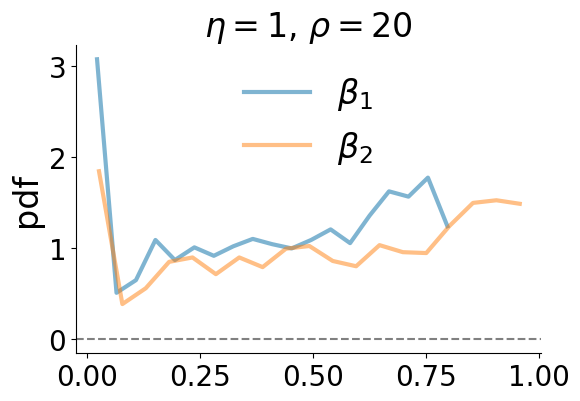

In [367]:
Tmax = int(1e5)
eta = 1
rho = 20
starting_nu = 1 # 3
ending_nu = 20
# starting_nu = 8
# ending_nu = 19

model_data[r"UMT($\eta=%s)$"%(str(eta))] = get_data_UMST(eta, rho, starting_nu, ending_nu,do_fig = True)
model_data[r"UMT($\eta=%s)$"%(str(eta))]['parameter_label'] = r"$\nu$"
model_data_by_parameter[r"UMT($\eta=%s)$"%(str(eta))] = get_data_UMST_by_parameter(eta, rho, starting_nu, ending_nu)

### UMST eta 0.1 rho 4

  0%|          | 0/20 [00:00<?, ?it/s]

FOUND 	2000


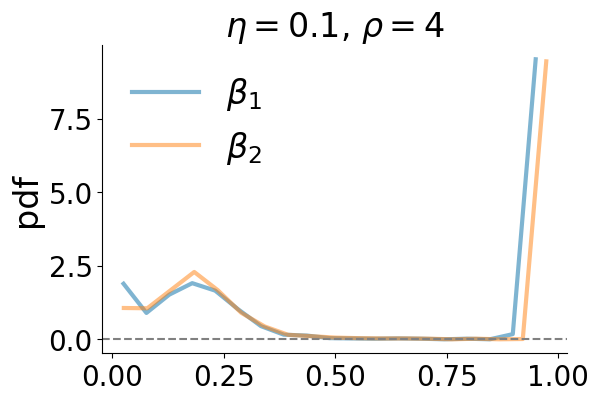

In [401]:
Tmax = int(1e5)
eta = 0.1
rho = 4
starting_nu = 1 # 1
ending_nu = 20 #12 #min(20, int(rho/eta))

model_data[r"UMST($\eta=%s)$"%(str(eta))] = get_data_UMST(eta, rho, starting_nu, ending_nu,do_fig = True)
model_data_by_parameter[r"UMST($\eta=%s)$"%(str(eta))] = get_data_UMST_by_parameter(eta, rho, starting_nu, ending_nu)
model_data[r"UMST($\eta=%s)$"%(str(eta))]['parameter_label'] = r"$\nu$"

In [476]:
Tmax = int(1e5)
eta = 0.1
rho = 4
starting_nu = 1 # 1
ending_nu = 20 #12 #min(20, int(rho/eta))

model_data[r"UMST($\eta=%s)$"%(str(eta))]['parameter_label'] = r"$\nu$"


### ERRW on SW

  0%|          | 0/2100 [00:00<?, ?it/s]

FOUND 	2100	2100


  0%|          | 0/2100 [00:00<?, ?it/s]

FOUND 	2100


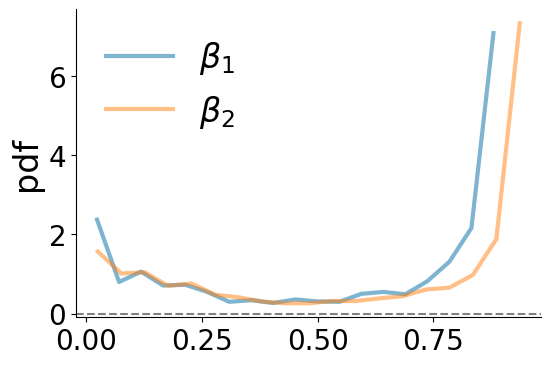

In [506]:
k = 4
model_data[fr"ERRW"] = get_data_ERRW(folder=f'SW_logspace_k_{k}_T_100000', do_fig = True)
model_data[r"ERRW"]['parameter_label'] = r"$dw$"
model_data_by_parameter[fr"ERRW"] = get_data_ERRW_by_parameter(folder=f'SW_logspace_k_{k}_T_100000')

In [ ]:
# k = 4
# model_data[fr"ERRW"] = get_data_ERRW(folder=f'SW_special_space_k_{k}_T_100000', do_fig = True)
# model_data[r"ERRW"]['parameter_label'] = r"$dw$"
# model_data_by_parameter[fr"ERRW"] = get_data_ERRW_by_parameter(folder=f'SW_special_space_k_{k}_T_100000')

### New model

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

FOUND 	44100
intercept 0.33365321834497946 slope 0.7974984046415672
p-value pearson between $\beta_1$ and $\beta_2$ 0.0


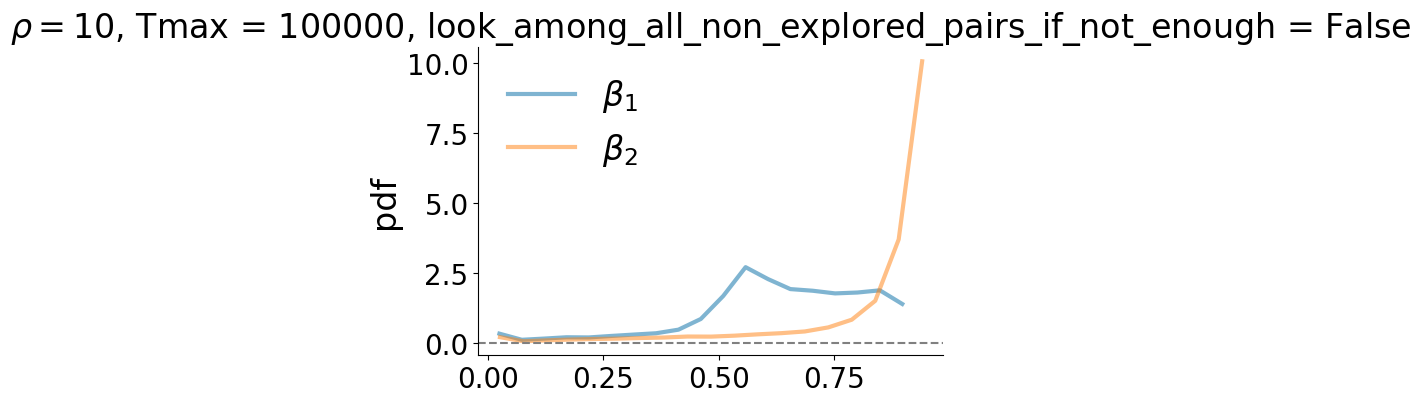

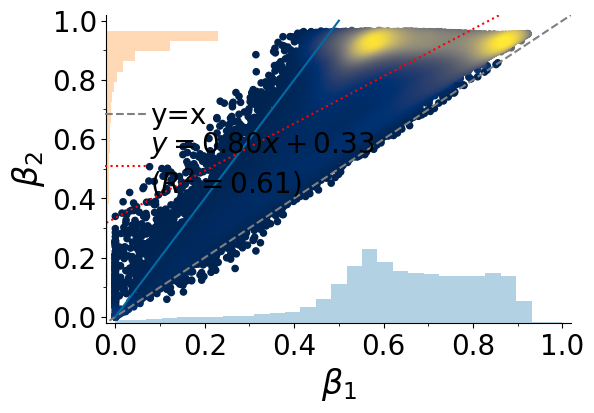

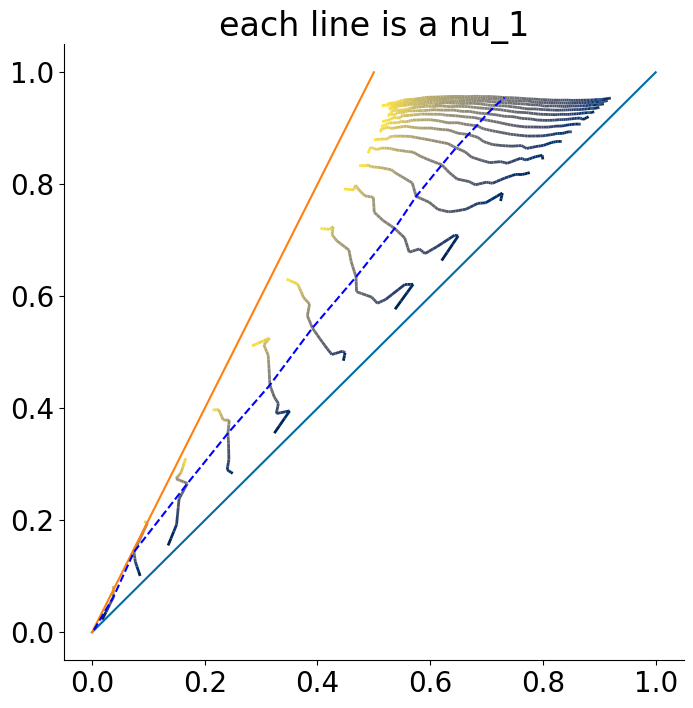

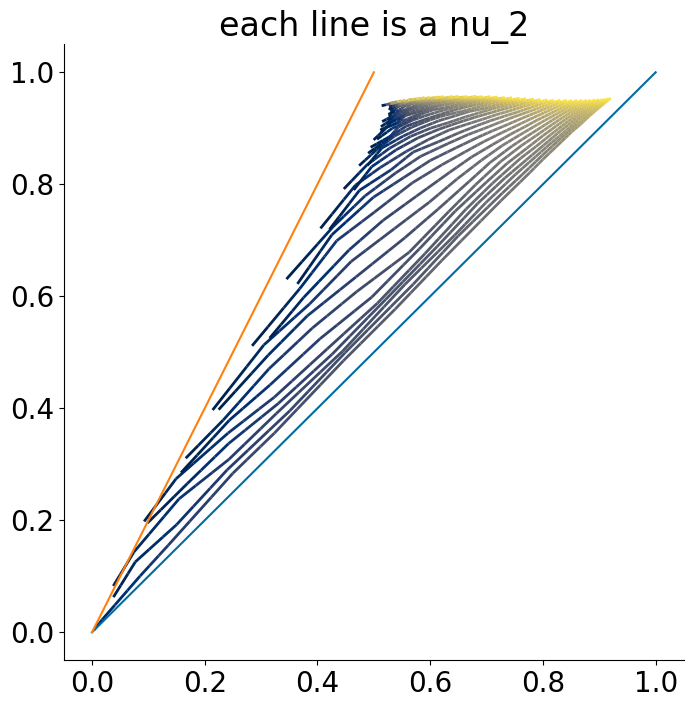

In [598]:
directed = False
do_non_overlapping_simulation = False
trigger_links_with_replacement = True
triggering_pairs_among_all_non_explored_pairs = False
look_among_all_non_explored_pairs_if_not_enough = False
trigger_links_with_new_colors_if_not_enough = False
trigger_links_between_new_colors_if_not_enough = False
Tmax = int(1e5)
new_model_data = get_data_new_pairs_UMT(
    rho = 10, 
    starting_nu_1 = 0, ending_nu_1 = 20,
    starting_nu_2 = 0, ending_nu_2 = None,
    fraction_nu_2_cut = 2,
    N_0 = 10, 
    M_0 = 0, 
    Tmax = Tmax,
    do_fig = True,
    t_to_use = Tmax,
    num_to_save = 1000,
    do_non_overlapping_simulation = do_non_overlapping_simulation,
    trigger_links_with_replacement = trigger_links_with_replacement,
    triggering_pairs_among_all_non_explored_pairs = triggering_pairs_among_all_non_explored_pairs,
    look_among_all_non_explored_pairs_if_not_enough = look_among_all_non_explored_pairs_if_not_enough,
    trigger_links_with_new_colors_if_not_enough = trigger_links_with_new_colors_if_not_enough, 
    trigger_links_between_new_colors_if_not_enough = trigger_links_between_new_colors_if_not_enough, 
    color_by_key = None,
    directed = directed,
)

In [634]:
individual_data, all_exponents, average_beta, average_beta2, average_beta_inverse, average_beta2_inverse, average_beta_dict, average_beta2_dict = new_model_data

In [869]:
model_data_by_parameter[fr"new model"] = {(nu_1, nu_2) : tmp_dict for nu_1,_ in individual_data.items() for nu_2,tmp_dict in _.items()}

#### Compare with other

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

FOUND 	12100
intercept 0.13201156050139087 slope 1.068373260052993
p-value pearson between $\beta_1$ and $\beta_2$ 0.0


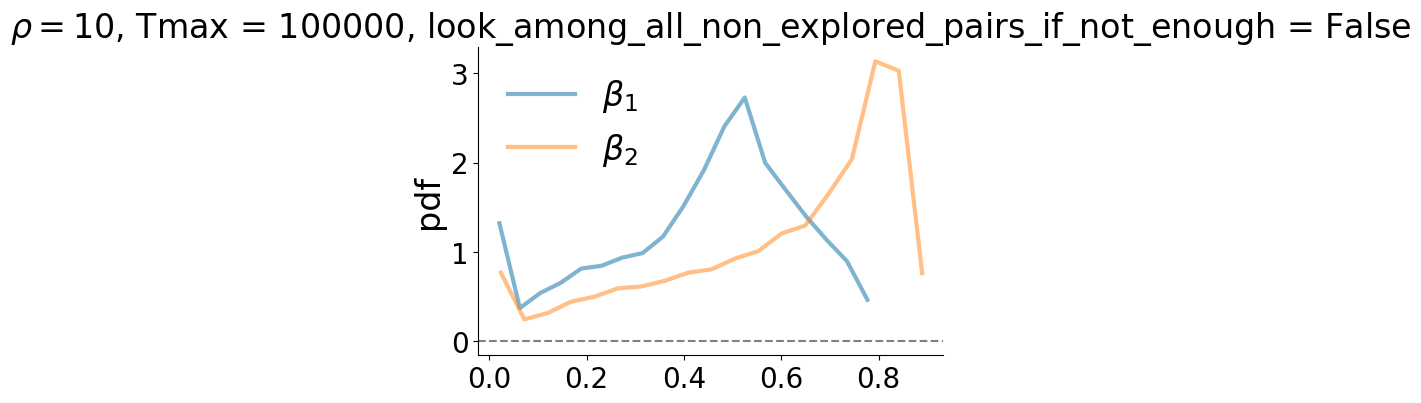

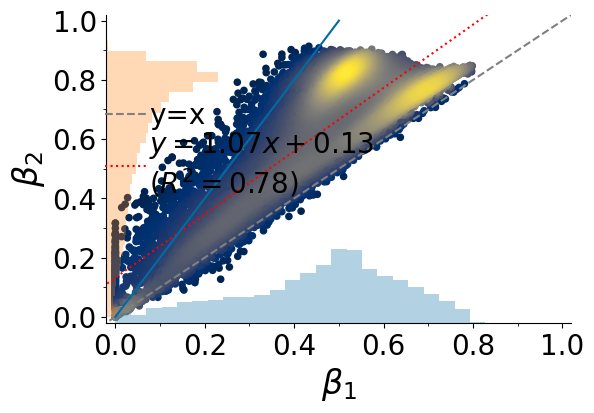

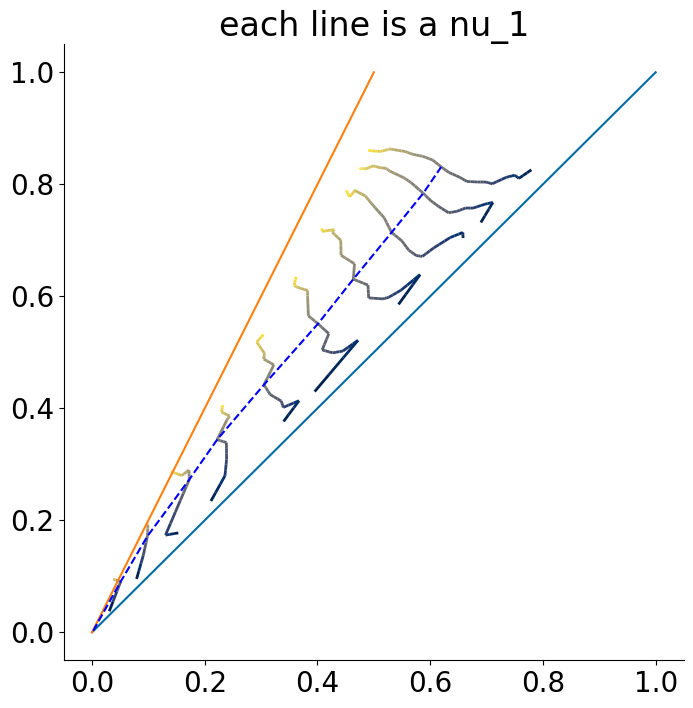

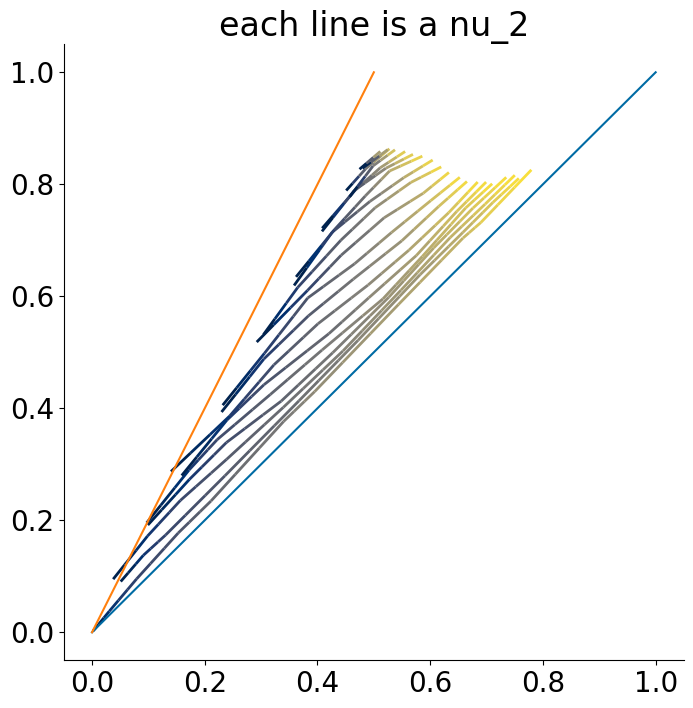

In [200]:
directed = False
do_non_overlapping_simulation = False
trigger_links_with_replacement = True
triggering_pairs_among_all_non_explored_pairs = False
Tmax = int(1e5)
tmp_new_model_data = get_data_new_pairs_UMT(
    rho = 10, 
    starting_nu_1 = 0, ending_nu_1 = 10,
    starting_nu_2 = 0, ending_nu_2 = None,
    fraction_nu_2_cut = 2,
    N_0 = 10, 
    M_0 = 0, 
    Tmax = Tmax,
    do_fig = True,
    t_to_use = Tmax,
    num_to_save = 1000,
    do_non_overlapping_simulation = do_non_overlapping_simulation,
    trigger_links_with_replacement = trigger_links_with_replacement,
    triggering_pairs_among_all_non_explored_pairs = triggering_pairs_among_all_non_explored_pairs,
    look_among_all_non_explored_pairs_if_not_enough = False,
    trigger_links_with_new_colors_if_not_enough = False, 
    trigger_links_between_new_colors_if_not_enough = False, 
    color_by_key = None,
    directed = directed,
)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

FOUND 	12100
intercept 0.10797361333562788 slope 1.0195593388591322
p-value pearson between $\beta_1$ and $\beta_2$ 0.0


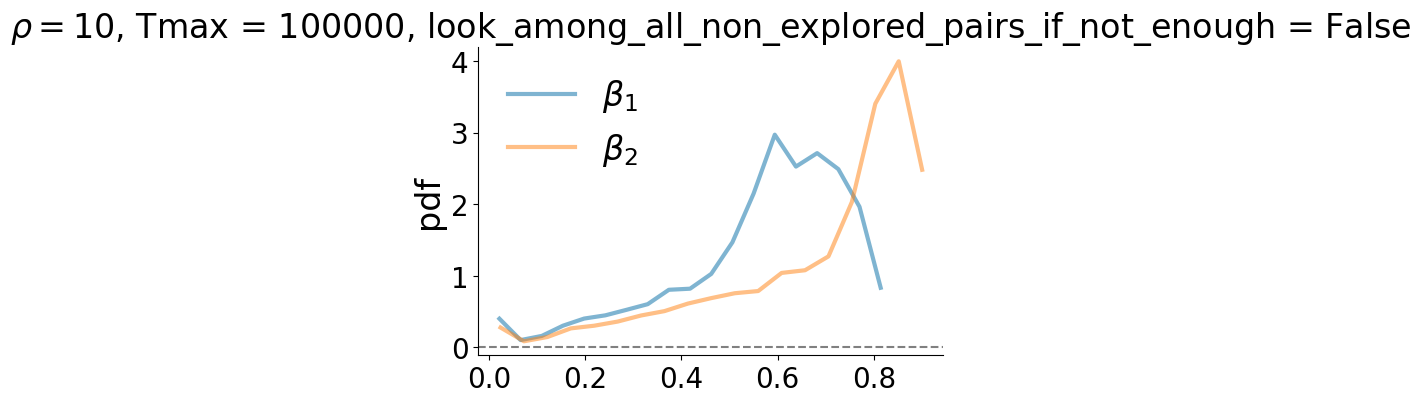

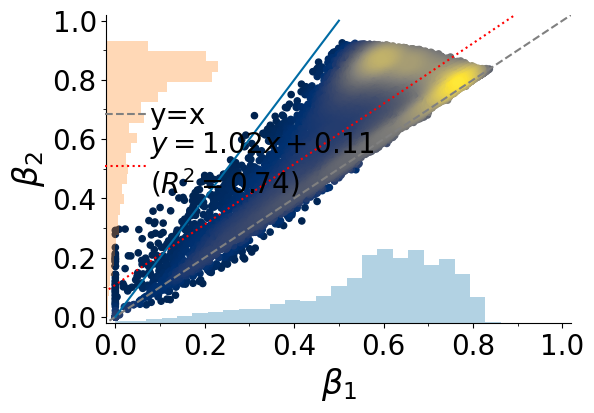

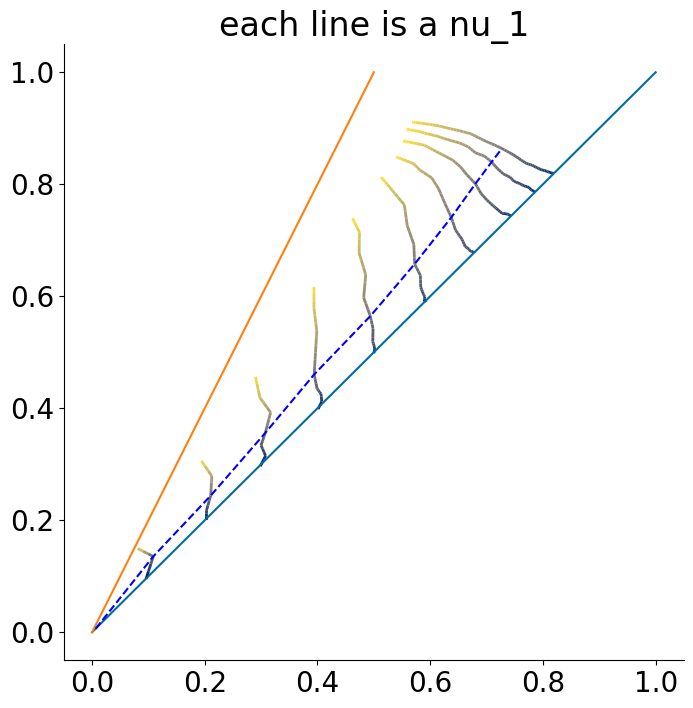

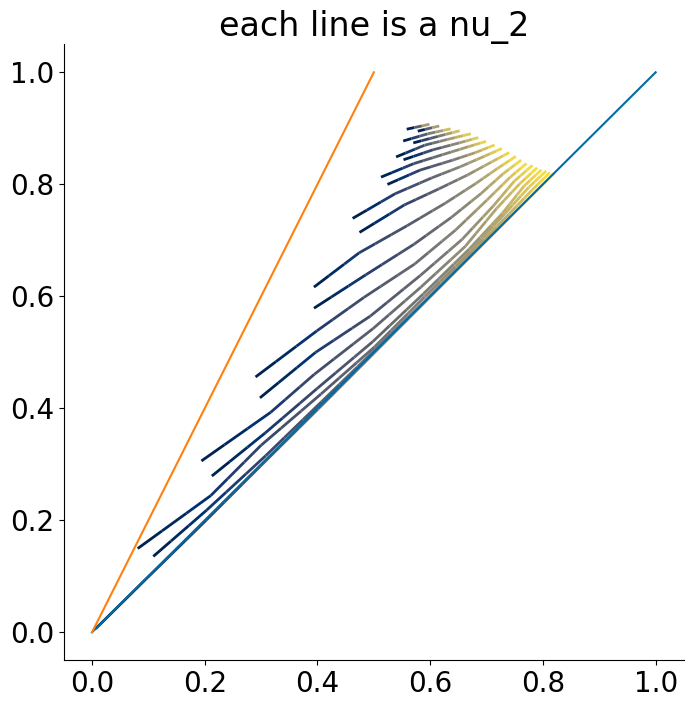

In [219]:
directed = True
do_non_overlapping_simulation = True
trigger_links_with_replacement = True
triggering_pairs_among_all_non_explored_pairs = False
Tmax = int(1e5)
dir_no_ov_regIac_new_model_data = get_data_new_pairs_UMT(
    rho = 10, 
    starting_nu_1 = 0, ending_nu_1 = 10,
    starting_nu_2 = 0, ending_nu_2 = None,
    fraction_nu_2_cut = 2,
    N_0 = 10, 
    M_0 = 0, 
    Tmax = Tmax,
    do_fig = True,
    t_to_use = Tmax,
    num_to_save = 1000,
    do_non_overlapping_simulation = do_non_overlapping_simulation,
    trigger_links_with_replacement = trigger_links_with_replacement,
    triggering_pairs_among_all_non_explored_pairs = triggering_pairs_among_all_non_explored_pairs,
    look_among_all_non_explored_pairs_if_not_enough = False,
    trigger_links_with_new_colors_if_not_enough = False, 
    trigger_links_between_new_colors_if_not_enough = False, 
    color_by_key = None,
    directed = directed,
)

### Get best parameter per model (dist w/ beta_1 and beta_2)

#### Functions for script

In [154]:
def sq_distance(x, y):
    assert len(x) == len (y), f'x and y must have the same length, here they are {len(x)} and {len(y)}'
    x = np.array(x)
    y = np.array(y)
    return np.sum((y-x)**2)

In [155]:
def get_best_parameter_sq_distance(
    x = np.array([0,1]), # point to fit
    model_2_ys_dict = {}, # parameter(s tuple) as key, np.ndarray long as the number of simulations, wide as dimension of x for values
    return_sorted_all = False,
    return_sqrt_dist = True,
):
    '''
    Confronts the given value x with the simulated values of the various models. Computes the average distance obtained by each model.
    If return_sorted_all, it returns the sorted models and average distances, sorted according to their distance.
    Otherwise it returns only the best model and its average distance.
    '''
    model_2_avg_dist_list = []
    for model, ys in model_2_ys_dict.items():
        distances = []
        for y in ys:
            distances.append(sq_distance(x, y))
        model_2_avg_dist_list.append((np.mean(distances), model))
    if return_sorted_all:
        sorted_model_2_avg_dist_list = sorted(model_2_avg_dist_list)
        avg_dists, best_models = np.array([_[1] for _ in sorted_model_2_avg_dist_list]) , [_[0] for _ in sorted_model_2_avg_dist_list]
        if return_sqrt_dist:
            avg_dists = np.sqrt(avg_dists)
        return avg_dists, best_models
    else:
        avg_dist, best_model = min(model_2_avg_dist_list)
        if return_sqrt_dist:
            avg_dist = np.sqrt(avg_dist)
        return best_model, avg_dist

#### Load necessary data

In [59]:
with open('./data/data_to_compare_with_models.pkl', "rb") as fp:
    data_to_compare_with_models = joblib.load(fp)

In [60]:
with open('./data/best_representation_models_all.pkl', "rb") as fp:
    best_representation_models = joblib.load(fp)

In [61]:
with open('./data/models_2_betas_betas2_dict.pkl', "rb") as fp:
    models_2_betas_betas2_dict = joblib.load(fp)
with open('./data/models_2_average_individual_data.pkl', "rb") as fp:
    models_2_average_individual_data = joblib.load(fp)

#### Collect and dump necessary data

In [156]:
with gzip.open('./data/essential_entropy_data_for_figure.pkl.gz', "rb") as fp:
    data_with_entropy = joblib.load(fp)

In [118]:
data_to_compare_with_models = {}
for dataset_label, dataset_dict in tqdm(data_with_entropy.items()):
    data_to_compare_with_models[dataset_label] = {
        'betas' : dataset_dict['betas'],
        'betas2' : dataset_dict['betas2'],
    }

  0%|          | 0/3 [00:00<?, ?it/s]

In [119]:
with open('./data/data_to_compare_with_models.pkl', 'wb') as fp:
    pickle.dump(data_to_compare_with_models, fp)

In [121]:
model_data_by_parameter.keys()

dict_keys(['UMT($\\eta=1)$', 'UMT($\\eta=0.5)$', 'UMT($\\eta=0.1)$', 'ERRW', 'new model'])

In [140]:
models_2_betas_betas2_dict = {}
models_2_weighted_diff_entropies_dict = {}
models_2_weighted_diff_entropies_pairs_dict = {}
models_2_average_individual_data = {}

for model_label, model_data in tqdm(model_data_by_parameter.items()):
    models_2_betas_betas2_dict[model_label] = {}
    models_2_weighted_diff_entropies_dict[model_label] = {}
    models_2_weighted_diff_entropies_pairs_dict[model_label] = {}
    models_2_average_individual_data[model_label] = {}
    for param, tmp_dict in model_data.items():
        models_2_betas_betas2_dict[model_label][param] = np.array([np.array([tmp_dict['betas'][i], tmp_dict['betas2'][i]]) for i in range(len(tmp_dict['betas']))])
        models_2_average_individual_data[model_label][param] = {}
        models_2_average_individual_data[model_label][param]['beta'] = np.mean(tmp_dict['betas'])
        models_2_average_individual_data[model_label][param]['beta2'] = np.mean(tmp_dict['betas2'])


  0%|          | 0/5 [00:00<?, ?it/s]

In [141]:
with open('./data/models_2_betas_betas2_dict.pkl', 'wb') as fp:
    pickle.dump(models_2_betas_betas2_dict, fp)

with open('./data/models_2_average_individual_data.pkl', 'wb') as fp:
    pickle.dump(models_2_average_individual_data, fp)

In [177]:
best_representation_models = {}
for model_label in tqdm(models_2_betas_betas2_dict.keys()):
    print('Model:', model_label, flush=True)
    best_representation_model = best_representation_models[model_label] = {}
    model_2_betas_betas2_dict = models_2_betas_betas2_dict[model_label]
    model_2_weighted_diff_entropies_dict = models_2_weighted_diff_entropies_dict[model_label]
    model_2_weighted_diff_entropies_pairs_dict = models_2_weighted_diff_entropies_pairs_dict[model_label]
    model_2_average_individual_data = models_2_average_individual_data[model_label]
    for dataset_label, dataset_dict in tqdm(data_to_compare_with_models.items()):
        print('\tDataset:', dataset_label, flush=True)
        best_dataset_dict = best_representation_model[dataset_label] = {
            'betas' : dataset_dict['betas'],
            'betas2' : dataset_dict['betas2'],
            'best_model' : [], 
            'avg_distance_best_model' : [], 
            'betas_best_model' : [],
            'betas2_best_model' : [],
            'dist_avg_betas' : [],
            'dist_avg_betas2' : [],
            'avg_dist_betas' : [],
            'avg_dist_betas2' : [],
        }
        for i in tqdm(range(len(best_dataset_dict['betas']))):
            beta = best_dataset_dict['betas'][i]
            beta2 = best_dataset_dict['betas2'][i]
            weighted_diff_entropies = best_dataset_dict['weighted_diff_entropies'][i]
            weighted_diff_entropies_pairs = best_dataset_dict['weighted_diff_entropies_pairs'][i]

            best_model, avg_distance_best_model = get_best_parameter_sq_distance(
                x = np.array([beta, beta2]), # point to fit
                model_2_ys_dict = model_2_betas_betas2_dict, # parameter(s tuple) as key, np.ndarray long as the number of simulations, wide as dimension of x for values
    #             return_sorted_all = False,
            )

            best_dataset_dict['best_model'].append(best_model)
            best_dataset_dict['avg_distance_best_model'].append(avg_distance_best_model)
            best_dataset_dict['betas_best_model'].append(model_2_average_individual_data[best_model]['beta'])
            best_dataset_dict['betas2_best_model'].append(model_2_average_individual_data[best_model]['beta2'])
            best_dataset_dict['dist_avg_betas'].append(np.abs(model_2_average_individual_data[best_model]['beta'] - beta))
            best_dataset_dict['dist_avg_betas2'].append(np.abs(model_2_average_individual_data[best_model]['beta2'] - beta2))
            avg_dist_betas, avg_dist_betas2 = np.mean(np.abs(model_2_betas_betas2_dict[best_model] - np.array([beta,beta2])), axis = 0)
            best_dataset_dict['avg_dist_betas'].append(avg_dist_betas)
            best_dataset_dict['avg_dist_betas2'].append(avg_dist_betas2)
        with open('./data/best_representation_models_all.pkl', 'wb') as fp:
            pickle.dump(best_representation_models, fp)

  0%|          | 0/5 [00:00<?, ?it/s]

Model: UMT($\eta=1)$


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/889 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

Model: ERRW


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/889 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

Model: new model


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/889 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

Model: UMST($\eta=0.5)$


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/889 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

Model: UMST($\eta=0.1)$


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/889 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19637 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/19000 [00:00<?, ?it/s]

### Get best parameter per model SMALL ERROR (dist w/ beta_1 and beta_2)

#### Load best_representation_new_model

In [842]:
with open('./data/best_representation_new_model_small_error.pkl', "rb") as fp:
    best_representation_new_model = joblib.load(fp)

#### Load necessary data

In [59]:
with open('./data/data_to_compare_with_models_small_error.pkl', "rb") as fp:
    data_to_compare_with_models = joblib.load(fp)

In [61]:
with open('./data/models_2_betas_betas2_dict.pkl', "rb") as fp:
    models_2_betas_betas2_dict = joblib.load(fp)
with open('./data/models_2_average_individual_data.pkl', "rb") as fp:
    models_2_average_individual_data = joblib.load(fp)

In [842]:
with open('./data/best_representation_models_all.pkl', "rb") as fp:
    best_representation_models = joblib.load(fp)

#### Collect and dump necessary data

In [870]:
average_data = {}
for dataset_label, dataset in data_small_error.items():
    x_data = np.array(dataset[f'betas'])
    y_data = np.array(dataset[f'betas2'])
    average_data[dataset_label] = {}
    average_data[dataset_label]['beta'] = np.mean(x_data)
    average_data[dataset_label]['beta2'] = np.mean(y_data)

In [871]:
data_to_compare_with_models = {}
for dataset_label, dataset_dict in tqdm(data_small_error.items()):
    data_to_compare_with_models[dataset_label] = {
        'betas' : dataset_dict['betas'],
        'betas2' : dataset_dict['betas2'],
    }

  0%|          | 0/3 [00:00<?, ?it/s]

In [872]:
with open('./data/data_to_compare_with_models_small_error.pkl', 'wb') as fp:
    pickle.dump(data_to_compare_with_models, fp)

In [881]:
models_2_betas_betas2_dict = {}
models_2_average_individual_data = {}

for model_label, model_data in tqdm(model_data_by_parameter.items()):
    models_2_betas_betas2_dict[model_label] = {}
    models_2_average_individual_data[model_label] = {}
    for param, tmp_dict in model_data.items():
        models_2_betas_betas2_dict[model_label][param] = np.array([np.array([tmp_dict['betas'][i], tmp_dict['betas2'][i]]) for i in range(len(tmp_dict['betas']))])
        models_2_average_individual_data[model_label][param] = {}
        models_2_average_individual_data[model_label][param]['beta'] = np.mean(tmp_dict['betas'])
        models_2_average_individual_data[model_label][param]['beta2'] = np.mean(tmp_dict['betas2'])

  0%|          | 0/4 [00:00<?, ?it/s]

In [882]:
with open('./data/models_2_betas_betas2_dict.pkl', 'wb') as fp:
    pickle.dump(models_2_betas_betas2_dict, fp)

with open('./data/models_2_average_individual_data.pkl', 'wb') as fp:
    pickle.dump(models_2_average_individual_data, fp)

In [ ]:
best_representation_models_small_error = {}
for model_label in tqdm(models_2_betas_betas2_dict.keys()):
    print('Model:', model_label, flush=True)
    best_representation_model = best_representation_models_small_error[model_label] = {}
    model_2_betas_betas2_dict = models_2_betas_betas2_dict[model_label]
    model_2_weighted_diff_entropies_dict = models_2_weighted_diff_entropies_dict[model_label]
    model_2_weighted_diff_entropies_pairs_dict = models_2_weighted_diff_entropies_pairs_dict[model_label]
    model_2_average_individual_data = models_2_average_individual_data[model_label]
    for dataset_label, dataset_dict in tqdm(data_to_compare_with_models.items()):
        print('\tDataset:', dataset_label, flush=True)
        best_dataset_dict = best_representation_model[dataset_label] = {
            'betas' : dataset_dict['betas'],
            'betas2' : dataset_dict['betas2'],
            'best_model' : [], 
            'avg_distance_best_model' : [], 
            'betas_best_model' : [],
            'betas2_best_model' : [],
            'dist_avg_betas' : [],
            'dist_avg_betas2' : [],
            'avg_dist_betas' : [],
            'avg_dist_betas2' : [],
        }
        for i in tqdm(range(len(best_dataset_dict['betas']))):
            beta = best_dataset_dict['betas'][i]
            beta2 = best_dataset_dict['betas2'][i]

            best_model, avg_distance_best_model = get_best_parameter_sq_distance(
                x = np.array([beta, beta2]), # point to fit
                model_2_ys_dict = model_2_betas_betas2_dict, # parameter(s tuple) as key, np.ndarray long as the number of simulations, wide as dimension of x for values
    #             return_sorted_all = False,
            )

            best_dataset_dict['best_model'].append(best_model)
            best_dataset_dict['avg_distance_best_model'].append(avg_distance_best_model)
            best_dataset_dict['betas_best_model'].append(model_2_average_individual_data[best_model]['beta'])
            best_dataset_dict['betas2_best_model'].append(model_2_average_individual_data[best_model]['beta2'])

            best_dataset_dict['dist_avg_betas'].append(np.abs(model_2_average_individual_data[best_model]['beta'] - beta))
            best_dataset_dict['dist_avg_betas2'].append(np.abs(model_2_average_individual_data[best_model]['beta2'] - beta2))
            avg_dist_betas, avg_dist_betas2 = np.mean(np.abs(model_2_betas_betas2_dict[best_model] - np.array([beta,beta2])), axis = 0)
            best_dataset_dict['avg_dist_betas'].append(avg_dist_betas)
            best_dataset_dict['avg_dist_betas2'].append(avg_dist_betas2)
        with open('./data/best_representation_models_all_small_error.pkl', 'wb') as fp:
            pickle.dump(best_representation_models, fp)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: UMT($\eta=1)$


  0%|          | 0/3 [00:00<?, ?it/s]

	Dataset: Last.fm


  0%|          | 0/860 [00:00<?, ?it/s]

	Dataset: Project Gutenberg


  0%|          | 0/19629 [00:00<?, ?it/s]

	Dataset: Semantic Scholar


  0%|          | 0/18995 [00:00<?, ?it/s]

In [ ]:
best_representation_new_model = best_representation_models_small_error['new model']

In [ ]:
with open('./data/best_representation_new_model_small_error.pkl', 'wb') as fp:
    pickle.dump(best_representation_models_small_error['new model'], fp)

## Figure comparison previous models

UMT($\eta=1)$


No handles with labels found to put in legend.


UMST($\eta=0.1)$


No handles with labels found to put in legend.


ERRW


No handles with labels found to put in legend.


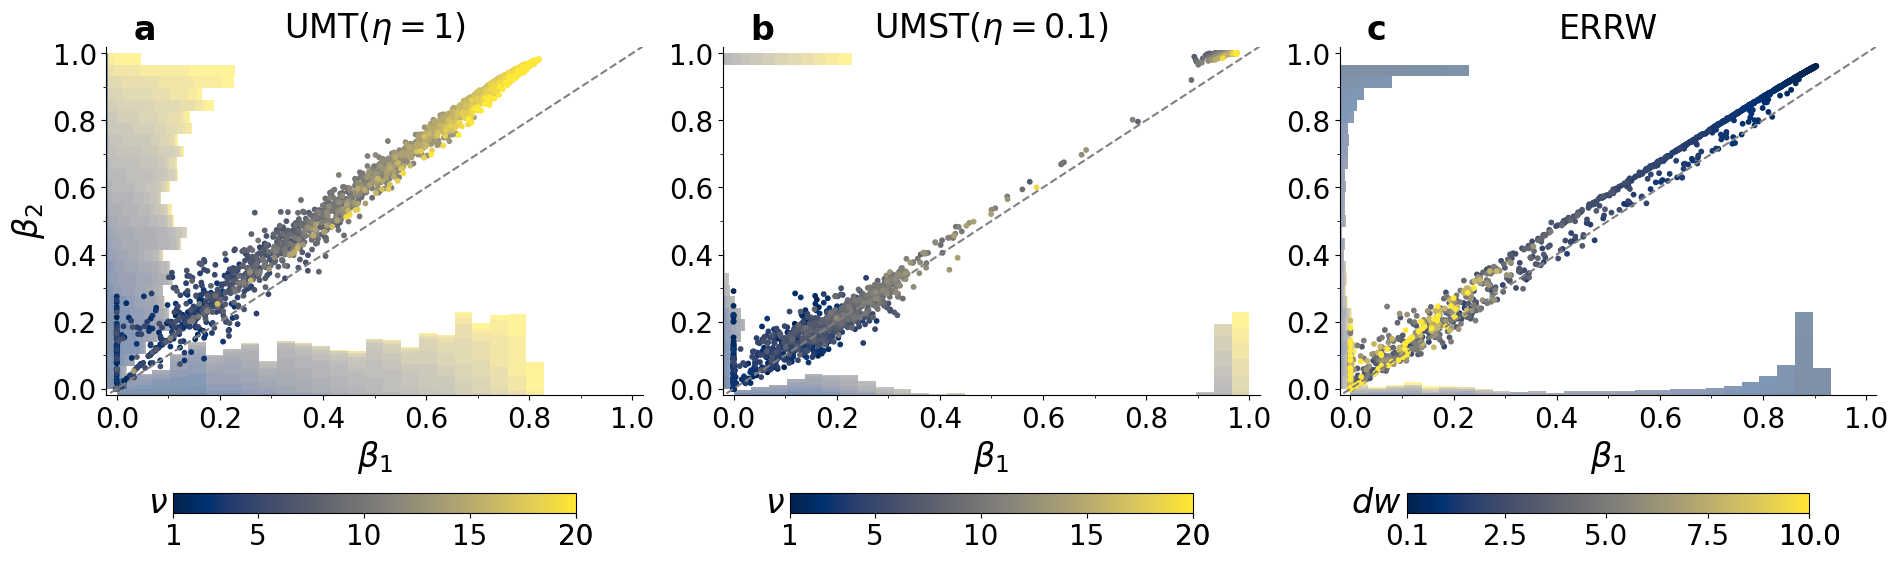

In [835]:
fig = fig_2(
    model_data, 
    marker_size = 10, alpha_scatter = 1, alpha_histogram = 0.5, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    min_x_scatter_heaps = 0,
    max_x_scatter_heaps = 1,
    min_y_scatter_heaps = 0,
    max_y_scatter_heaps = 1,
    plot_pearson = False,
                                        use_same_x_y_max_lim = True,
    do_dashed_line = True,
    x_correlation_text = 0.55, 
    y_correlation_text = .32,
    num_bins = 35,
    use_beta2_relative = False,
    color_by_parameter_key = 'parameter',
)


fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations.png"))
fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations_low_res.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations.pdf"),format='pdf')

UMT($\eta=1)$


No handles with labels found to put in legend.


UMST($\eta=0.1)$


No handles with labels found to put in legend.


ERRW


No handles with labels found to put in legend.


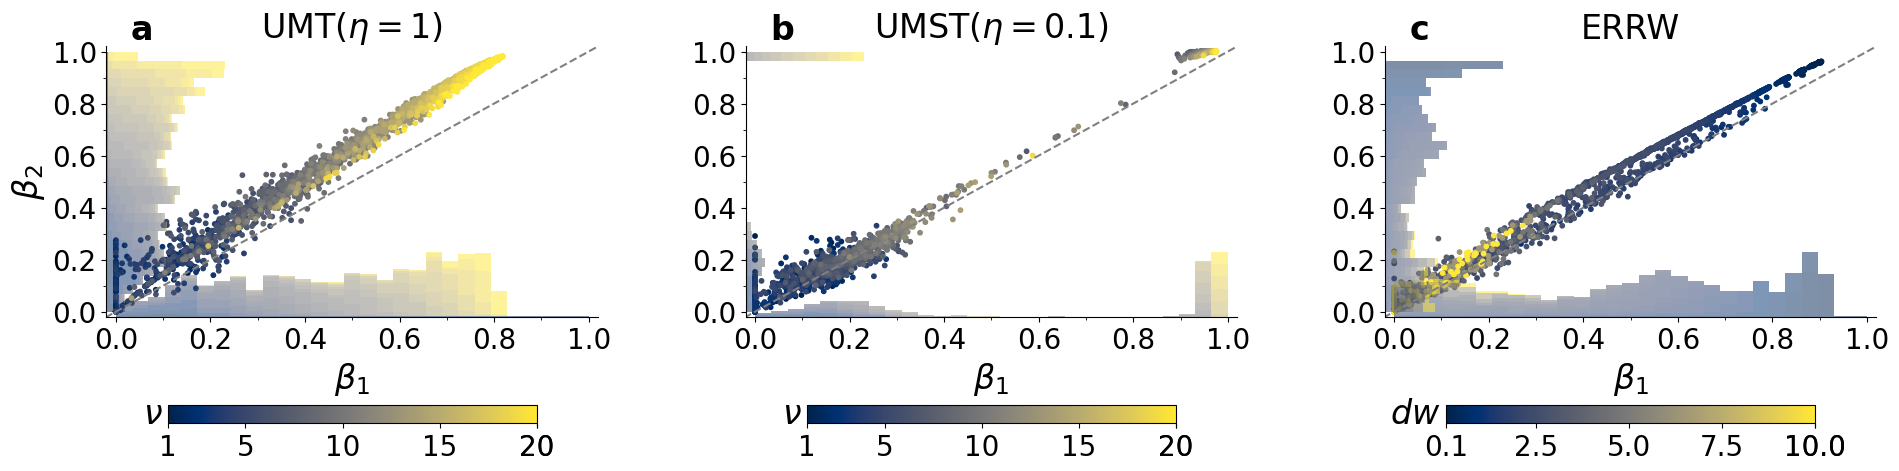

In [505]:
fig = fig_2(
    model_data, 
    marker_size = 10, alpha_scatter = 1, alpha_histogram = 0.5, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    min_x_scatter_heaps = 0,
    max_x_scatter_heaps = 1,
    min_y_scatter_heaps = 0,
    max_y_scatter_heaps = 1,
    plot_pearson = False,
                                        use_same_x_y_max_lim = True,
    do_dashed_line = True,
    x_correlation_text = 0.55, 
    y_correlation_text = .32,
    num_bins = 35,
    use_beta2_relative = False,
    color_by_parameter_key = 'parameter',
)


fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations2.png"))
fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations_low_res2.pdf"),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig2_model_simulations2.pdf"),format='pdf')

## Figure new model

$\rho=10$,$\nu_1=10$,$\nu_2=15$


No handles with labels found to put in legend.


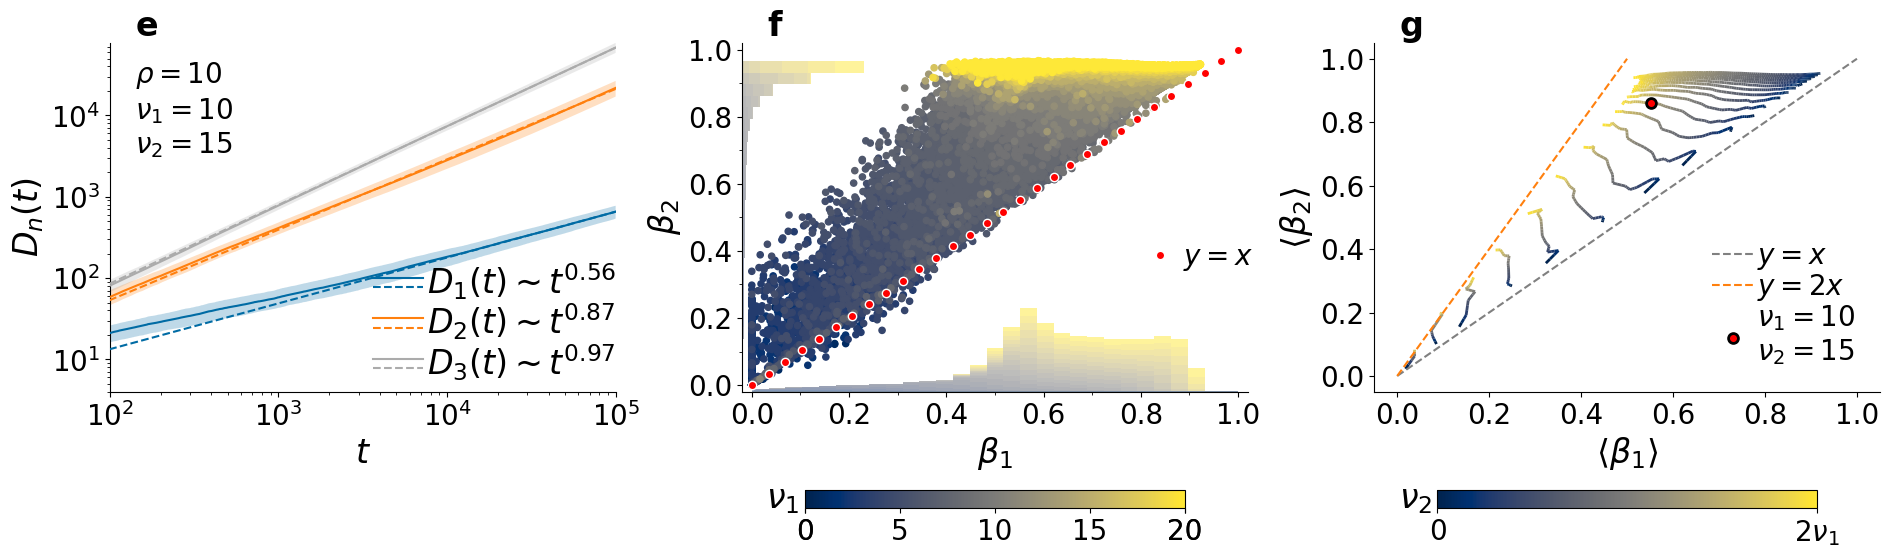

In [679]:
fig = fig_new_model(
    individual_data, all_exponents, average_beta, average_beta2, average_beta_inverse, average_beta2_inverse, average_beta_dict, average_beta2_dict, average_data,
    color_by_key = 'nu_1',
    marker_size = 10, alpha_scatter = 1, alpha_histogram = 0.5, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 4e0,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
    use_same_x_y_max_lim = True,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    rho = 10,
    special_nu_1_list = [10],
    special_nu_2_list = [15],
    shaded_above_heaps_keyword = '_indices_plus_std',
    shaded_below_heaps_keyword = '_indices_minus_std',
)

fig.savefig(os.path.join(figures_folder, f"Fig3_new_model.png"))
fig.savefig(os.path.join(figures_folder, f"Fig3_new_model_low_res.pdf"),dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig3_new_model.pdf"))

## Figures distances data - model

### Hist dist 2d

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


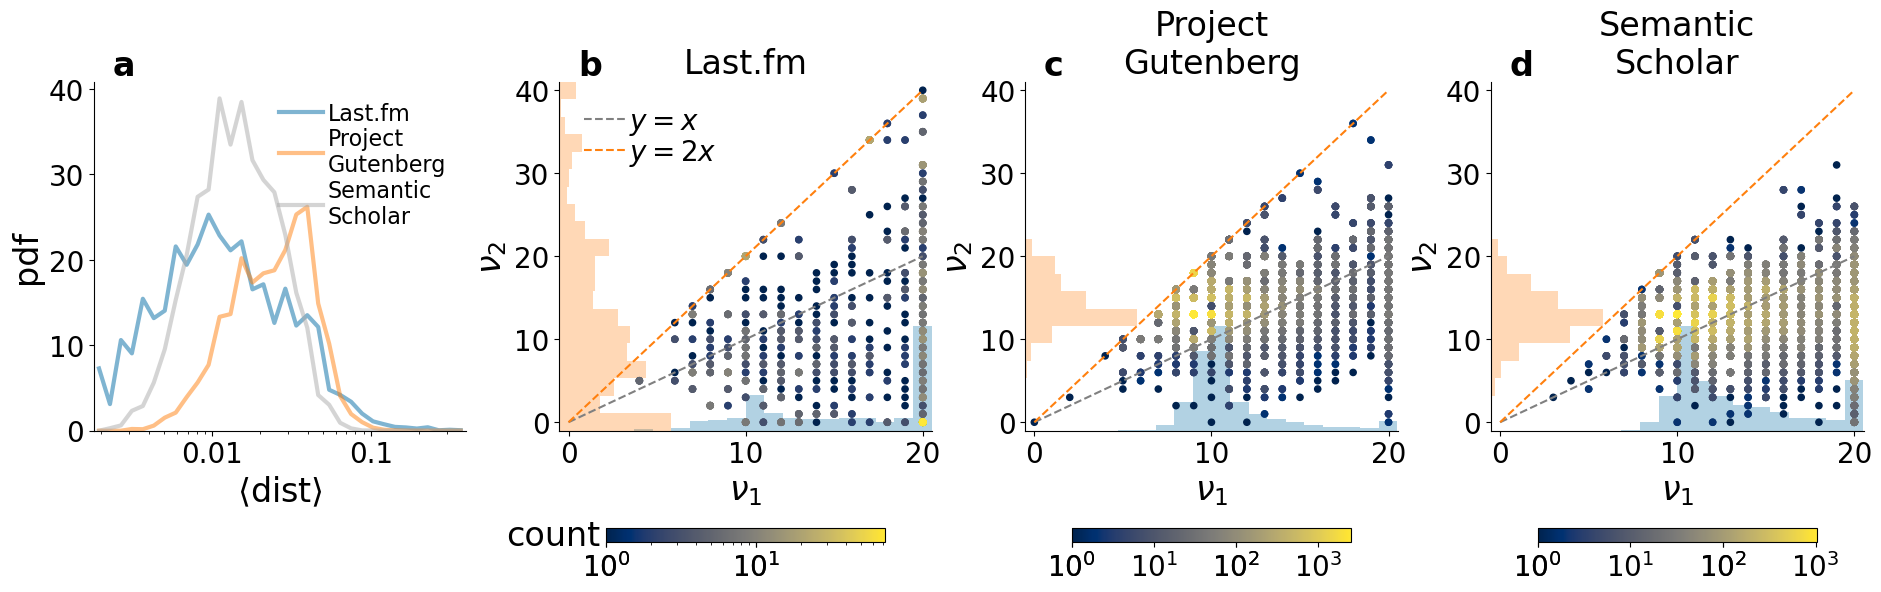

In [834]:
fig = fig_new_model_distance_data(
    best_representation_new_model,
    color_by_key = 'nu_1',
    marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.3,
    xlim_left_a = 1, ylim_bottom_a = 1,
    num_bins_hist_x = 21,
    num_bins_hist_y = 21,
    min_beta = None,
    max_beta = None,
    min_beta_higher = None,
    max_beta_higher = None,
    use_same_x_y_max_lim = True,
    plot_pearson = False,
    x_correlation_text = 1.06, 
    y_correlation_text = .27,
    rho = 10,
    distance_key = 'avg_distance_best_model',
    do_log_hist = True,
    log_counter = True,
    count_points = True,
    min_x = -0.5, 
    max_x = 20.5, 
    min_y = -1, 
    max_y = 41, 
)

fig.savefig(os.path.join(figures_folder, f"Fig4_new_model_distance_data.png"))
fig.savefig(os.path.join(figures_folder, f"Fig4_new_model_distance_data_low_res.pdf"),dpi=100)
fig.savefig(os.path.join(figures_folder, f"Fig4_new_model_distance_data.pdf"))

<AxesSubplot:xlabel='$\\langle$dist$\\rangle$', ylabel='pdf'>

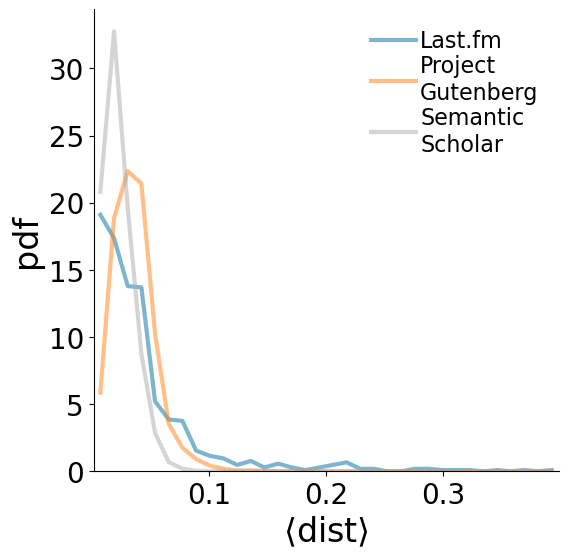

In [836]:
fig, ax = plt.subplots(figsize=(6,6))
key = 'avg_distance_best_model'
# for col, (dataset_label, best_dataset_dict) in enumerate(best_representation_new_model.items()):
subplot_distr(
    best_representation_new_model, 
    key,
    ax = ax, alpha = 0.5, 
    number_to_write = 0, 
    num_bins = 35,
    xlim_left = None, xlim_right = None, 
    ylim_bottom = 0,
    xlabel = r"$\langle$dist$\rangle$", 
    ylabel = r"pdf", 
    do_legend = True,
    write_number = False,
    do_log_hist = False,
    do_density = True,
      do_mean = False,
      do_median = False,
    split_label = True,
    avoid_log_ticks = True
    )


## Other figures new model

### Check std_err new model

In [855]:
for nu_1 in individual_data.keys():
    for nu_2,tmp_dict in individual_data[nu_1].items():
        if nu_2 > 0:
            for std_err in tmp_dict['std_err_beta_loglogregr_indices_geom_list_finals']:
                if std_err > 0.1:
                    print(nu_1, nu_2, 'beta')
            for std_err in tmp_dict['std_err_beta2_loglogregr_indices_geom_list_finals']:
                if std_err > 0.1:
                    print(nu_1, nu_2, 'beta2')

1 2 beta2
1 2 beta2
2 1 beta
2 1 beta2
2 1 beta2
3 1 beta
4 2 beta
4 2 beta2
4 5 beta2
5 1 beta
5 1 beta2
5 2 beta
5 2 beta2
6 1 beta
6 1 beta
6 1 beta
6 1 beta
6 1 beta2
6 1 beta2
6 1 beta2
6 1 beta2
7 1 beta2
8 1 beta
8 1 beta2
9 1 beta
9 1 beta2
9 2 beta
9 2 beta2
12 5 beta
12 5 beta2


In [863]:
for nu_1 in individual_data.keys():
    for nu_2,tmp_dict in individual_data[nu_1].items():
#         if nu_2 > 0:
            if np.mean(tmp_dict['std_err_beta_loglogregr_indices_geom_list_finals']) > 0.05:
                    print(nu_1, nu_2, 'beta')
            if np.mean(tmp_dict['std_err_beta2_loglogregr_indices_geom_list_finals']) > 0.05:
                    print(nu_1, nu_2, 'beta2')

5 0 beta
5 0 beta2
6 0 beta
6 0 beta2


### Check Heaps

$\rho=10$,$\nu_1=6$,$\nu_2=1$
$\rho=10$,$\nu_1=6$,$\nu_2=0$


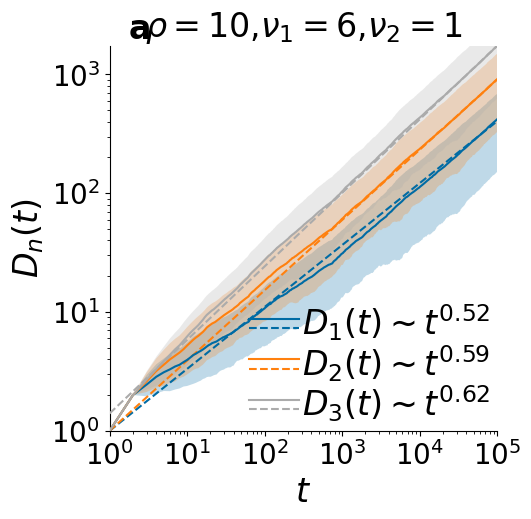

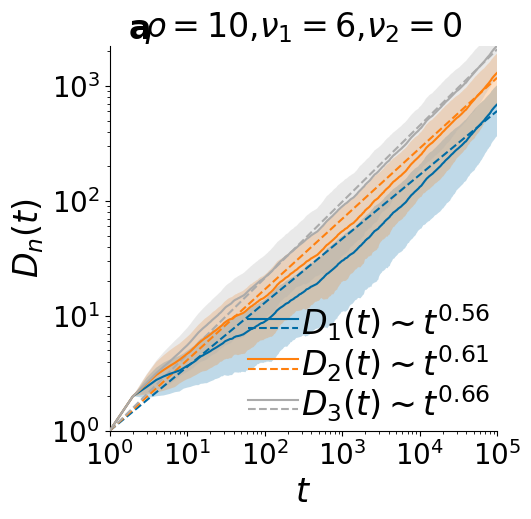

In [859]:
rho = 10
special_nu_1_list = [6,6]
special_nu_2_list = [1,0]
use_same_x_y_max_lim = False
higher_orders = [2,3]
marker_size = 20
alpha_scatter = 1
# HEAPS LAW
max_t = 1
max_D = 1
# ax = plt.Subplot(fig, inner[0])
for i, nu_1 in enumerate(special_nu_1_list):
    fig,ax = plt.subplots(figsize=(5,5))
    nu_2 = special_nu_2_list[i]
    dataset_label = fr'$\rho={rho}$,$\nu_1={nu_1}$,$\nu_2={nu_2}$'
    dataset_dict = individual_data[nu_1][nu_2]
    for order in ['', '2', '3', '4']:
        dataset_dict[f'beta{order}'] = dataset_dict[f'beta{order}_loglogregr_indices_geom']
        dataset_dict[f'intercept{order}'] = dataset_dict[f'intercept{order}_loglogregr_indices_geom']
    print(dataset_label)
    if use_same_x_y_max_lim == False:
        max_t = dataset_dict["ts"][-1]+1
        max_D = 1
    else:
        max_t = max(max_t,dataset_dict["ts"][-1]+1)
    for order in ['']+[str(tmp_order) for tmp_order in higher_orders]:
        max_D = max(max_D, dataset_dict[f"D{order}_indices"][-1]+1)
    xlabel_heaps_law = r"$t$"
    ylabel_heaps_law = r'$D_n(t)$'
    subplot_heaps_law(dataset_dict, 
        ax = ax, 
        marker_size = marker_size, alpha = alpha_scatter, 
        number_to_write = 0, 
        xlim_left = 1, xlim_right = max_t, 
        ylim_bottom = 1, ylim_top = max_D, 
        title = '\n'.join(dataset_label.split(' ')),
        xlabel = xlabel_heaps_law, 
        ylabel = ylabel_heaps_law, write_number = True,
                      shaded_above_heaps_keyword = '_indices_plus_std',
                      shaded_below_heaps_keyword = '_indices_minus_std',
    )
# fig.add_subplot(ax)

### Check beta vs t

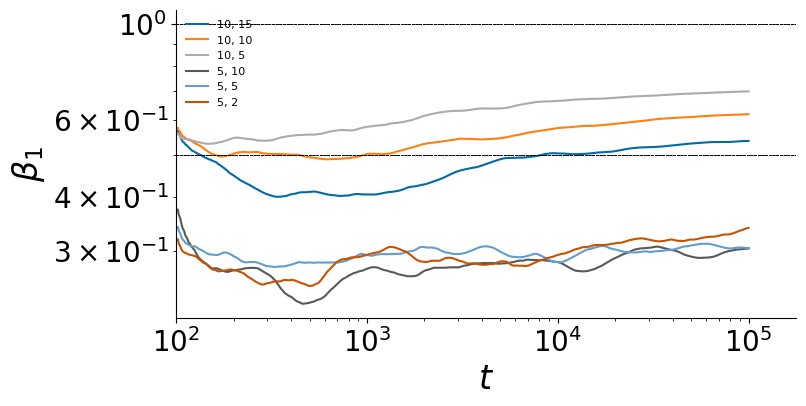

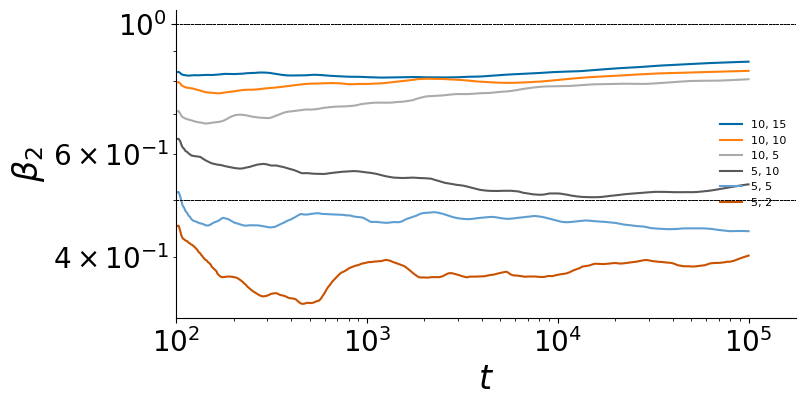

In [188]:
plt.subplots(figsize=(8,4))
for nu_1,nu_2 in [(10,15), (10,10), (10,5), (5,10), (5,5), (5,2)]:
    sim = dataset[0][nu_1][nu_2]
    plt.plot(sim['ts_geom'], sim['average_beta_loglogregr_indices_geom'], label = f"{nu_1}, {nu_2}")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 8)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\beta_1$')
    plt.xlim(left = 1e2)
    plt.axhline(0.5, ls = '--', color = 'black', lw = 0.5)
    plt.axhline(1, ls = '--', color = 'black', lw = 0.5)
plt.subplots(figsize=(8,4))
for nu_1,nu_2 in [(10,15), (10,10), (10,5), (5,10), (5,5), (5,2)]:
    sim = dataset[0][nu_1][nu_2]
    plt.plot(sim['ts_geom'], sim['average_beta2_loglogregr_indices_geom'], label = f"{nu_1}, {nu_2}")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 8)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\beta_2$')
    plt.xlim(left = 1e2)
    plt.axhline(0.5, ls = '--', color = 'black', lw = 0.5)
    plt.axhline(1, ls = '--', color = 'black', lw = 0.5)

# OLD Figure: Higher order exponents in MODEL simulations

## Load data simulations

### Short simulations

In [17]:
path[:path.index("f'")]+path[path.index("f'")+2:]

'./data/UMST/simulations/raw_sequences/rho_20.00000/nu_1/Tmax_100000/eta_1.00000/5.txt'

In [15]:
path = "./data/UMST/simulations/raw_sequences/rho_20.00000/nu_1/Tmax_100000/eta_1.00000/f'5.txt"

In [19]:
os.rename(path, path[:path.index("f'")]+path[path.index("f'")+2:])

In [ ]:
find_pattern("f'", path)

In [20]:
Tmax = int(1e5)
use_scratch = False
results_simulations = {}
print('Simulations found:')
for eta in [1]:#,0.01,0.001,0]:
    for rho in [20]:
        for nu in range(1,21):# min(21,int(rho/eta))):
            workdir = f"./data/UMST/simulations/raw_sequences/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
            for path in find_pattern("*f'*", workdir):
                try:
                    os.rename(path, path[:path.index("f'")]+path[path.index("f'")+2:])
                except:
                    pass

Simulations found:


In [422]:
Tmax = int(1e5)
use_scratch = False
results_simulations = {}
print('Simulations found:')
for eta in [1,0.1]:#,0.01,0.001,0]:
    for rho in [1,2,3,4,5,10,20]:
        for nu in range(1,21):# min(21,int(rho/eta))):
            try:
                workdir = f"./data/simulations/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                workdir_scratch = f"/data/scratch/ahw701/pairs/UMST/simulations/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                if use_scratch == True:
                    with open(f"{workdir_scratch}average_UMT_results.pkl",'rb') as fp:
                        tmp = pickle.load(fp)
                else:
                    if os.path.exists(f"{workdir}average_UMT_light_results.pkl"):
                        with open(f"{workdir}average_UMT_light_results.pkl",'rb') as fp:
                            tmp = pickle.load(fp)
                    else:
                        with open(f"{workdir}average_UMT_light_results_old.pkl",'rb') as fp:
                            tmp = pickle.load(fp)
                if eta not in results_simulations:
                    results_simulations[eta] = {}
                if rho not in results_simulations[eta]:
                    results_simulations[eta][rho] = {}
                results_simulations[eta][rho][nu] = tmp.copy()
                print('eta',eta, 'rho',rho, 'nu',nu, 'num_sim:', len(results_simulations[eta][rho][nu]['beta_loglogregr_indices_geom_list_finals']))
            except:
                pass

Simulations found:
eta 1 rho 20 nu 1 num_sim: 100
eta 1 rho 20 nu 2 num_sim: 100
eta 1 rho 20 nu 3 num_sim: 100
eta 1 rho 20 nu 4 num_sim: 100
eta 1 rho 20 nu 5 num_sim: 100
eta 1 rho 20 nu 6 num_sim: 100
eta 1 rho 20 nu 7 num_sim: 100
eta 1 rho 20 nu 8 num_sim: 100
eta 1 rho 20 nu 9 num_sim: 100
eta 1 rho 20 nu 10 num_sim: 100
eta 1 rho 20 nu 11 num_sim: 100
eta 1 rho 20 nu 12 num_sim: 100
eta 1 rho 20 nu 13 num_sim: 100
eta 1 rho 20 nu 14 num_sim: 100
eta 1 rho 20 nu 15 num_sim: 100
eta 1 rho 20 nu 16 num_sim: 100
eta 1 rho 20 nu 17 num_sim: 100
eta 1 rho 20 nu 18 num_sim: 100
eta 1 rho 20 nu 19 num_sim: 100
eta 1 rho 20 nu 20 num_sim: 100
eta 0.1 rho 4 nu 1 num_sim: 100
eta 0.1 rho 4 nu 2 num_sim: 100
eta 0.1 rho 4 nu 3 num_sim: 100
eta 0.1 rho 4 nu 4 num_sim: 100
eta 0.1 rho 4 nu 5 num_sim: 100
eta 0.1 rho 4 nu 6 num_sim: 100
eta 0.1 rho 4 nu 7 num_sim: 100
eta 0.1 rho 4 nu 8 num_sim: 100
eta 0.1 rho 4 nu 9 num_sim: 100
eta 0.1 rho 4 nu 10 num_sim: 100
eta 0.1 rho 4 nu 11 num_sim: 

### Long simulations

In [88]:
Tmax = int(1e7)
use_scratch = False
results_simulations_long = {}
print('Simulations found:')
for eta in [1,0.1]:#,0.01,0.001,0]:
    for rho in [1,2,3,4,5,10,20]:
        for nu in range(1,21):# min(21,int(rho/eta))):
            try:
                workdir = f"./data/simulations/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                workdir_scratch = f"/data/scratch/ahw701/pairs/UMST/simulations/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                if rho == 20 and eta == 1:
                    for run in range(100):
                        try:
                            os.remove(f"{workdir}UMT_run_{run}.pkl")
                        except:
                            pass
                if use_scratch == True:
                    with open(f"{workdir_scratch}average_UMT_results.pkl",'rb') as fp:
                        tmp = pickle.load(fp)
                else:
                    with open(f"{workdir}average_UMT_light_results.pkl",'rb') as fp:
                        tmp = pickle.load(fp)
                if eta not in results_simulations_long:
                    results_simulations_long[eta] = {}
                if rho not in results_simulations_long[eta]:
                    results_simulations_long[eta][rho] = {}
                results_simulations_long[eta][rho][nu] = tmp.copy()
                if tmp['ts'][-1] == Tmax - 1 or tmp['D_indices'][0] > 1:
                    for _ in ['ts', 'ts_geom', 'indices','indices_geom']:
                        tmp[_] = [1] + list(np.array(tmp[_])+1)
                    for _ in ['D_indices', 'D2_indices', 'D3_indices','D4_indices']:
                        tmp[_] = np.array([1] + list(np.array(tmp[_])+1))
                    
                    for _ in ['ts', 'ts_geom', 'indices','indices_geom']:
                        tmp[_] = [1] + list(np.array(tmp[_])+1)
                    
                print('eta',eta, 'rho',rho, 'nu',nu, 'num_sim:', len(results_simulations_long[eta][rho][nu]['beta_loglogregr_indices_geom_list_finals']))
            except:
                pass

Simulations found:
eta 1 rho 4 nu 1 num_sim: 100
eta 1 rho 4 nu 2 num_sim: 100
eta 1 rho 4 nu 3 num_sim: 100
eta 1 rho 20 nu 1 num_sim: 100
eta 1 rho 20 nu 2 num_sim: 100
eta 1 rho 20 nu 3 num_sim: 100
eta 1 rho 20 nu 4 num_sim: 100
eta 1 rho 20 nu 5 num_sim: 100
eta 1 rho 20 nu 6 num_sim: 100
eta 1 rho 20 nu 7 num_sim: 100
eta 1 rho 20 nu 8 num_sim: 100
eta 1 rho 20 nu 9 num_sim: 100
eta 1 rho 20 nu 10 num_sim: 100
eta 1 rho 20 nu 11 num_sim: 100
eta 1 rho 20 nu 12 num_sim: 100
eta 1 rho 20 nu 13 num_sim: 100
eta 1 rho 20 nu 14 num_sim: 100
eta 1 rho 20 nu 15 num_sim: 100
eta 1 rho 20 nu 16 num_sim: 87
eta 1 rho 20 nu 17 num_sim: 59
eta 1 rho 20 nu 18 num_sim: 29
eta 1 rho 20 nu 19 num_sim: 13
eta 0.1 rho 4 nu 1 num_sim: 100
eta 0.1 rho 4 nu 2 num_sim: 100
eta 0.1 rho 4 nu 3 num_sim: 100
eta 0.1 rho 4 nu 4 num_sim: 100
eta 0.1 rho 4 nu 5 num_sim: 100
eta 0.1 rho 4 nu 6 num_sim: 100
eta 0.1 rho 4 nu 7 num_sim: 99
eta 0.1 rho 4 nu 8 num_sim: 91
eta 0.1 rho 4 nu 9 num_sim: 80
eta 0.1 rho

## Figure SI: Comparison with $\nu/\rho$

### Functions

In [94]:
def fig_comparison_simulation_expected_beta(results_simulations, 
          parameters_by_row, # {'UMT':(eta, rho)}
          marker_size = 20, alpha_scatter = 1, alpha_histogram = 0.3, 
          y_correlation_text = .32, 
          color_x = CB_color_cycle[0], color_y = CB_color_cycle[1], max_hist = 0.25, xlim_left_a = 1, ylim_bottom_a = 1,
          min_beta = 0,
          max_beta = 1,
          min_beta_higher = 0,
          max_beta_higher = 1,
         ):
    num_datasets = len(parameters_a_by_row)
    fig = plt.figure(figsize=(width_fig,width_fig*2/3*num_datasets/3))
    outer = gridspec.GridSpec(nrows=num_datasets+1, ncols=1,height_ratios = [10]*num_datasets+[3],hspace=0.25)
    wspace = 0.38
    ncols = 4
    
    for i, dataset_label in enumerate(parameters_a_by_row.keys()):
        eta, rho = parameters_by_row[dataset_label]
        dataset_dict = {}
        dataset_dict['expected_betas'] = np.array([eta*nu/rho for nu,tmp_nu in results_simulations[eta][rho].items() for _ in tmp_nu["beta_loglogregr_indices_geom_list_finals"]])
        dataset_dict['betas'] = np.array([_ for nu,tmp_nu in results_simulations[eta][rho].items() for _ in tmp_nu["beta_loglogregr_indices_geom_list_finals"]])
        dataset_dict['betas2'] = np.array([_ for nu,tmp_nu in results_simulations[eta][rho].items() for _ in tmp_nu["beta2_loglogregr_indices_geom_list_finals"]])
        dataset_dict['betas3'] = np.array([_ for nu,tmp_nu in results_simulations[eta][rho].items() for _ in tmp_nu["beta3_loglogregr_indices_geom_list_finals"]])
        dataset_dict['betas4'] = np.array([_ for nu,tmp_nu in results_simulations[eta][rho].items() for _ in tmp_nu["beta4_loglogregr_indices_geom_list_finals"]])
        
        inner = gridspec.GridSpecFromSubplotSpec(1, ncols,
                            subplot_spec=outer[i],width_ratios=[1,1,1,1],wspace=wspace)
        if i == num_datasets - 1:
            xlabel = r"$\eta\nu/\rho$"
        else:
            xlabel = None
        
        for i_order, order in enumerate(['', '2', '3', '4']):
            n_order = i_order + 1
            ylabel = fr"$\beta_{n_order}$"
            ax = plt.Subplot(fig, inner[i_order])
            fig_1_subplot_b_d(dataset_dict['expected_betas'], dataset_dict[f'betas{order}'], 
                              ax = ax, 
                              marker_size = 20, alpha_scatter = alpha_scatter,
                              alpha_histogram = alpha_histogram, 
                              color_x = color_x, color_y = color_y, 
                              max_hist = max_hist, number_to_write = i*ncols+i_order,
                              write_number = i == 0, y_correlation_text = y_correlation_text,
                              ylabel = ylabel, xlabel = xlabel, 
                              min_x=min_beta, max_x=max_beta, min_y=min_beta_higher, max_y=max_beta_higher,
                             )
            if i_order == 0:
                ax.text(-0.33, 0.5, f"{dataset_label}", transform=ax.transAxes,fontweight='bold', horizontalalignment='right', verticalalignment='center', rotation = 90)
            fig.add_subplot(ax)
    
    ####################### COLORBAR #######################
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                            subplot_spec=outer[-1],height_ratios=[1,1],hspace=0)
    ax_cmap = plt.Subplot(fig, inner[1])
    vmin = 0
    vmax = 1
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin,vmax=vmax)), ax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation='horizontal')
    cb.ax.get_xaxis().set_ticks([0,1]) 
    cb.ax.get_xaxis().set_ticklabels(['low density', 'high density']) 
    ax_cmap.axis('off')
    fig.add_subplot(ax_cmap)
    
    return fig

### Figure (Tmax = 10^5)

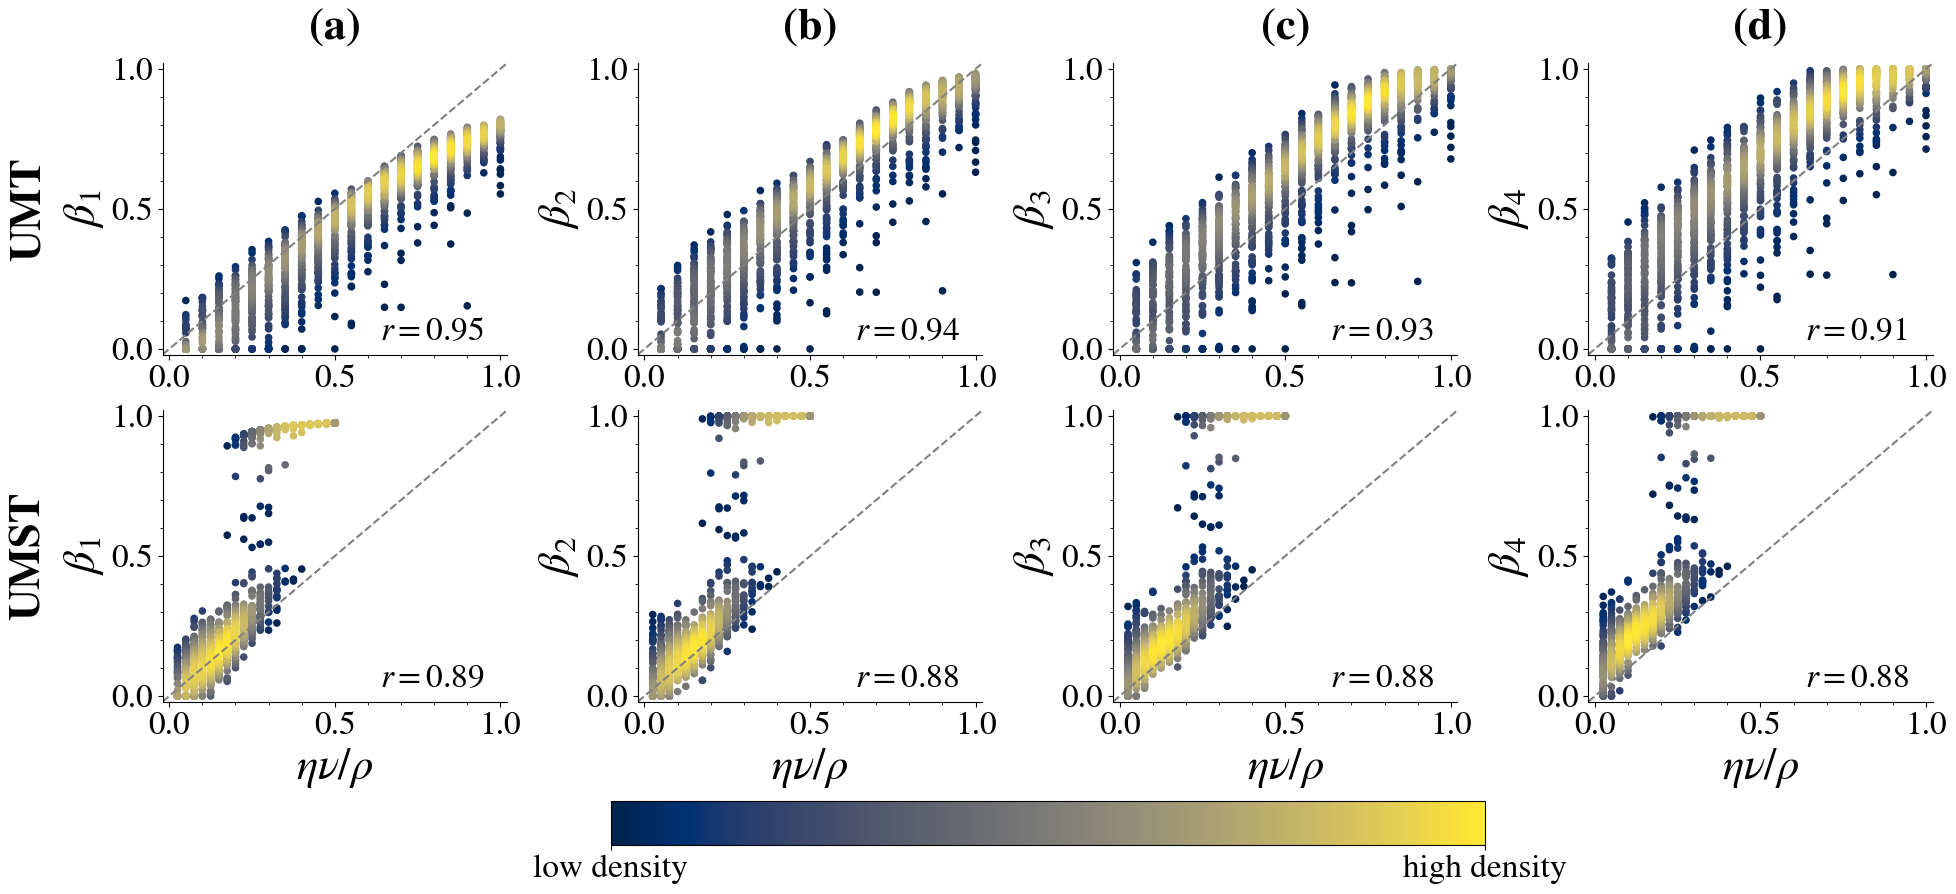

In [95]:
parameters_a_by_row = {'UMT' : (1,20), 'UMST':(.1, 4)}
Tmax = int(1e5)
fig = fig_comparison_simulation_expected_beta(
    results_simulations, 
    parameters_a_by_row,
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0, 
    y_correlation_text = .05,
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.25, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e0,
#     min_beta = -0.02,
#     max_beta = 1.02,
#     min_beta_higher = -0.02,
#     max_beta_higher = 1.02,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
)


fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected.png"%(Tmax)))
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected_low_res.pdf"%(Tmax)),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected.pdf"%(Tmax)),format='pdf')

### Figure (Tmax = 10^7)

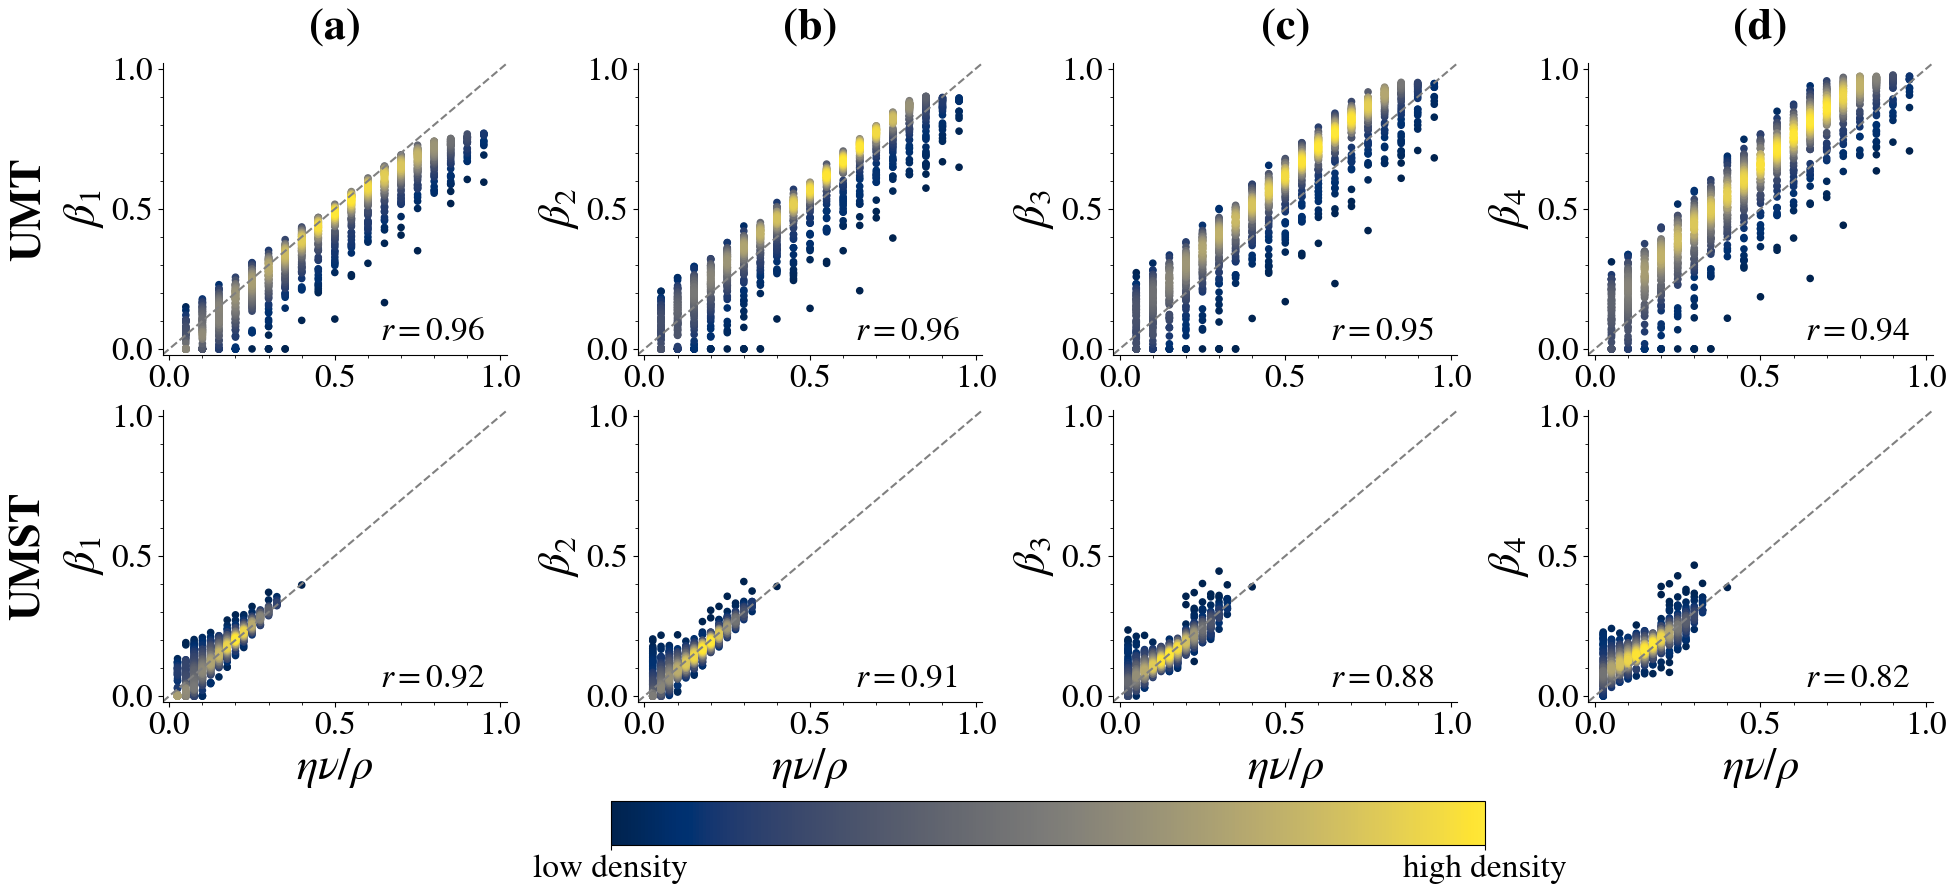

In [96]:
parameters_a_by_row = {'UMT' : (1,20), 'UMST':(.1, 4)}
Tmax = int(1e7)
fig = fig_comparison_simulation_expected_beta(
    results_simulations_long, 
    parameters_a_by_row,
    marker_size = 20, 
    alpha_scatter = 1, 
    alpha_histogram = 0, 
    y_correlation_text = .05,
    color_x = CB_color_cycle[0], 
    color_y = CB_color_cycle[1], 
    max_hist = 0.25, 
    xlim_left_a = 1e2, 
    ylim_bottom_a = 1e0,
#     min_beta = -0.02,
#     max_beta = 1.02,
#     min_beta_higher = -0.02,
#     max_beta_higher = 1.02,
    min_beta = 0,
    max_beta = 1,
    min_beta_higher = 0,
    max_beta_higher = 1,
)


fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected.png"%(Tmax)))
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected_low_res.pdf"%(Tmax)),format='pdf',dpi=100)
fig.savefig(os.path.join(figures_folder, f"FigSI_Heaps_simulations_Tmax_%d_vs_expected.pdf"%(Tmax)),format='pdf')

## Figure: $\beta_1$ vs $t$

### Functions

In [72]:
def fig_3_subplot(results_simulations,
                    parameters_to_plot,  # [(eta, rho, nu)] 
                    order,
                    beginning_index = 100, 
                    ax = None, marker_size = 20, alpha = 1, 
                    number_to_write = 0, 
                    xlim_left = 1e3, xlim_right = 1e7, 
                    ylim_bottom = 0, ylim_top = 1, 
                    ylabel = None, xlabel = None, 
                    do_horizontal_lines = True,
                    write_number = False):
    if ax == None:
        fig, ax = plt.subplots()
    
    if do_horizontal_lines:
        yticks = [0, 1]
    for i, (eta,rho,nu) in enumerate(parameters_to_plot):
#         ax.plot(results_simulations[eta][rho][nu]["ts_geom"][beginning_index:], results_simulations[eta][rho][nu][f"average_beta{order}_loglogregr_indices_geom"][beginning_index:], color=CB_color_cycle[i])
        ax.plot(results_simulations[eta][rho][nu]["ts_geom"][beginning_index:], results_simulations[eta][rho][nu][f"beta{order}_loglogregr_indices_geom"][beginning_index:], color=CB_color_cycle[i])
        expected_beta = float(eta)*float(nu)/rho
        if do_horizontal_lines:
            ax.axhline(expected_beta, ls='--', color=CB_color_cycle[i])
        if do_horizontal_lines and expected_beta not in yticks:
            yticks.append(expected_beta)

        
    ax.set_xlim(left = xlim_left, right = xlim_right)
    ax.set_ylim(bottom = ylim_bottom, top = ylim_top)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_xscale("log")
    # Impose xticks
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=20) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    if do_horizontal_lines:
        # y ticks
        ax.set_yticks(yticks)
    
    if write_number == True:
        ax.text(0.5, 1.08, f"{letters[number_to_write]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='center')
    return ax

In [74]:
def fig_3(results_simulations, 
          parameters_to_plot, # [(eta, rho, nu)] 
          marker_size = 20, alpha = 1, 
          beginning_index = 100, 
          xlim_left = 1e3, xlim_right = 1e7, 
          min_beta = 0,
          max_beta = 1,
          do_horizontal_lines = True,
         ):
    fig, axes = plt.subplots(1,4,figsize=(width_fig,width_fig*2/3*1/3), gridspec_kw={'wspace':0.38})
    
    for i_order, order in enumerate(['', '2', '3', '4']):
        n_order = i_order + 1
        ax = axes[i_order]
        ax = fig_3_subplot(results_simulations,
                    parameters_to_plot, 
                    order,
                    beginning_index = beginning_index, 
                    ax = ax, alpha = 1, 
                    number_to_write = i_order, do_horizontal_lines = do_horizontal_lines, 
                    xlim_left = xlim_left, xlim_right = xlim_right, 
                    ylim_bottom = 0, ylim_top = 1, 
                    ylabel = fr"$\beta_{n_order}(t)$", xlabel = r"$t$", 
                    write_number = True)

    labels = []
    for i, (eta,rho,nu) in enumerate(parameters_to_plot):
        labels.append(r"$\rho=%d$"%rho+", "+r"$\nu=%d$"%nu+", "+r"$\eta=%s$"%str(eta))
    leg = ax.legend(
        [(color,"--",True) for color in CB_color_cycle[:4]], labels, 
                         handler_map={tuple: continuous_and_dashed_line_handle()},
        handletextpad=0.1, bbox_to_anchor=(0.5, -0.05), loc='upper center', bbox_transform=fig.transFigure, ncol=len(list(range(len(parameters_to_plot),20,len(parameters_to_plot))))+1)
    
    return fig

### Figure

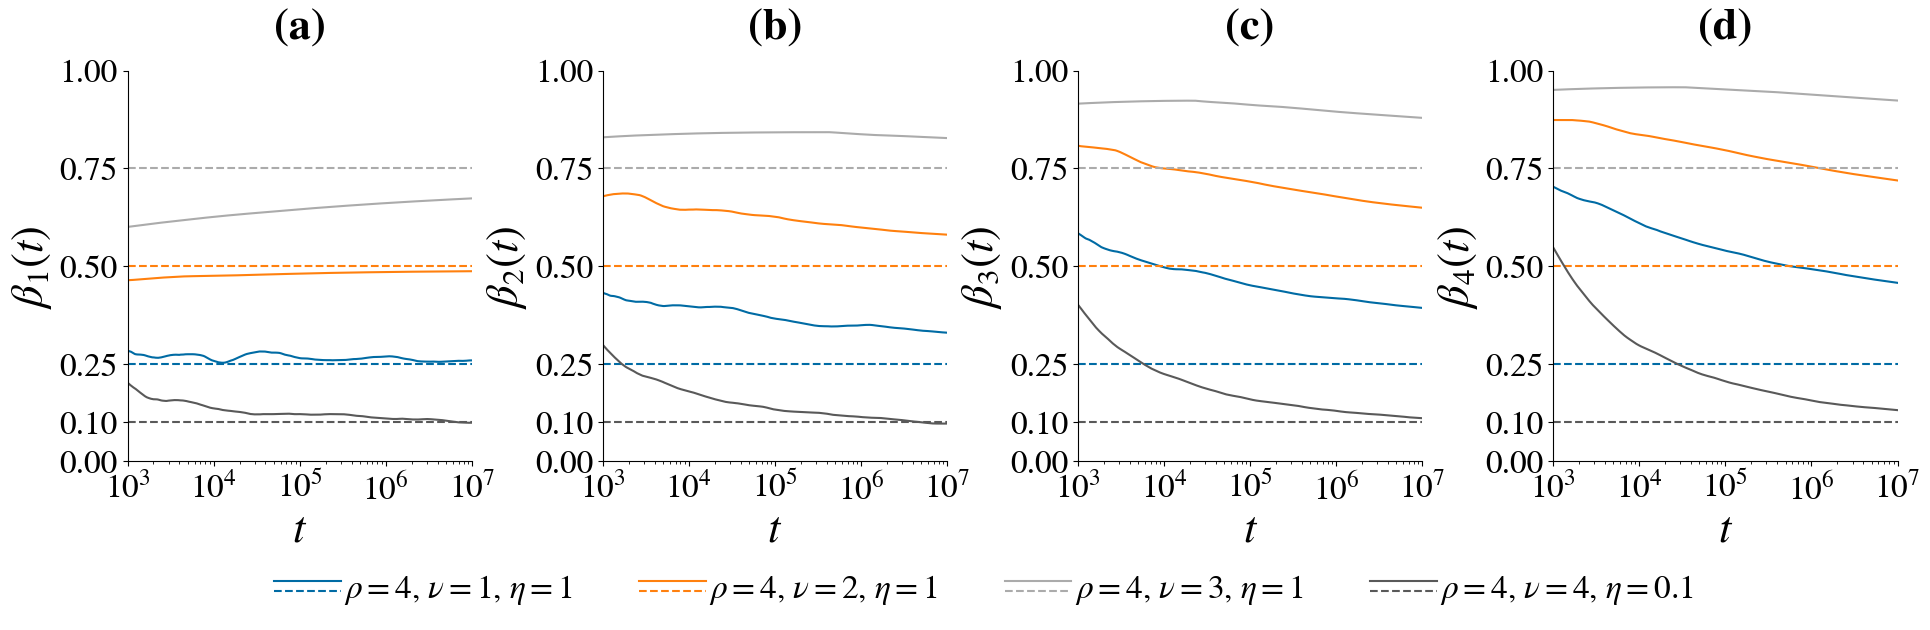

In [106]:
# parameters_to_plot = [(.1, 4, 4), (1, 20, 5), (1, 20, 10), (1, 20, 15)]
parameters_to_plot = [(1, 4, 1), (1, 4, 2), (1, 4, 3),(.1, 4, 4),]
fig = fig_3(
    results_simulations_long, 
    parameters_to_plot, # [(eta, rho, nu)] 
    marker_size = 20, alpha = 1, 
    beginning_index = 100, 
    min_beta = 0,
    max_beta = 1,
)
fig.savefig(os.path.join(figures_folder, f"Fig3_beta_changing_UMT_UMST_rho_4.png"))
fig.savefig(os.path.join(figures_folder, f"Fig3_beta_changing_UMT_UMST_rho_4.pdf"))

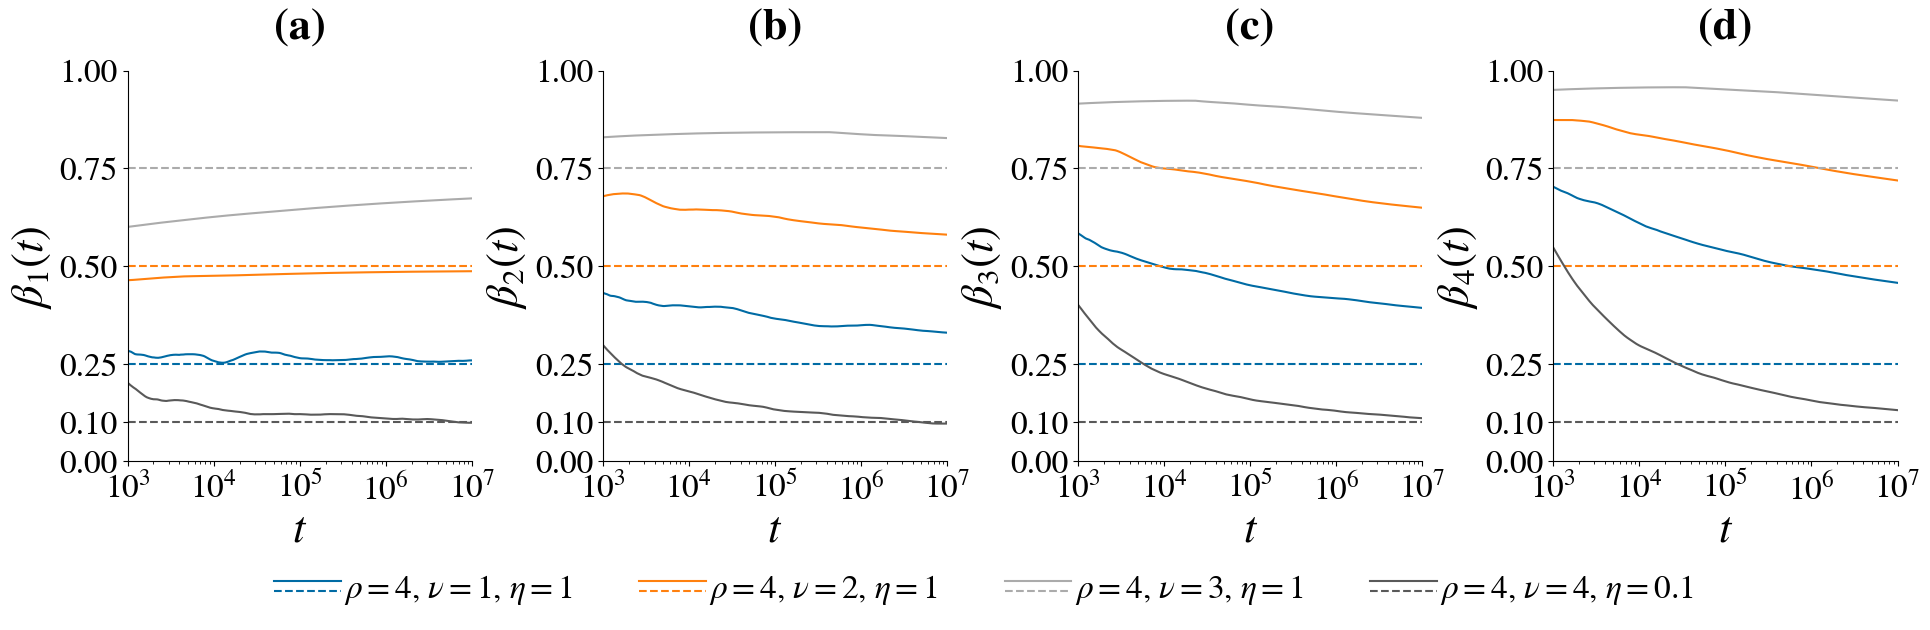

In [107]:
# parameters_to_plot = [(.1, 4, 4), (1, 20, 5), (1, 20, 10), (1, 20, 15)]
parameters_to_plot = [(1, 4, 1), (1, 4, 2), (1, 4, 3),(.1, 4, 4),]
fig = fig_3(
    results_simulations_long, 
    parameters_to_plot, # [(eta, rho, nu)] 
    marker_size = 20, alpha = 1, 
    beginning_index = 100, 
    min_beta = 0,
    max_beta = 1,
)
fig.savefig(os.path.join(figures_folder, f"Fig3_beta_changing_UMT_UMST_rho_4_fit_of_average.png"))
fig.savefig(os.path.join(figures_folder, f"Fig3_beta_changing_UMT_UMST_rho_4_fit_of_average.pdf"))

# Figure5: UMT numeric vs analytical

## Load simulations

In [ ]:
Tmax = int(1e7)
results_simulations_long = {}
print('Simulations found:')
for eta in [1,0.1]:#,0.01,0.001,0]:
    for rho in [1,2,3,4,5,10,20]:
        for nu in range(1,21):# min(21,int(rho/eta))):
            try:
                workdir = f"./data/UMST/simulations/analysis/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                with open(f"{workdir}average_UMT_light_results.pkl",'rb') as fp:
                    tmp = pickle.load(fp)
                if eta not in results_simulations_long:
                    results_simulations_long[eta] = {}
                if rho not in results_simulations_long[eta]:
                    results_simulations_long[eta][rho] = {}
                results_simulations_long[eta][rho][nu] = tmp.copy()
                if tmp['ts'][-1] == Tmax - 1 or tmp['D_indices'][0] > 1:
                    for _ in ['ts', 'ts_geom', 'indices','indices_geom']:
                        tmp[_] = [1] + list(np.array(tmp[_])+1)
                    for _ in ['D_indices', 'D2_indices', 'D3_indices','D4_indices']:
                        tmp[_] = np.array([1] + list(np.array(tmp[_])+1))
                    
                    for _ in ['ts', 'ts_geom', 'indices','indices_geom']:
                        tmp[_] = [1] + list(np.array(tmp[_])+1)
                print('eta',eta, 'rho',rho, 'nu',nu, 'num_sim:', len(results_simulations_long[eta][rho][nu]['beta_loglogregr_indices_geom_list_finals']))
            except:
                pass

## Pairs

### Functions

In [ ]:
def fit_to_str(a,b,c,d):
#     return r"$%.1f t^{%.2f+%.1f/(%.1f+\log_2(t))}$"%(a,b,c,d)
    return r"$%.1f t^{%.2f+\frac{%.1f}{%.1f+\log_2(t)}}$"%(a,b,c,d)

def get_dD2(analytic_data, nu, rho, ax, fontsize=16, print_all_legend_labels = True, use_approximated=True):
    """
    Takes the analytic data and finds a fit of the type a * x ** (b+c/(d+np.log2(x))). 
    If it does not give ERROR (a), it does not impose any constraint on b.
    """
    xs = np.array(list(analytic_data.t))
    Cs = np.array(list(analytic_data.data))
    beta_1 = float(nu)/rho
    b = (rho - nu)**beta_1
    factors = b * beta_1 * (xs ** (beta_1 - 1))
    ys = 2*factors - factors*factors + (1-factors)**2 * Cs
    if use_approximated:
        ys = 2*factors + Cs

    e=1
    f=0
    
    def func(x,a,b,c,d):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    xs_log = np.log2(xs)
    ys_log = np.log2(ys)
    try:
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,p0=[1,nu/rho-1,1,1], bounds=([0,-1,0,0], [np.inf,0,np.inf,np.inf]))
    except RuntimeError as er:
        print('ERROR (a)',er)
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,bounds=([0,nu/rho-0.000000001-1,0,0.1], [np.inf,nu/rho+0.000000001-1,np.inf,np.inf]))
    a,b,c,d = popt_log_B
    b_old = b
    residuals = ys - func(xs, *popt_log_B)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = ys_log - func_log(xs_log, *popt_log_B)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(ys)
    R_squared_log = 1-(ss_res_log**2)/np.var(ys_log)

    exponents_log = np.array([b+c*d/((d+np.log2(e*x))**2) for x in xs])

    return popt_log_B

In [ ]:
def exp_to_str(a,b,c,d):
#    return r"$%.2f+%.1f/(%.1f+\log_2(t))$"%(b,c,d)
    return r"$%.2f+\frac{%.1f}{%.1f+\log_2(t)}$"%(np.round(b,decimals=2),np.round(c, decimals=1),np.round(d, decimals=1))
    
def get_D2(analytic_data,mean_urn, popt_log_B, nu, rho, ax, expMin=0, expMax=16, fontsize=16, 
            print_all_legend_labels = True,
            use_odeint = False,
           ):
    """
    Takes the fitted analytic function to dD2 analytic data and integrates it analytically.
    Then, it is both fitted with the power law function as in the simulations, and fitted to a similar function type as done with dD2, 
    i.e. of the type a * x ** (b+c/(d+np.log2(x))).  If it does not give ERROR (b), it does not impose any constraint on b.
    
    A similar analytical fit is done for the data from the simulations (using ts_geom >= 10**exmMin and D2 in loglog), 
    i.e. of the type a * x ** (b+c/(d+np.log2(x))).  If it does not give ERROR (c), it does not impose any constraint on b.
    
    if use_odeint == False, instead of integrating analytically, the new function is given by the same parameters obtained for dD2, 
    with just b += 1 and a /= b
    """
    from scipy.integrate import odeint
    e=1
    f=0
    def func(x,a,b,c,d):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    t0 = 1 
    y0 = 1 
    ts_system = np.geomspace(t0,10**expMax,10000)
    if use_odeint == True:
        # y'(t) = func(t,a,b,c,d)
        def system(y, t, *popt_log_B):
            dy = [func(t,*popt_log_B)]
            return dy
        a,b,c,d = popt_log_B
        sol = odeint(system, y0 , ts_system, args=(a,b,c,d))
        sol = np.transpose(sol)[0]
    else:
        a,b,c,d = popt_log_B
        b += 1
        a /= b
        sol = func(ts_system,a,b,c,d)
        popt_log = (a,b,c,d)
        sol = sol - sol[0] + 1
    
    last_to_check = 100
    mean_urn["new_analytic2_loglogregr_points"] = np.array([powerLawRegrPoints(ts_system[max(0,i-last_to_check):i], sol[max(0,i-last_to_check):i])[0]
                                               for i in range(last_to_check,len(ts_system))])
    mean_urn["new_analytic2_loglogregr_points_xs"] = ts_system[last_to_check:]

    if print_all_legend_labels:
        label1 = r"equation"
    else:
        label1 = ""

    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.log2(ts_system)
    sol_log = np.log2(sol)
    if use_odeint == True:
        try:
            raise RuntimeError
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1], bounds=([0,0,0,0], [np.inf,1,np.inf,np.inf]))
        except RuntimeError as er:
            print('ERROR (b)',er)
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1],bounds=([0,float(nu)/rho-0.000000001,0,0.1], [np.inf,nu/rho+0.000000001,np.inf,np.inf]))
        a,b,c,d = popt_log
    b_free = b
    exp_law_free = exp_to_str(a,b,c,d)
    residuals = sol - func(ts_system, *popt_log)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = sol_log - func_log(ts_log, *popt_log)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(sol)
    R_squared_log = 1-(ss_res_log**2)/np.var(sol_log)
    label2 = 'an.fit: %s'%fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    print(label2)

    exponents_eq = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])
    
    mean_urn['eq_fit_beta2_xs'] = ts_system
    mean_urn['eq_fit_beta2'] = exponents_eq

    
    if print_all_legend_labels:
        label3 = r"simulation"
    else:
        label3 = ""
    
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.array([np.log2(_) for _ in mean_urn["ts_geom"][1:]-1 if np.log10(_) >= expMin])
    D2_indices_log = np.array([np.log2(_) for i_,_ in enumerate(mean_urn["D2_indices"][mean_urn['indices_geom']][1:]) if np.log10(mean_urn["ts_geom"][1:]-1)[i_] >= expMin])
    try:
        raise RuntimeError
        popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,p0=[1,float(nu)/rho,1,1],bounds=([0,0,0,0], [np.inf,1,np.inf,np.inf]))
    except RuntimeError as er:
        print('ERROR (c)',er)
        popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,p0=[1,float(nu)/rho,1,1],bounds=([0,nu/rho-0.000000001,0,0], [np.inf,nu/rho+0.000000001,np.inf,np.inf]))
    a,b,c,d = popt_sim 
    b_sim = b
    exp_law_sim = exp_to_str(a,b,c,d)
    residuals = mean_urn["D2_indices"][mean_urn['indices_geom']][1:] - func(mean_urn["ts_geom"][1:]-1, *popt_sim)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = D2_indices_log - func_log(ts_log, *popt_sim)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(mean_urn["D2_indices"][mean_urn['indices_geom']][1:])
    R_squared_log = 1-(ss_res_log**2)/np.var(D2_indices_log)
    label4 = 'an.fit: %s'%fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    print(label4)
    exponents_sim = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system]) # mean_urn["ts_geom"][1:]-1])
    
    mean_urn['sim_fit_beta2_xs'] = ts_system # mean_urn["ts_geom"][1:]-1])
    mean_urn['sim_fit_beta2'] = exponents_sim

    return mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_free, exp_law_sim

In [ ]:
def final_plot_fits(urn, nu, rho, ax, exp_law_free, exp_law_sim,fontsize=16, print_all_legend_labels = True, max_num_major_xticks = 5):
    ax.axhline(nu/rho,ls="--",color="gray",lw=3,label=r"$\nu/\rho=%.2f$"%(nu/rho))
#     ax.plot(urn["ts_geom"][100:]-1, np.array(urn["beta2_loglogregr_indices_geom"])[100:],lw=3, color = CB_color_cycle[1], 
#             label = "power-law fit simul." if print_all_legend_labels else None) # label = r"$\beta_2(t)$ (sim. p.l. fit)")
    ax.plot(urn["sim_fit_beta2_xs"], np.array(urn["sim_fit_beta2"]),ls='-',lw=3, color = None, #"red", #CB_color_cycle[1], 
            label = f"simulation" if print_all_legend_labels else None)
#             label = fr"{exp_law_sim}") # label = r"$\beta_2(t)$ (sim. an. fit)")
#     ax.plot(urn["new_analytic2_loglogregr_points_xs"],np.array(urn["new_analytic2_loglogregr_points"]),lw=3, color = CB_color_cycle[0], 
#             label = "power-law fit Eq. 9" if print_all_legend_labels else None) # label = r"$\beta_2(t)$ (eq. p.l. fit)")
    ax.plot(urn["eq_fit_beta2_xs"], np.array(urn["eq_fit_beta2"]),ls='-',lw=3, color = None, #"blue", #CB_color_cycle[0], 
            label = f"analytical" if print_all_legend_labels else None)
#             label = fr"{exp_law_free}") # label = r"$\beta_2(t)$ (eq. an. fit)")
#     if print_all_legend_labels:
    if nu/rho > 0.4:
        ax.legend(fontsize=fontsize, loc = "lower right", bbox_to_anchor = (1,-0.04), labelspacing = 0.3,)
    else:
        print('CCC')
        ax.legend(fontsize=fontsize, loc = "upper right", bbox_to_anchor = (1,1.04), labelspacing = 0.3,)

    
    ax.set_xlim((100,Tmax))
    ax.set_ylim((0,1.01))
    ax.set_xscale("log")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\beta_2(t)$" if print_all_legend_labels else None)
    # Impose xticks
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
    ax.xaxis.set_major_locator(locmaj)
    # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
    locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    return None

In [ ]:
def simulation_vs_analytic_plot(rho, results_simulations,
                                fontsize_legend=16, lower_bound = 1e3, upper_bound = 1e7, 
                                use_approximated=True, expMin=3, expMax=7, 
                                max_num_major_xticks = 5, 
                                use_odeint=False,):
    ncols = rho - 1
    Tmax = int(1e7)
    eta = 1
    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower()
    fig, axes = plt.subplots(1,rho-1,figsize=(width_fig*ncols/3,width_fig*2/3/3*9/10), gridspec_kw={'hspace':.35,'wspace':0.25})
    
    
    for counter,nu in enumerate(range(1,rho)):
        print(nu)
        ax = axes[counter]
        if counter== 0:
            print_all_legend_labels = True
        else:
            print_all_legend_labels = False
        mean_urn = results_simulations[eta][rho][nu]
        indices = mean_urn["indices"]
        indices_geom = mean_urn["indices_geom"]
        ts = mean_urn["ts"]
        ts_geom = mean_urn["ts_geom"]

        if expMax <= 7:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{expMin}_expMax{expMax}_data.csv",names=["t","data"])
        else:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{3}_expMax{7}_data.csv",names=["t","data"])
            analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{7}_expMax{10}_data.csv",names=["t","data"])
            analytic_data2.drop(analytic_data2.index[0], inplace=True)
            analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            if expMax > 10:
                analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{10}_expMax{20}_data.csv",names=["t","data"])
                analytic_data2.drop(analytic_data2.index[0], inplace=True)
                analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            analytic_data = analytic_data[analytic_data.t <= 10**expMax]
        
        popt_log_B = get_dD2(analytic_data, nu, rho, ax, fontsize=fontsize_legend, print_all_legend_labels=True,use_approximated=use_approximated)
        results_simulations[eta][rho][nu]['parameters_dD2'] = popt_log_B

        mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_eq, exp_law_sim = get_D2(
            analytic_data, mean_urn, popt_log_B, nu, rho, ax, 
            expMin=expMin, expMax=expMax,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            use_odeint = use_odeint, 
        )

        final_plot_fits(
            mean_urn, nu, rho, ax, exp_law_eq, exp_law_sim,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            max_num_major_xticks = max_num_major_xticks, 
        )
        
#         if nu != 1:
#             ax.legend( [r"$\nu/\rho=%.2f$"%(nu/rho)], loc='lower right', fontsize=fontsize_legend, )#[ax.plot([],[],ls="--",color="gray",lw=3)],
        ax.text(0.05, 1, f"{letters[counter]}", transform=ax.transAxes,fontweight='bold', horizontalalignment='left', verticalalignment='bottom')
        ax.set_xlim(lower_bound, upper_bound)
#         ax.set_xticks([10**3, 10**5, 10**7])
        counter += 1
        
    if use_odeint == True:
        fig.savefig(os.path.join(figures_folder, f"Fig5_UMT_numeric_vs_analytic_rho_%d_expMin_%d_expMax_%d_odeint.png"%(rho, expMin, expMax)))
        fig.savefig(os.path.join(figures_folder, f"Fig5_UMT_numeric_vs_analytic_rho_%d_expMin_%d_expMax_%d_odeint.pdf"%(rho, expMin, expMax)))
    else:
        fig.savefig(os.path.join(figures_folder, f"Fig5_UMT_numeric_vs_analytic_rho_%d_expMin_%d_expMax_%d_from_dD2.png"%(rho, expMin, expMax)))
        fig.savefig(os.path.join(figures_folder, f"Fig5_UMT_numeric_vs_analytic_rho_%d_expMin_%d_expMax_%d_from_dD2.pdf"%(rho, expMin, expMax)))
        
    return(results_simulations)

### Figures

expMax must be 16, because after 16 there is a change in behaviour in the numerical results of the integral done in Mathematica (referring to $C(t)$ in the main paper), either because of working precision errors or similar issues.

In [ ]:
rho = 4
expMin = 2
expMax = 16
results_simulations_long = simulation_vs_analytic_plot(
    rho, results_simulations_long,fontsize_legend=20,
    lower_bound = 10**4, upper_bound = 10**expMax,
    expMin=expMin,expMax=expMax,
    use_odeint=True, 
    max_num_major_xticks = 5, 
    use_approximated=True,
)

1
ERROR (b) 
an.fit: $1.1 t^{0.25+\frac{5.5}{18.2+\log_2(t)}}$
$SER$=0.01, $R^2=1.00$
ERROR (c) 
an.fit: $1.0 t^{0.25+\frac{7.2}{16.1+\log_2(t)}}$
$SER$=0.01, $R^2=1.00$
CCC
2
ERROR (b) 
an.fit: $1.6 t^{0.50+\frac{6.5}{14.6+\log_2(t)}}$
$SER$=0.07, $R^2=1.00$
ERROR (c) 
an.fit: $0.6 t^{0.50+\frac{7.5}{18.3+\log_2(t)}}$
$SER$=0.01, $R^2=1.00$
3
ERROR (b) 
an.fit: $0.7 t^{0.75+\frac{8.6}{13.4+\log_2(t)}}$
$SER$=0.05, $R^2=1.00$
ERROR (c) 
an.fit: $0.7 t^{0.75+\frac{8.1}{46.4+\log_2(t)}}$
$SER$=0.00, $R^2=1.00$


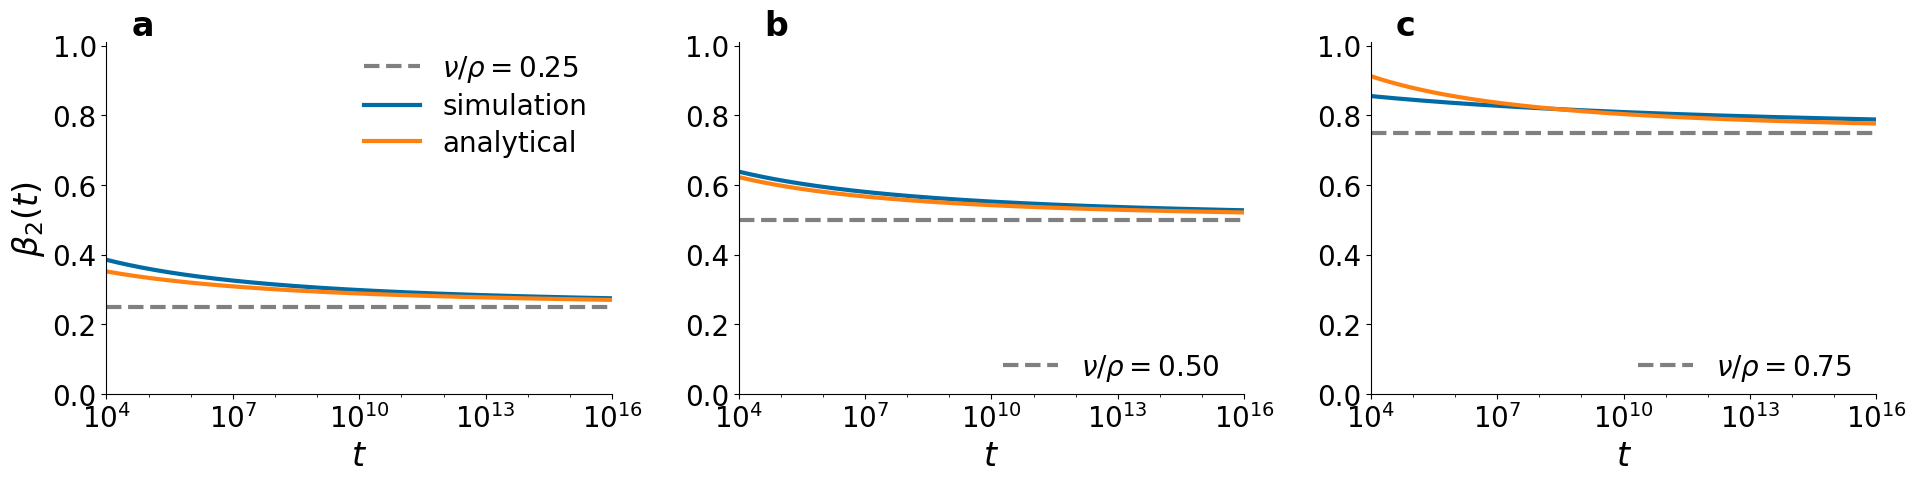

In [31]:
rho = 4
expMin = 2
expMax = 16
results_simulations_long = simulation_vs_analytic_plot(
    rho, results_simulations_long,fontsize_legend=20,
    lower_bound = 10**4, upper_bound = 10**expMax,
    expMin=expMin,expMax=expMax,
    use_odeint=True, 
    max_num_major_xticks = 5, 
    use_approximated=True,
)

## Figure SI: more details

### Pairs

#### Functions

In [ ]:
def fit_to_str(a,b,c,d):
#     return r"$%.1f t^{%.2f+%.1f/(%.1f+\log_2(t))}$"%(a,b,c,d)
    return r"$%.1f t^{%.2f+\frac{%.1f}{%.1f+\log_2(t)}}$"%(a,b,c,d)

def plot_dD2_SI(analytic_data, nu, rho, ax, fontsize=16, print_all_legend_labels = True, use_approximated=True):
    xs = np.array(list(analytic_data.t))
    Cs = np.array(list(analytic_data.data))
    beta_1 = float(nu)/rho
    b = (rho - nu)**beta_1
    factors = b * beta_1 * (xs ** (beta_1 - 1))
    ys = 2*factors - factors*factors + (1-factors)**2 * Cs
    if use_approximated:
        ys = 2*factors + Cs

    e=1
    f=0
    
    def func(x,a,b,c,d):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    if print_all_legend_labels:
        ax.plot(xs,ys, lw=3, label=r"$\nu = %d, \, \rho = %d$"%(nu,rho), color = CB_color_cycle[0],)
    else:
        ax.plot(xs,ys, lw=3, color = CB_color_cycle[0],) 
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    xs_log = np.log2(xs)
    ys_log = np.log2(ys)
    try:
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,p0=[1,nu/rho-1,1,1], bounds=([0,-1,0,0], [np.inf,0,np.inf,np.inf]))
    except RuntimeError as er:
        print('ERROR (a)',er)
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,bounds=([0,nu/rho-0.000000001-1,0,0.1], [np.inf,nu/rho+0.000000001-1,np.inf,np.inf]))
    a,b,c,d = popt_log_B
    b_old = b
    residuals = ys - func(xs, *popt_log_B)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = ys_log - func_log(xs_log, *popt_log_B)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(ys)
    R_squared_log = 1-(ss_res_log**2)/np.var(ys_log)
    ax.plot(xs, func(xs,*popt_log_B), '--', color = "blue", #CB_color_cycle[0],
             label=fit_to_str(a,b,c,d) + 
            "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log))

    exponents_log = np.array([b+c*d/((d+np.log2(e*x))**2) for x in xs])

    ax.set_xscale("log")
    ax.set_yscale("log")
    if nu/rho < 0.:
        ax.legend(fontsize=fontsize, loc = "upper right") 
    else:
        ax.legend(fontsize=fontsize, loc = "lower left")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\mathrm{d}D_2(t)/\mathrm{d}t}$")
    
    return popt_log_B

In [ ]:
def exp_to_str(a,b,c,d):
#     return r"$%.2f+%.1f/(%.1f+\log_2(t))$"%(b,c,d)
    return r"$%.2f+\frac{%.1f}{%.1f+\log_2(t)}$"%(np.round(b,decimals=2),np.round(c, decimals=1),np.round(d, decimals=1))
    
def plot_D2_SI(analytic_data,mean_urn, popt_log_B, nu, rho, ax, expMax=16, fontsize=16, 
            print_all_legend_labels = True,
            use_odeint = False,
           ):
    def func(x,a,b,c,d,e=1,f=0):#,x2):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    t0 = 1 
    y0 = 1 
    e=1
    f=0
    ts_system = np.geomspace(t0,10**expMax,10000)
    if use_odeint == True:
        # y'(t) = func(t,a,b,c,d)
        def system(y, t, *popt_log_B):
            dy =  [func(t,*popt_log_B)]
            return dy
        a,b,c,d = popt_log_B
        sol = odeint(system, y0 , ts_system, args=(a,b,c,d))
        sol = np.transpose(sol)[0]
    else:
        a,b,c,d = popt_log_B
        b += 1
        a /= b
        sol = func(ts_system,a,b,c,d)
        popt_log = (a,b,c,d)
        sol = sol - sol[0] + 1
    
    last_to_check = 100
    mean_urn["new_analytic2_loglogregr_points"] = np.array([powerLawRegrPoints(ts_system[max(0,i-last_to_check):i], sol[max(0,i-last_to_check):i])[0]
                                               for i in range(last_to_check,len(ts_system))])
    mean_urn["new_analytic2_loglogregr_points_xs"] = ts_system[last_to_check:]


    if print_all_legend_labels:
        label1 = r"equation"
    else:
        label1 = ""
    p1, = ax.plot(ts_system,sol, label=label1, lw=3, color = CB_color_cycle[0],)
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.log2(ts_system)
    sol_log = np.log2(sol)
    if use_odeint == True:
        try:
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1], bounds=([0,0,0,0], [np.inf,1,np.inf,np.inf]))
        except RuntimeError as er:
            print('ERROR (b)',er)
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1],bounds=([0,float(nu)/rho-0.000000001,0,0.1], [2,nu/rho+0.000000001,100,100]))
        a,b,c,d = popt_log
    b_free = b
    exp_law_free = exp_to_str(a,b,c,d)
    residuals = sol - func(ts_system, *popt_log)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = sol_log - func_log(ts_log, *popt_log)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(sol)
    R_squared_log = 1-(ss_res_log**2)/np.var(sol_log)
    label2 = fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    p2, = ax.plot(ts_system, func(ts_system,*popt_log), '--', color = "blue", #CB_color_cycle[0], 
                  label=label2)
    exponents_eq = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])
    
    mean_urn['eq_fit_beta2_xs'] = ts_system
    mean_urn['eq_fit_beta2'] = exponents_eq

    
    if print_all_legend_labels:
        label3 = r"simulation"
    else:
        label3 = ""
    
    p3, = ax.plot(mean_urn["ts_geom"][1:]-1,mean_urn["D2_indices"][mean_urn['indices_geom']][1:], label=label3, lw=3, color = CB_color_cycle[1],)
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.log2(mean_urn["ts_geom"][1:]-1)
    D2_indices_log = np.log2(mean_urn["D2_indices"][mean_urn['indices_geom']][1:])
    try:
        raise RuntimeError
        popt_sim, pcov = curve_fit(func_log, ts_log[30:], D2_indices_log[30:],p0=[1,float(nu)/rho,1,1],bounds=([0,0,0,0], [2,1,1000,1000]))
    except RuntimeError as er:
        print('ERROR (c)',er)
        popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,p0=[1,float(nu)/rho,1,1],bounds=([0,nu/rho-0.000000001,0,0], [np.inf,nu/rho+0.000000001,np.inf,np.inf]))
    a,b,c,d = popt_sim 
    b_sim = b
    exp_law_sim = exp_to_str(a,b,c,d)
    residuals = mean_urn["D2_indices"][mean_urn['indices_geom']][1:] - func(mean_urn["ts_geom"][1:]-1, *popt_sim)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = D2_indices_log - func_log(ts_log, *popt_sim)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(mean_urn["D2_indices"][mean_urn['indices_geom']][1:])
    R_squared_log = 1-(ss_res_log**2)/np.var(D2_indices_log)
    label4 = fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    # USE same as system
#     p4, = ax.plot(mean_urn["ts_geom"], func(mean_urn["ts_geom"],*popt_sim), '--', color = "red", #CB_color_cycle[1],
    p4, = ax.plot(ts_system, func(ts_system,*popt_sim), '--', color = "red", #CB_color_cycle[1],
             label=label4)
    exponents_sim = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])# mean_urn["ts_geom"]])
    
    mean_urn['sim_fit_beta2_xs'] = ts_system# mean_urn['ts_geom']
    mean_urn['sim_fit_beta2'] = exponents_sim

#     # REPEAT FOR D
    
#     ts_log = np.log2(mean_urn["ts_geom"])
#     D_indices_log = np.log2(mean_urn["D_indices"][mean_urn["indices_geom"]])
#     # popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,bounds=([0,0,0,0], [10,1,100,100]))
#     try:
#         raise RuntimeError
# #         popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,p0=[1,nu/rho,1,1],bounds=([0,0,0,0], [1,1,np.inf,np.inf]))
#         popt_sim, pcov = curve_fit(func_log, ts_log, D_indices_log,p0=[1,nu/rho,1,1],bounds=([0.9,0,0,0], [1,np.inf,np.inf,np.inf]))
#     except RuntimeError as er:
#         print('ERROR (d)',er)
#         popt_sim, pcov = curve_fit(func_log, ts_log, D_indices_log,p0=[1,nu/rho,1,1],bounds=([0,nu/rho-0.000000001,0,0], [np.inf,nu/rho+0.000000001,np.inf,np.inf]))
#     a,b,c,d = popt_sim # [2.30976089, -0.52648358,  4.94643769,  7.35037396]
#     b_sim = b
#     exp_law_sim = exp_to_str(a,b,c,d)
# #     print(popt_sim)
#     residuals = mean_urn["D2_indices"][mean_urn["indices_geom"]] - func(mean_urn["ts_geom"], *popt_sim)
#     ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
#     residuals = D_indices_log - func_log(ts_log, *popt_sim)
#     ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
#     R_squared = 1-(ss_res**2)/np.var(mean_urn["D2_indices"][mean_urn["indices_geom"]])
#     R_squared_log = 1-(ss_res_log**2)/np.var(D2_indices_log)
#     labelD = 'fit: %s'%fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
#     exponents_simD = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])# mean_urn["ts_geom"]])

#     mean_urn['sim_fit_beta_xs'] = ts_system# mean_urn["ts_geom"]
#     mean_urn['sim_fit_beta'] = exponents_simD
    
    
    ax.set_xlim(left=100, right = 1e7)
    ax.set_ylim(bottom=1, top=1e7)
    
    if nu/rho < 0.4:
        ax.legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) # loc = "upper left")
    else:
        if print_all_legend_labels:
            l1 = ax.legend([p1, p2],[label1,label2], fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) #, loc="upper left")
            l2 = ax.legend([p3, p4],[label3,label4], fontsize=fontsize, loc='lower right', bbox_to_anchor=(1.04, 0)) # , loc="lower right")
        else:
            l1 = ax.legend([p2],[label2], fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) #, loc="upper left")
            l2 = ax.legend([p4],[label4], fontsize=fontsize, loc='lower right', bbox_to_anchor=(1.04, 0)) # , loc="lower right")
        ax.add_artist(l1)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$D_2(t)$")

    return mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_free, exp_law_sim

In [ ]:
def final_plot_fits(urn, nu, rho, ax, exp_law_free, exp_law_sim,fontsize=16, print_all_legend_labels = True, max_num_major_xticks = 5):
    ax.axhline(nu/rho,ls="--",color="gray",lw=3,label=r"$\nu/\rho=%.2f$"%(nu/rho))
    ax.plot(urn["new_analytic2_loglogregr_points_xs"],np.array(urn["new_analytic2_loglogregr_points"]),lw=3, color = CB_color_cycle[0], 
            label = "power-law fit Eq. 9" if print_all_legend_labels else None) # label = r"$\beta_2(t)$ (eq. p.l. fit)")
    ax.plot(urn["eq_fit_beta2_xs"], np.array(urn["eq_fit_beta2"]),ls='--',lw=2, color = "blue", #CB_color_cycle[0], 
            label = fr"{exp_law_free}") # label = r"$\beta_2(t)$ (eq. an. fit)")
    ax.plot(urn["ts_geom"][100:]-1, np.array(urn["beta2_loglogregr_indices_geom"])[100:],lw=3, color = CB_color_cycle[1], 
            label = "power-law fit simul." if print_all_legend_labels else None) # label = r"$\beta_2(t)$ (sim. p.l. fit)")
    ax.plot(urn["sim_fit_beta2_xs"], np.array(urn["sim_fit_beta2"]),ls='--',lw=2, color = "red", #CB_color_cycle[1], 
            label = fr"{exp_law_sim}") # label = r"$\beta_2(t)$ (sim. an. fit)")
    
#     if print_all_legend_labels:
    if nu/rho > 0.4:
        ax.legend(fontsize=fontsize, loc = "lower right", labelspacing = 0.3,)
    else:
        ax.legend(fontsize=fontsize, loc = "upper right", labelspacing = 0.3,)

    
    ax.set_xlim((100,Tmax))
    ax.set_ylim((0,1.01))
    ax.set_xscale("log")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\beta_2(t)$" if print_all_legend_labels else None)
    # Impose xticks
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
    ax.xaxis.set_major_locator(locmaj)
    # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
    locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    return None

In [ ]:
def simulation_vs_analytic_plot_SI(rho, results_simulations,
                                fontsize_legend=16, lower_bound = 1e3, upper_bound = 1e7, 
                                use_approximated=True, expMin=3, expMax=7, 
                                max_num_major_xticks = 5,
                                use_odeint=False,):
    Tmax = int(1e7)
    eta = 1
    counter = 0
    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower()
    fig, axes = plt.subplots(rho-1,3,figsize=(width_fig,width_fig*2/3*(rho-1)/3), gridspec_kw={'hspace':.2,'wspace':0.33})
    for row,nu in enumerate(range(1,rho)):
        print(nu)
        if row == 0:
            print_all_legend_labels = True
        else:
            print_all_legend_labels = False
        mean_urn = results_simulations[eta][rho][nu]
        indices = mean_urn["indices"]
        indices_geom = mean_urn["indices_geom"]
        ts = mean_urn["ts"]
        ts_geom = mean_urn["ts_geom"]

        if expMax <= 7:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{expMin}_expMax{expMax}_data.csv",names=["t","data"])
        else:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{0}_expMax{7}_data.csv",names=["t","data"])
            analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{7}_expMax{10}_data.csv",names=["t","data"])
            analytic_data2.drop(analytic_data2.index[0], inplace=True)
            analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            if expMax > 10:
                analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent/rho{rho}_nu{nu}_expMin{10}_expMax{20}_data.csv",names=["t","data"])
                analytic_data2.drop(analytic_data2.index[0], inplace=True)
                analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            analytic_data = analytic_data[analytic_data.t <= 10**expMax]
#         analytic_data.data = analytic_data.data.apply(lambda x:min(x,1))
        
        ax = axes[row,0] if rho > 2 else axes[0]
        popt_log_B = plot_dD2_SI(analytic_data, nu, rho, ax, fontsize=fontsize_legend, print_all_legend_labels=True,use_approximated=use_approximated)
        results_simulations[eta][rho][nu]['parameters_dD2'] = popt_log_B
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
        # Impose xticks
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
        ax.xaxis.set_major_locator(locmaj)
        # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
        locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#         ax.set_xticks([10**3, 10**5, 10**7])
        counter += 1
        
        ax = axes[row,1] if rho > 2 else axes[1]
        mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_eq, exp_law_sim = plot_D2_SI(
            analytic_data, mean_urn, popt_log_B, nu, rho, ax, 
            expMax=expMax,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            use_odeint = use_odeint, 
        )
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
        # Impose xticks
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
        ax.xaxis.set_major_locator(locmaj)
        # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
        locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#         ax.set_xticks([10**3, 10**5, 10**7])
        counter += 1
        ax.set_ylim(1,upper_bound)
        
#         ax = axes[row,2] if rho > 2 else axes[2]
#         plot_b2_fit(ts_system, mean_urn,exponents_eq, exponents_sim, exp_law_free, exp_law_sim, ax, fontsize=16)

        ax = axes[row,2] if rho > 2 else axes[2]
        final_plot_fits(
            mean_urn, nu, rho, ax, exp_law_eq, exp_law_sim,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            max_num_major_xticks = max_num_major_xticks, 
        )
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
#         ax.set_xticks([10**3, 10**5, 10**7])
        ax.set_ylabel(r"$\beta_2(t)$")
        counter += 1
        
    if use_odeint == True:
        fig.savefig(os.path.join(figures_folder, f"FigSI_UMT_numeric_vs_analytic_rho_%d_odeint_expMin_%d.png"%(rho,expMin)))
        fig.savefig(os.path.join(figures_folder, f"FigSI_UMT_numeric_vs_analytic_rho_%d_odeint_expMin_%d.pdf"%(rho,expMin)))
    else:
        fig.savefig(os.path.join(figures_folder, f"FigSI_UMT_numeric_vs_analytic_rho_%d_from_dD2_expMin_%d.png"%(rho,expMin)))
        fig.savefig(os.path.join(figures_folder, f"FigSI_UMT_numeric_vs_analytic_rho_%d_from_dD2_expMin_%d.pdf"%(rho,expMin)))
        
    return(results_simulations)

#### Figures

expMax must be 16, because after 16 there is a change in behaviour in the numerical results of the integral done in Mathematica (referring to $C(t)$ in the main paper), either because of working precision errors or similar issues.

In [ ]:
rho = 4
expMin = 0
expMax = 16
_ = simulation_vs_analytic_plot_SI(
    rho, results_simulations_long,fontsize_legend=20,
    lower_bound = 10**expMin, upper_bound = 10**expMax,
    expMin=expMin,expMax=expMax,
    use_odeint=True, 
    max_num_major_xticks = 5, 
    use_approximated=True,
)

1
ERROR (c) 
2
ERROR (c) 
3
ERROR (c) 


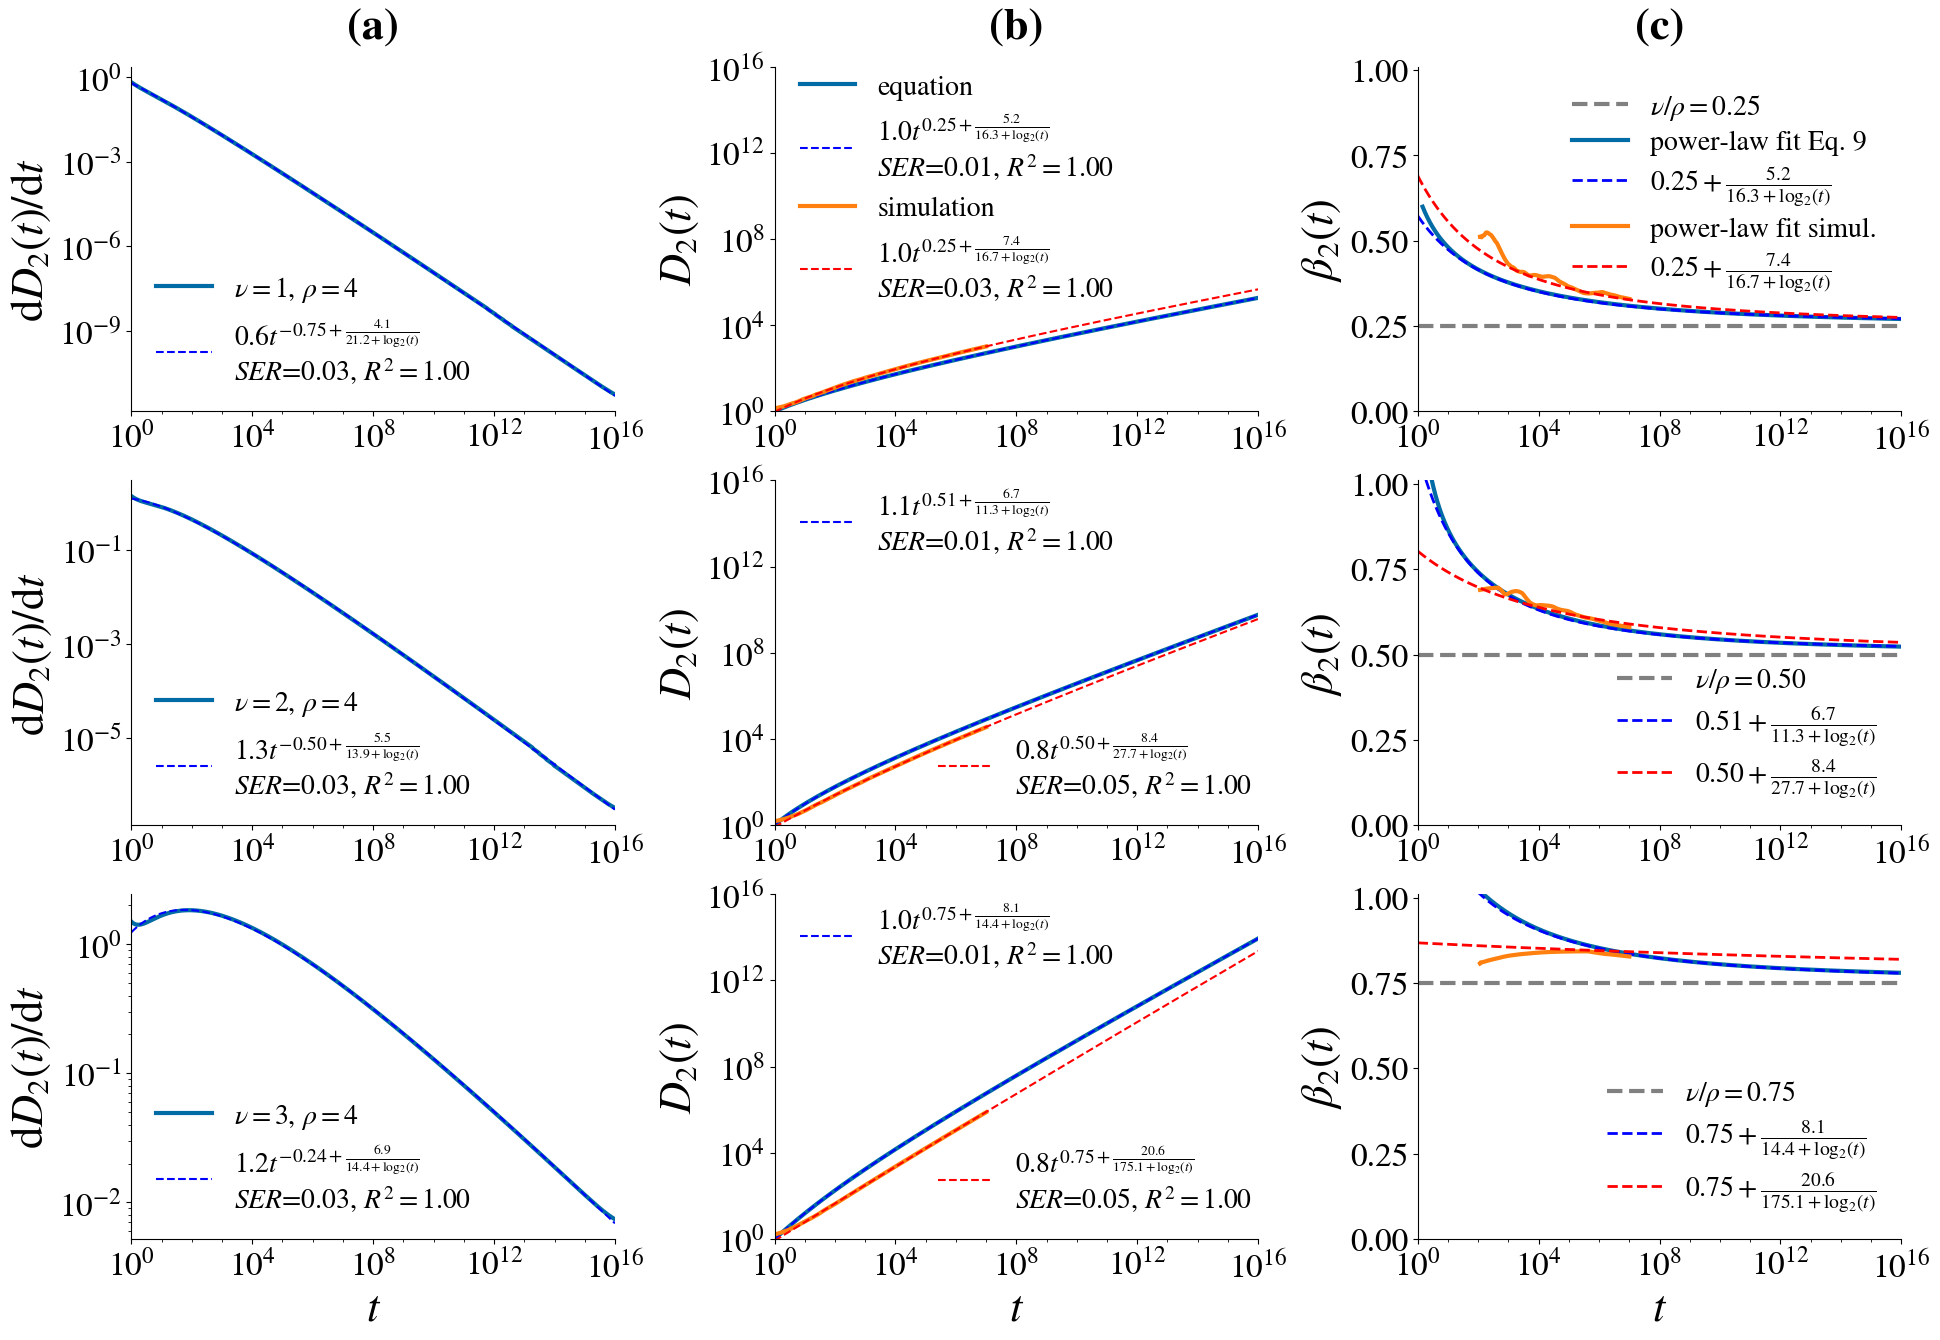

In [184]:
rho = 4
expMin = 0
expMax = 16
_ = simulation_vs_analytic_plot_SI(
    rho, results_simulations_long,fontsize_legend=20,
    lower_bound = 10**expMin, upper_bound = 10**expMax,
    expMin=expMin,expMax=expMax,
    use_odeint=True, 
    max_num_major_xticks = 5, 
    use_approximated=True,
)

1
ERROR (c) 
2
ERROR (c) 
3
ERROR (c) 


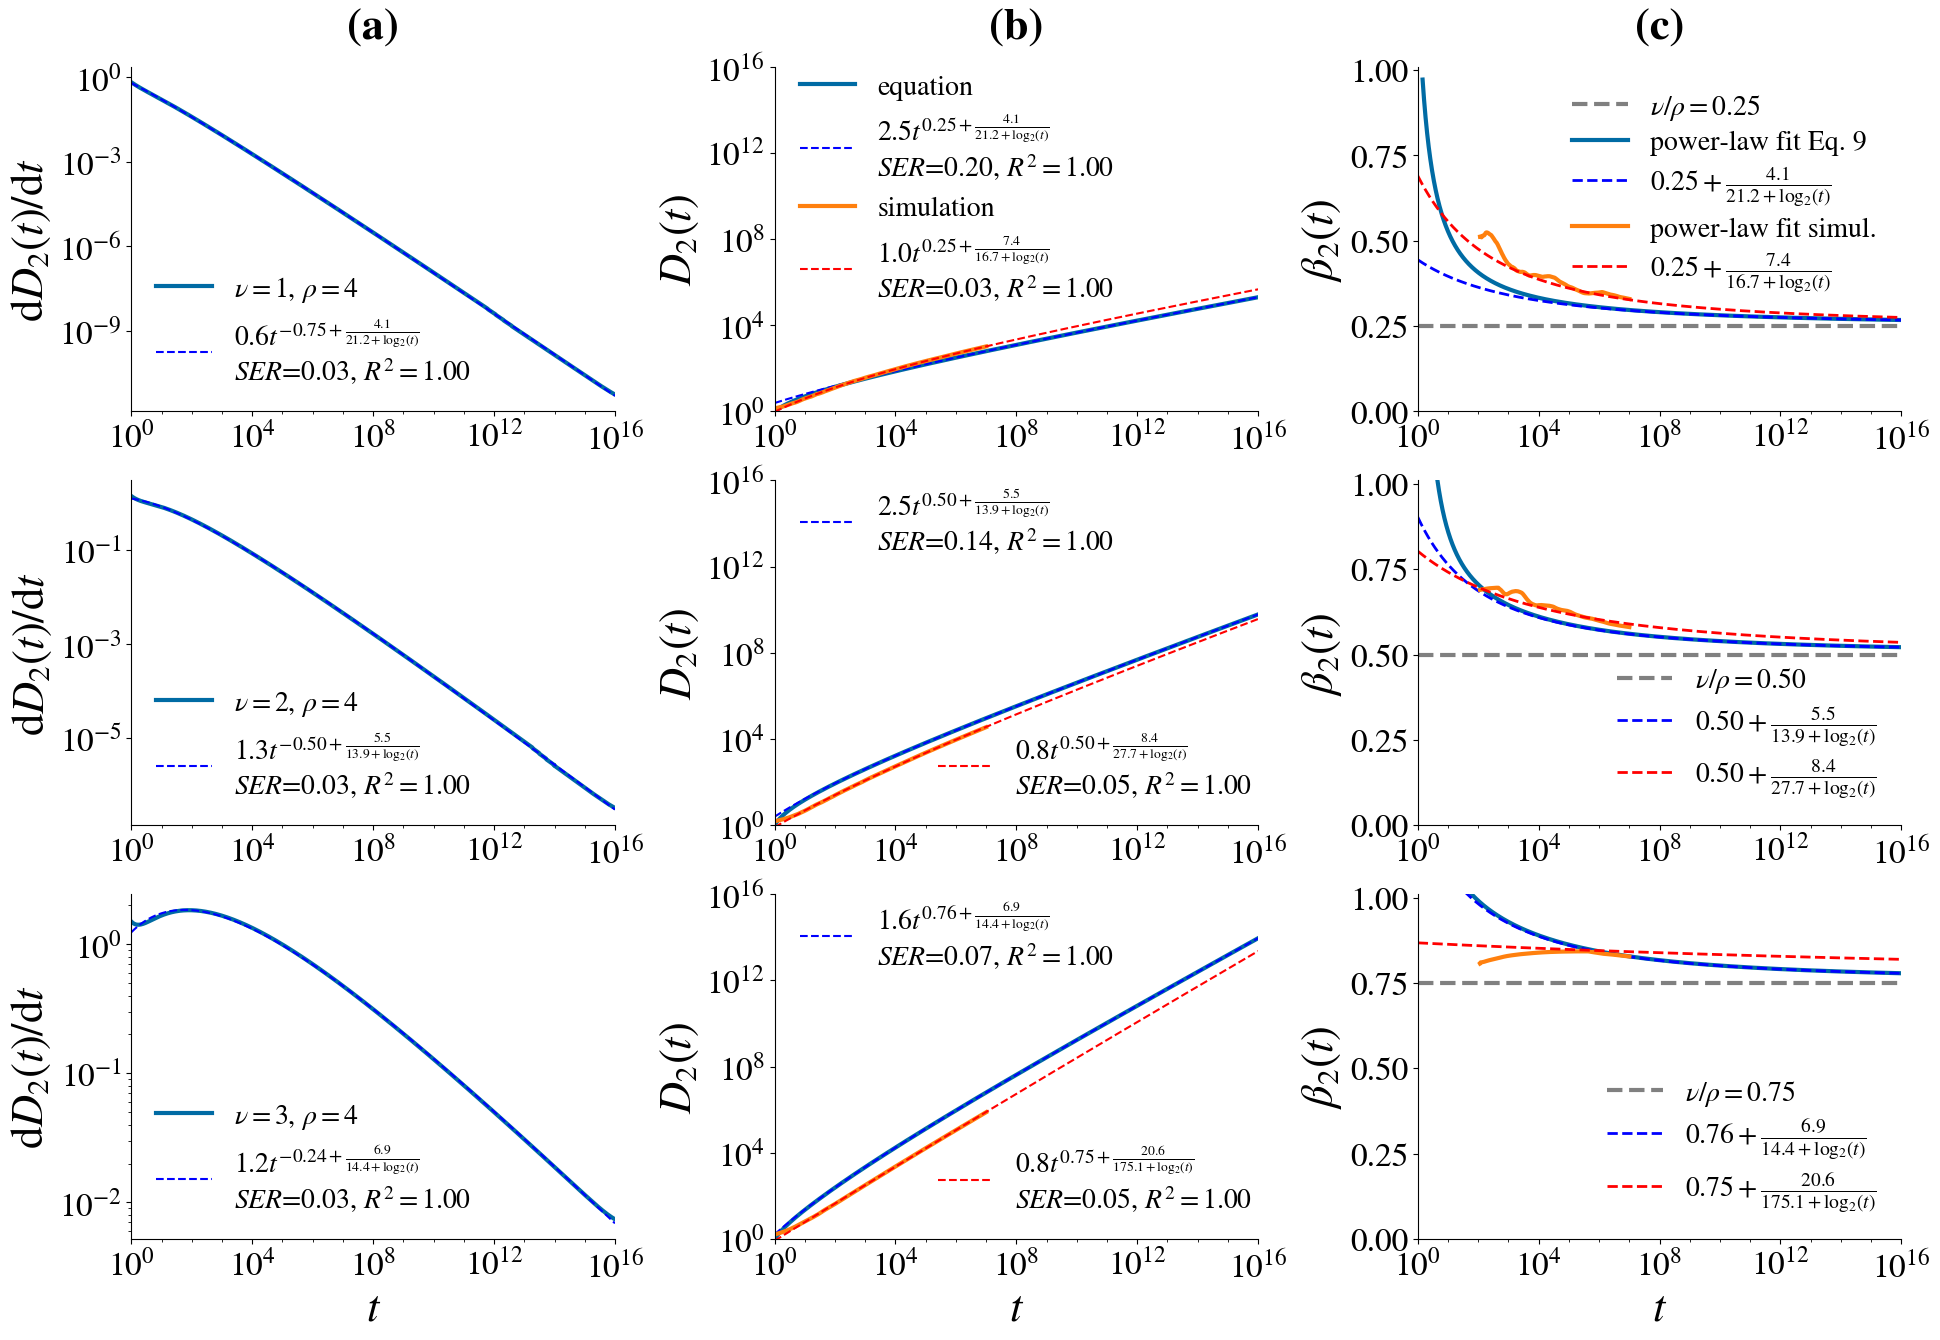

In [185]:
rho = 4
expMin = 0
expMax = 16
_ = simulation_vs_analytic_plot_SI(
    rho, results_simulations_long,fontsize_legend=20,
    lower_bound = 10**expMin, upper_bound = 10**expMax,
    expMin=expMin,expMax=expMax,
    use_odeint=False, 
    max_num_major_xticks = 5, 
    use_approximated=True,
)

### Triplets

#### Functions

In [ ]:
def fit_to_str(a,b,c,d):
#     return r"$%.1f t^{%.2f+%.1f/(%.1f+\log_2(t))}$"%(a,b,c,d)
    return r"$%.1f t^{%.2f+\frac{%.1f}{%.1f+\log_2(t)}}$"%(a,b,c,d)


def plot_dD3(analytic_data, nu, rho, ax, results_simulations, fontsize=16, print_all_legend_labels = True, use_approximated=True):
    xs = np.array(list(analytic_data.t))
    Cs = np.array(list(analytic_data.data))
    beta_1 = float(nu)/rho
    b = (rho - nu)**beta_1
    dD1 = b * beta_1 * (xs ** (beta_1 - 1))
    dD2_popt_log = results_simulations[1][rho][nu]['parameters_dD2']
    e=1
    f=0
    def func(x,a,b,c,d):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    dD2 = func(xs,*dD2_popt_log)
    ys = dD2 + dD1 + Cs

    
    if print_all_legend_labels:
        ax.plot(xs,ys, lw=3, label=r"$\nu = %d, \, \rho = %d$"%(nu,rho))
    else:
        ax.plot(xs,ys, lw=3) 
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    xs_log = np.log2(xs)
    ys_log = np.log2(ys)
    try:
        raise RuntimeError
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,p0=[1,nu/rho-1,1,1], bounds=([0,-1,0,0], [np.inf,0,np.inf,np.inf]))
    except RuntimeError as er:
        print('ERROR (a)',er)
        popt_log_B, pcov = curve_fit(func_log, xs_log, ys_log,bounds=([0,nu/rho-0.000000001-1,0,0.1], [np.inf,nu/rho+0.000000001-1,np.inf,np.inf]))
    a,b,c,d = popt_log_B
    b_old = b
    residuals = ys - func(xs, *popt_log_B)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = ys_log - func_log(xs_log, *popt_log_B)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(ys)
    R_squared_log = 1-(ss_res_log**2)/np.var(ys_log)
    ax.plot(xs, func(xs,*popt_log_B), 'b--',
             label=fit_to_str(a,b,c,d) + 
            "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log))

    exponents_log = np.array([b+c*d/((d+np.log2(e*x))**2) for x in xs])

    ax.set_xscale("log")
    ax.set_yscale("log")
    if nu/rho < 0.:
        ax.legend(fontsize=fontsize, loc = "upper right") 
    else:
        ax.legend(fontsize=fontsize, loc = "lower left")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\mathrm{d}D_3(t)/\mathrm{d}t}$")
    
    return popt_log_B

In [ ]:
def exp_to_str(a,b,c,d):
#         return r"$%.2f+%.1f/(%.1f+\log_2(t))$"%(b,c,d)
    return r"$%.2f+\frac{%.1f}{%.1f+\log_2(t)}$"%(np.round(b,decimals=2),np.round(c, decimals=1),np.round(d, decimals=1))
    
def plot_D3(analytic_data,mean_urn, popt_log_B, nu, rho, ax, expMax=16, fontsize=16, 
            print_all_legend_labels = True,
            use_odeint = False,
           ):
    from scipy.integrate import odeint
    def func(x,a,b,c,d,e=1,f=0):#,x2):
        return a * x ** (b+c/(d+np.log2(e*x))) + f
    t0 = 1 
    y0 = 1 
    e=1
    f=0
    ts_system = np.geomspace(t0,10**expMax,10000)
    if use_odeint == True:
        # y'(t) = func(t,a,b,c,d)
        def system(y, t, *popt_log_B):
            dy = [func(t,*popt_log_B)]
            return dy
        a,b,c,d = popt_log_B
        sol = odeint(system, y0 , ts_system, args=(a,b,c,d))
        sol = np.transpose(sol)[0]
    else:
        a,b,c,d = popt_log_B
        b += 1
        a /= b
        sol = func(ts_system,a,b,c,d)
        popt_log = (a,b,c,d)
        sol = sol - sol[0] + 1
    
    last_to_check = 100
    mean_urn["new_analytic3_loglogregr_points"] = np.array([powerLawRegrPoints(ts_system[max(0,i-last_to_check):i], sol[max(0,i-last_to_check):i])[0]
                                               for i in range(last_to_check,len(ts_system))])
    mean_urn["new_analytic3_loglogregr_points_xs"] = ts_system[last_to_check:]


    if print_all_legend_labels:
        label1 = r"equation"
    else:
        label1 = ""
    p1, = ax.plot(ts_system,sol, label=label1, lw=3)
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.log2(ts_system)
    sol_log = np.log2(sol)
    if use_odeint == True:
        try:
            raise RuntimeError
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1], bounds=([0,0,0,0], [2,1,100,100]))
        except RuntimeError as er:
            print('ERROR (b)',er)
            popt_log, pcov = curve_fit(func_log, ts_log, sol_log,p0=[1,float(nu)/rho,1,1],bounds=([0,float(nu)/rho-0.000000001,0,0.1], [2,nu/rho+0.000000001,100,100]))
        a,b,c,d = popt_log
    b_free = b
    exp_law_free = exp_to_str(a,b,c,d)
    residuals = sol - func(ts_system, *popt_log)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = sol_log - func_log(ts_log, *popt_log)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(sol)
    R_squared_log = 1-(ss_res_log**2)/np.var(sol_log)
    label2 = fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    p2, = ax.plot(ts_system, func(ts_system,*popt_log), 'b--',label=label2)
    exponents_eq = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])
    
    mean_urn['eq_fit_beta3_xs'] = ts_system
    mean_urn['eq_fit_beta3'] = exponents_eq

    
    if print_all_legend_labels:
        label3 = r"simulation"
    else:
        label3 = ""
    
    p3, = ax.plot(mean_urn["ts_geom"][2:]-2,mean_urn["D3_indices"][mean_urn['indices_geom']][2:], label= label3, lw=3)
    def func_log(x,a,b,c,d):
        return np.log2(a) + x * (b+c/(d+np.log2(e*2**x))) 
    ts_log = np.log2(mean_urn["ts_geom"][2:]-2)
    D3_indices_log = np.log2(mean_urn["D3_indices"][mean_urn['indices_geom']][2:])
    try:
        raise RuntimeError
        popt_sim, pcov = curve_fit(func_log, ts_log[30:], D3_indices_log[30:],p0=[1,float(nu)/rho,1,1],bounds=([0,0,0,0], [2,1,1000,1000]))
    except RuntimeError as er:
        print('ERROR (c)',er)
        popt_sim, pcov = curve_fit(func_log, ts_log, D3_indices_log,p0=[1,float(nu)/rho,1,1],bounds=([0,nu/rho-0.000000001,0,0], [1000,nu/rho+0.000000001,1000,1000]))
    a,b,c,d = popt_sim 
    b_sim = b
    exp_law_sim = exp_to_str(a,b,c,d)
    residuals = mean_urn["D3_indices"][mean_urn['indices_geom']][2:] - func(mean_urn["ts_geom"][2:]-2, *popt_sim)
    ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    residuals = D3_indices_log - func_log(ts_log, *popt_sim)
    ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
    R_squared = 1-(ss_res**2)/np.var(mean_urn["D3_indices"][mean_urn['indices_geom']][2:])
    R_squared_log = 1-(ss_res_log**2)/np.var(D3_indices_log)
    label4 = fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
    p4, = ax.plot(mean_urn["ts_geom"][2:]-2, func(mean_urn["ts_geom"][2:]-2,*popt_sim), 'r--',
             label=label4)
    exponents_sim = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])# mean_urn["ts_geom"]])
    
    mean_urn['sim_fit_beta3_xs'] = ts_system# mean_urn['ts_geom']
    mean_urn['sim_fit_beta3'] = exponents_sim

#     # REPEAT FOR D
    
#     ts_log = np.log2(mean_urn["ts_geom"])
#     D_indices_log = np.log2(mean_urn["D_indices"][mean_urn["indices_geom"]])
#     # popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,bounds=([0,0,0,0], [10,1,100,100]))
#     try:
#         raise RuntimeError
# #         popt_sim, pcov = curve_fit(func_log, ts_log, D2_indices_log,p0=[1,nu/rho,1,1],bounds=([0,0,0,0], [1,1,np.inf,np.inf]))
#         popt_sim, pcov = curve_fit(func_log, ts_log, D_indices_log,p0=[1,nu/rho,1,1],bounds=([0.9,0,0,0], [1,np.inf,np.inf,np.inf]))
#     except RuntimeError as er:
#         print('ERROR (d)',er)
#         popt_sim, pcov = curve_fit(func_log, ts_log, D_indices_log,p0=[1,nu/rho,1,1],bounds=([0,nu/rho-0.000000001,0,0], [np.inf,nu/rho+0.000000001,np.inf,np.inf]))
#     a,b,c,d = popt_sim # [2.30976089, -0.52648358,  4.94643769,  7.35037396]
#     b_sim = b
#     exp_law_sim = exp_to_str(a,b,c,d)
# #     print(popt_sim)
#     residuals = mean_urn["D2_indices"][mean_urn["indices_geom"]] - func(mean_urn["ts_geom"], *popt_sim)
#     ss_res = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
#     residuals = D_indices_log - func_log(ts_log, *popt_sim)
#     ss_res_log = np.sqrt(np.sum(residuals**2)/(len(residuals)-2))
#     R_squared = 1-(ss_res**2)/np.var(mean_urn["D2_indices"][mean_urn["indices_geom"]])
#     R_squared_log = 1-(ss_res_log**2)/np.var(D2_indices_log)
#     labelD = 'fit: %s'%fit_to_str(a,b,c,d) + "\n"+r"$SER$=%.2f"%ss_res_log + r", $R^2=%.2f$"%(R_squared_log)
#     exponents_simD = np.array([b+c*d/((d+np.log2(e*x))**2) for x in ts_system])# mean_urn["ts_geom"]])

#     mean_urn['sim_fit_beta_xs'] = ts_system# mean_urn["ts_geom"]
#     mean_urn['sim_fit_beta'] = exponents_simD
    
    
    ax.set_xlim(left=100, right = 1e7)
    ax.set_ylim(bottom=1, top=1e7)
    
    if nu/rho < 0.4:
        ax.legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) # loc = "upper left")
    else:
        if print_all_legend_labels:
            l1 = ax.legend([p1, p2],[label1,label2], fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) #, loc="upper left")
            l2 = ax.legend([p3, p4],[label3,label4], fontsize=fontsize, loc='lower right', bbox_to_anchor=(1.04, 0)) # , loc="lower right")
        else:
            l1 = ax.legend([p2],[label2], fontsize=fontsize, loc='upper left', bbox_to_anchor=(0., 1.05)) #, loc="upper left")
            l2 = ax.legend([p4],[label4], fontsize=fontsize, loc='lower right', bbox_to_anchor=(1.04, 0)) # , loc="lower right")
        ax.add_artist(l1)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$D_3(t)$")

    return mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_free, exp_law_sim

In [ ]:
def final_plot_fits_D3(urn, nu, rho, ax, exp_law_free, exp_law_sim,fontsize=16, print_all_legend_labels = True, max_num_major_xticks = 5):
    ax.axhline(nu/rho,ls="--",color="gray",lw=3,label=r"$\nu/\rho=%.2f$"%(nu/rho))
    ax.plot(urn["new_analytic3_loglogregr_points_xs"],np.array(urn["new_analytic3_loglogregr_points"]),lw=3, color = CB_color_cycle[0], 
            label = "power-law fit Eq. 31" if print_all_legend_labels else None) # label = r"$\beta_2$ (eq. p.l. fit)")
    ax.plot(urn["eq_fit_beta3_xs"], np.array(urn["eq_fit_beta3"]),ls='--',lw=2, color = "blue", #CB_color_cycle[0], 
            label = fr"{exp_law_free}") # label = r"$\beta_2$ (eq. an. fit)")
    ax.plot(urn["ts_geom"][100:], np.array(urn["beta3_loglogregr_indices_geom"])[100:],lw=3, color = CB_color_cycle[1], 
            label = "power-law fit simul." if print_all_legend_labels else None) # label = r"$\beta_2$ (sim. p.l. fit)")
    ax.plot(urn["sim_fit_beta3_xs"], np.array(urn["sim_fit_beta3"]),ls='--',lw=2, color = "red", #CB_color_cycle[1], 
            label = fr"{exp_law_sim}") # label = r"$\beta_2$ (sim. an. fit)")
    
#     if print_all_legend_labels:
    if nu/rho > 0.4:
        ax.legend(fontsize=fontsize, loc = "lower right", labelspacing = 0.3,)
    else:
        ax.legend(fontsize=fontsize, loc = "upper right", labelspacing = 0)

    
    ax.set_xlim((100,Tmax))
    ax.set_ylim((0,1.01))
    ax.set_xscale("log")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\beta_3(t)$")
    # Impose xticks
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
    ax.xaxis.set_major_locator(locmaj)
    # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
    locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    return None

In [ ]:
def simulation_vs_analytic_plot_D3(rho, results_simulations,
                                fontsize_legend=16, lower_bound = 1e3, upper_bound = 1e7, 
                                use_approximated=True, expMin=3, expMax=7, 
                                   max_num_major_xticks = 5,
                                use_odeint=False,):
    Tmax = int(1e7)
    eta = 1
    counter = 0
    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower()
    fig, axes = plt.subplots(rho-1,3,figsize=(width_fig,width_fig*2/3*(rho-1)/3), gridspec_kw={'hspace':.2,'wspace':0.33})
    for row,nu in enumerate(range(1,rho)):
        print(nu)
        if row == 0:
            print_all_legend_labels = True
        else:
            print_all_legend_labels = False
        mean_urn = results_simulations[eta][rho][nu]
        indices = mean_urn["indices"]
        indices_geom = mean_urn["indices_geom"]
        ts = mean_urn["ts"]
        ts_geom = mean_urn["ts_geom"]

        if expMax <= 7:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent_triplet/rho{rho}_nu{nu}_expMin{expMin}_expMax{expMax}_data.csv",names=["t","data"])
        else:
            analytic_data = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent_triplet/rho{rho}_nu{nu}_expMin{expMin}_expMax{7}_data.csv",names=["t","data"])
            analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent_triplet/rho{rho}_nu{nu}_expMin{7}_expMax{10}_data.csv",names=["t","data"])
            analytic_data2.drop(analytic_data2.index[0], inplace=True)
            analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            if expMax > 10:
                analytic_data2 = pd.read_csv(f"./data/UMST/Analytic_UMT/Analytic_data_independent_triplet/rho{rho}_nu{nu}_expMin{10}_expMax{20}_data.csv",names=["t","data"])
                analytic_data2.drop(analytic_data2.index[0], inplace=True)
                analytic_data = analytic_data.append(analytic_data2, ignore_index=True)
            analytic_data = analytic_data[analytic_data.t <= 10**expMax]
#         analytic_data.data = analytic_data.data.apply(lambda x:min(x,1))
        
        ax = axes[row,0] if rho > 2 else axes[0]
        popt_log_B = plot_dD3(analytic_data, nu, rho, ax, results_simulations, fontsize=fontsize_legend, print_all_legend_labels=True,use_approximated=use_approximated)
        results_simulations[eta][rho][nu]['parameters_dD3'] = popt_log_B
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
        # Impose xticks
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
        ax.xaxis.set_major_locator(locmaj)
        # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
        locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#         ax.set_xticks([10**3, 10**5, 10**7])
        counter += 1
        
        ax = axes[row,1] if rho > 2 else axes[1]
        mean_urn, ts_system, exponents_eq, exponents_sim, exp_law_eq, exp_law_sim = plot_D3(
            analytic_data, mean_urn, popt_log_B, nu, rho, ax, 
            expMax=expMax,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            use_odeint = use_odeint, 
        )
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
#         ax.set_xticks([10**3, 10**5, 10**7])
        counter += 1
        ax.set_ylim(1,upper_bound)
        
        # Impose xticks
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
        ax.xaxis.set_major_locator(locmaj)
        # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
        locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        

        ax = axes[row,2] if rho > 2 else axes[2]
        final_plot_fits_D3(
            mean_urn, nu, rho, ax, exp_law_eq, exp_law_sim,
            fontsize=fontsize_legend, 
            print_all_legend_labels=print_all_legend_labels,
            max_num_major_xticks = max_num_major_xticks, 
        )
        
        if nu != rho-1:
            ax.set_xlabel("")
        if row == 0:
            ax.text(0.5, 1.08, f"({letters[counter]})", transform=ax.transAxes, fontweight='bold', horizontalalignment='center')
        ax.set_xlim(lower_bound, upper_bound)
# #         ax.set_xticks([10**3, 10**5, 10**7])
#         ax.set_ylabel(r"$\beta_n$")
        counter += 1
        # Impose xticks
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=max_num_major_xticks) 
        ax.xaxis.set_major_locator(locmaj)
        # locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=20)
        locmin = matplotlib.ticker.LogLocator(base=10.0,numticks=100)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        
    if use_odeint == True:
        fig.savefig(os.path.join(figures_folder, f"FigSI_D3_UMT_numeric_vs_analytic_rho_%d_odeint.png"%(rho)))
        fig.savefig(os.path.join(figures_folder, f"FigSI_D3_UMT_numeric_vs_analytic_rho_%d_odeint.pdf"%(rho)))
    else:
        fig.savefig(os.path.join(figures_folder, f"FigSI_D3_UMT_numeric_vs_analytic_rho_%d_from_dD3.png"%(rho)))
        fig.savefig(os.path.join(figures_folder, f"FigSI_D3_UMT_numeric_vs_analytic_rho_%d_from_dD3.pdf"%(rho)))
        
    return(results_simulations)

#### Figures

In [ ]:
expMax = 7
_ = simulation_vs_analytic_plot_D3(4, results_simulations_long,fontsize_legend=20,
                                       lower_bound = 1e0, upper_bound = 10**(expMax),
                                       expMin=0,expMax=expMax,
                                   max_num_major_xticks = 5,
                                       use_odeint=True, 
                                       use_approximated=True,)

1
ERROR (a) 
ERROR (b) 
ERROR (c) 
2
ERROR (a) 
ERROR (b) 
ERROR (c) 
3
ERROR (a) 
ERROR (b) 
ERROR (c) 


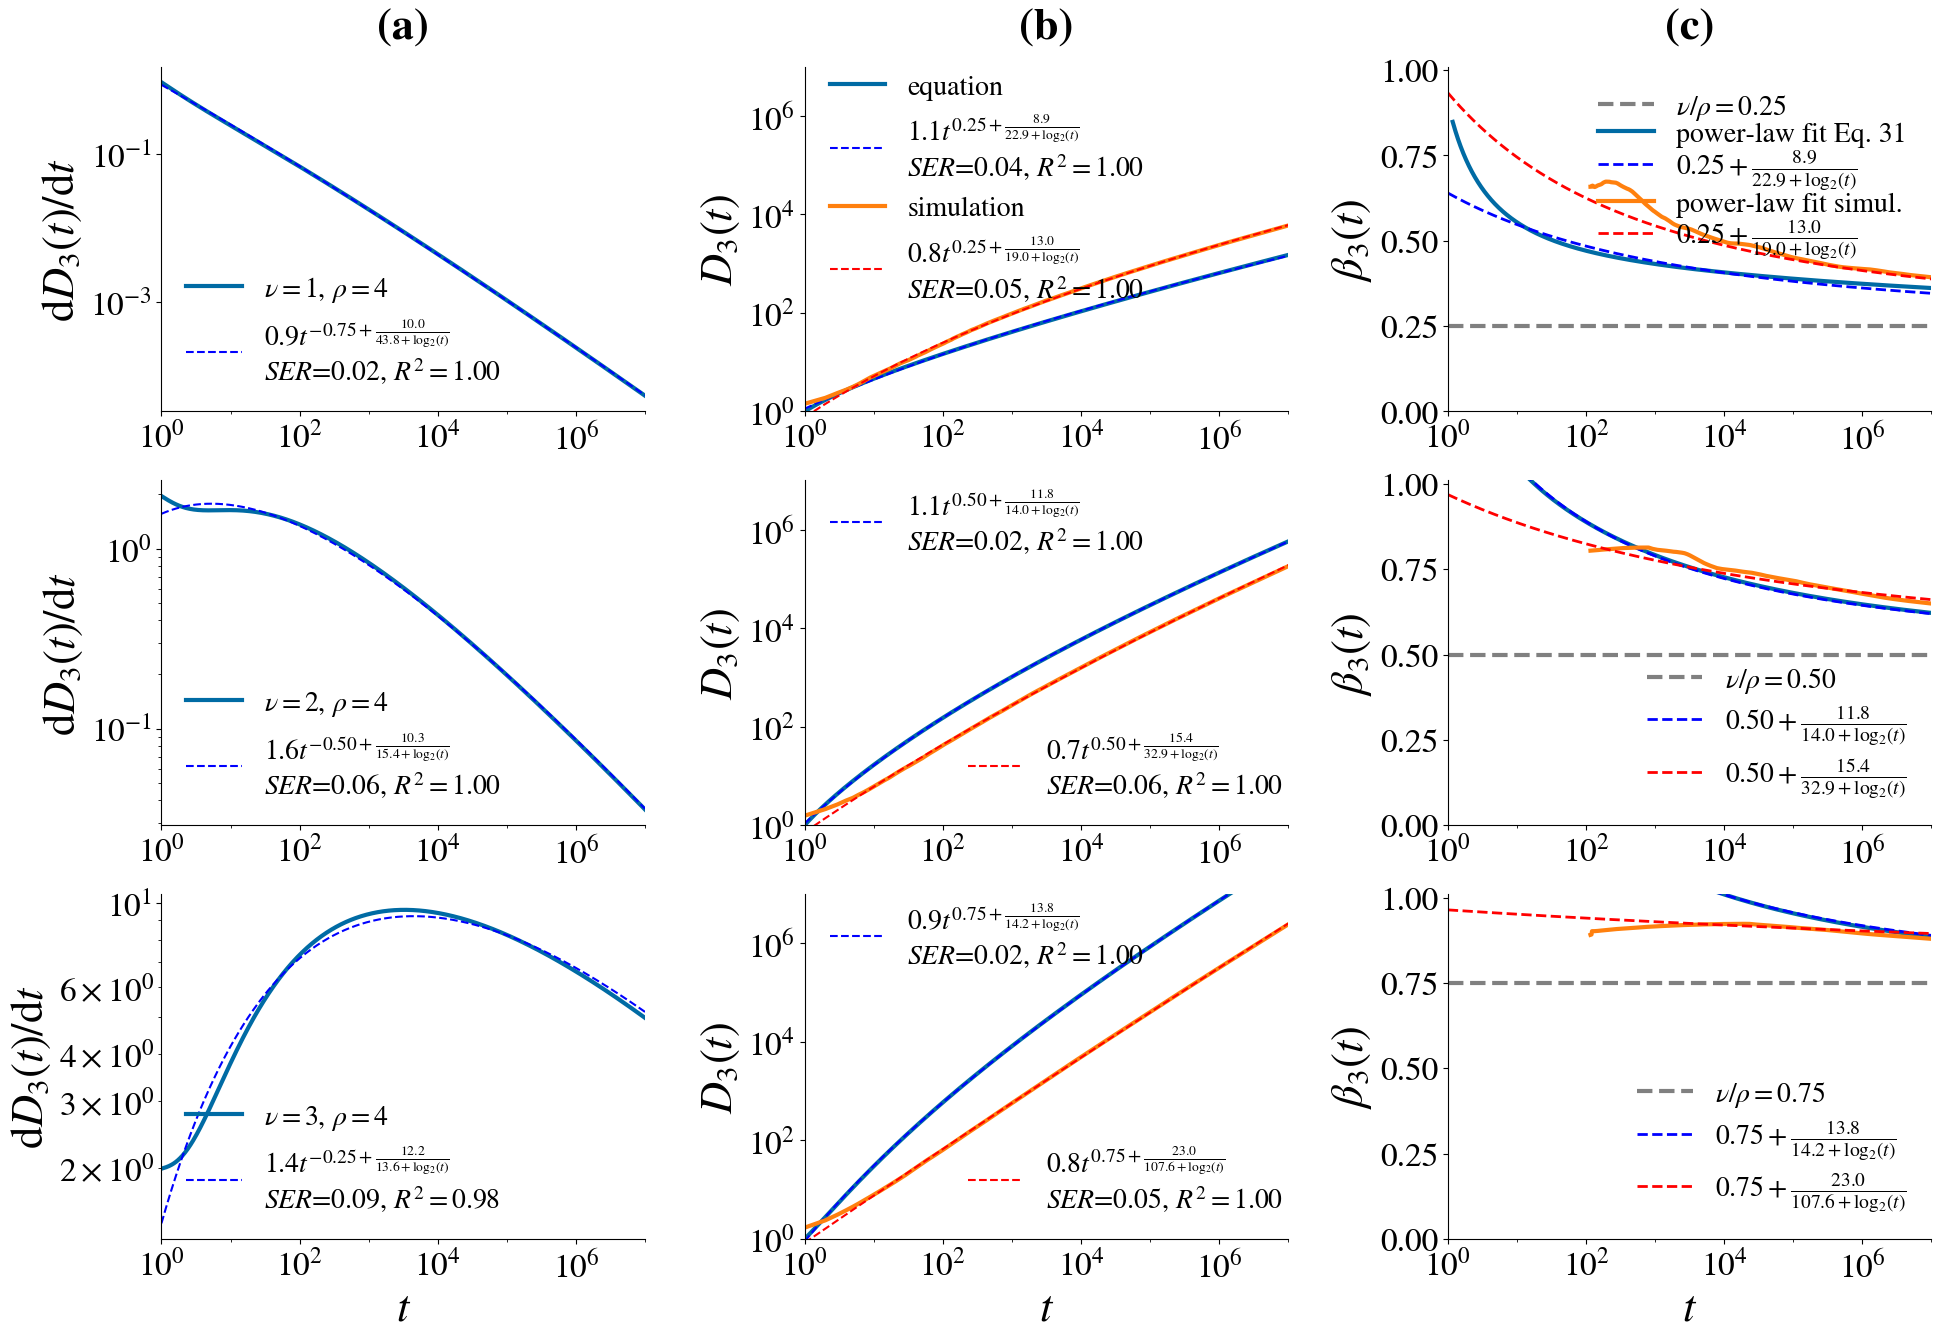

In [202]:
expMax = 7
_ = simulation_vs_analytic_plot_D3(4, results_simulations_long,fontsize_legend=20,
                                       lower_bound = 1e0, upper_bound = 10**(expMax),
                                       expMin=0,expMax=expMax,
                                   max_num_major_xticks = 5,
                                       use_odeint=True, 
                                       use_approximated=True,)